## Getting Results

In [74]:
import os
import re
import sys
import pandas as pd
from astropy.cosmology import Planck15
import numpy as np
import scipy.stats as stats
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from astropy.stats import mad_std as mad

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'stix'  # Times New Roman Math equivalent
mpl.rcParams['font.family'] = 'Times New Roman'

from imgprocesslib import *

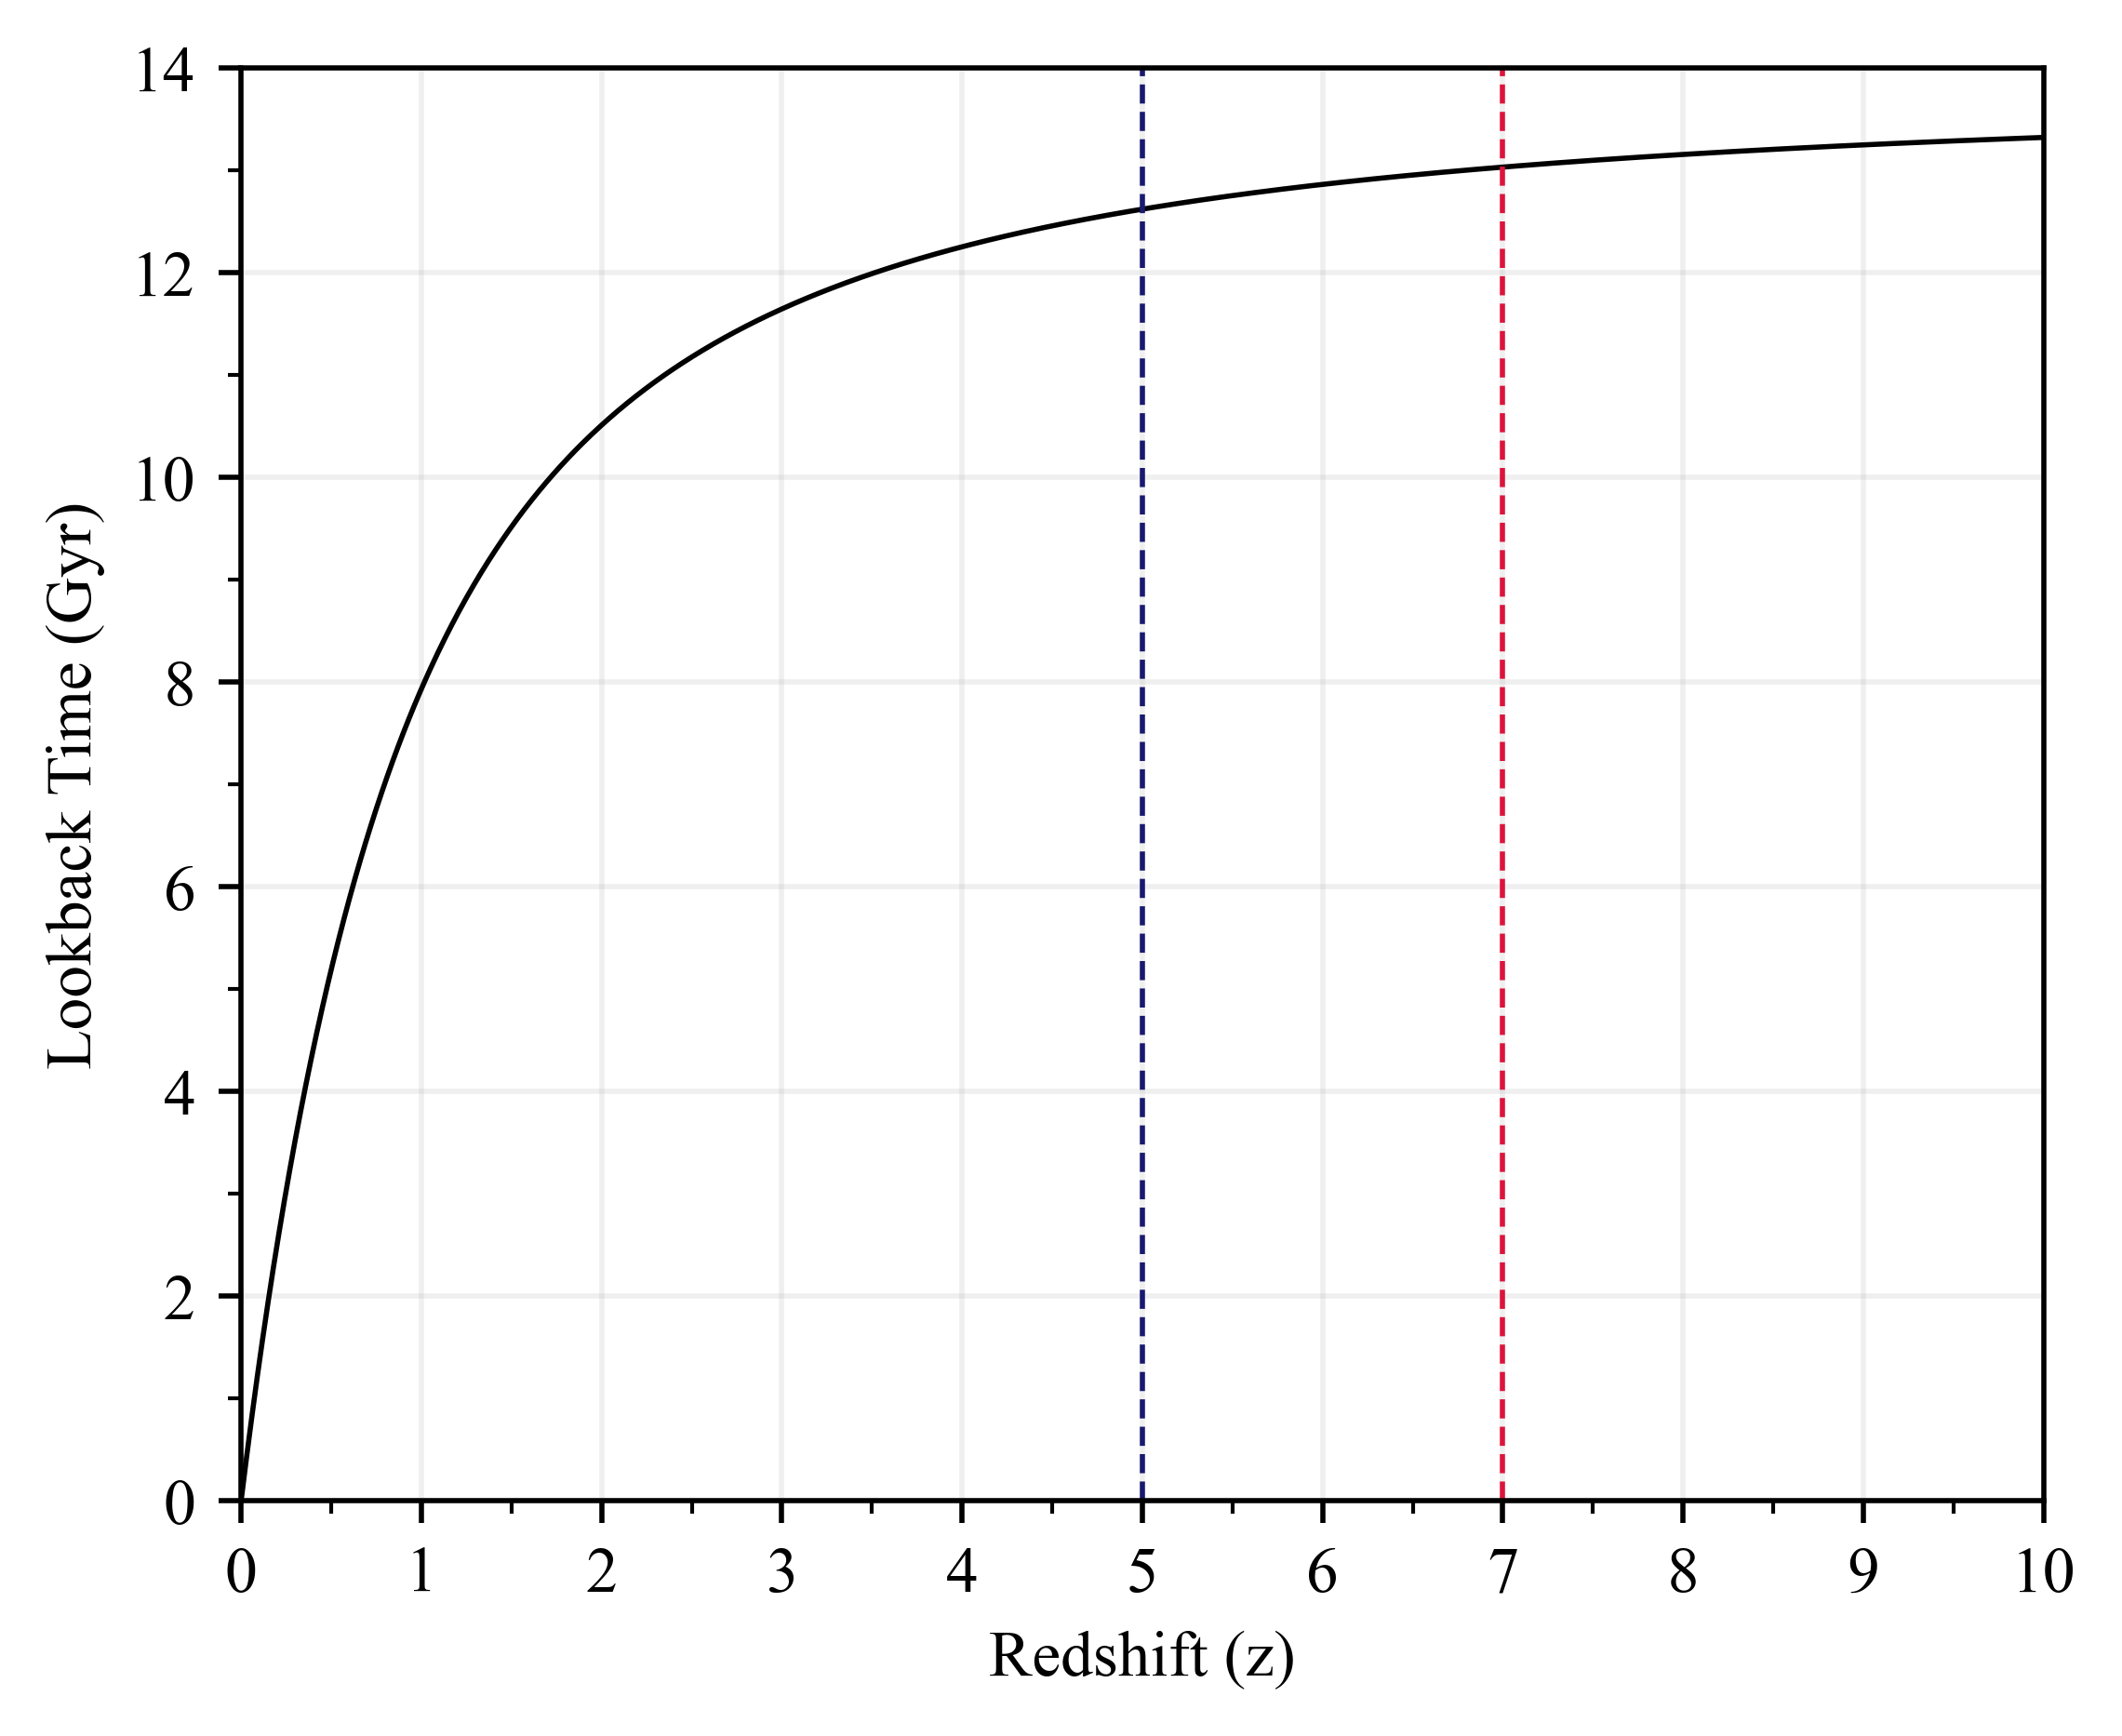

In [77]:
# Define an array of redshift values
redshifts = np.linspace(0, 10, 1000)

# Calculate lookback time for each redshift using the Planck15 cosmology
lookback_times = Planck15.lookback_time(redshifts)

# Plotting
plt.figure(dpi=500, figsize=(5, 4))
plt.plot(redshifts, lookback_times, label='Lookback Time', color='black', linewidth=0.8)
plt.axvline(x=5, color='midnightblue', linestyle='--', linewidth=0.8)
plt.axvline(x=7, color='crimson', linestyle='--', linewidth=0.8)
plt.xlabel('Redshift (z)')
plt.ylabel('Lookback Time (Gyr)')

plt.xlim(0, 10)
plt.ylim(0, 14)

plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.grid(True, alpha=0.2)
plt.show()

findfont: Font family ['stix'] not found. Falling back to DejaVu Sans.


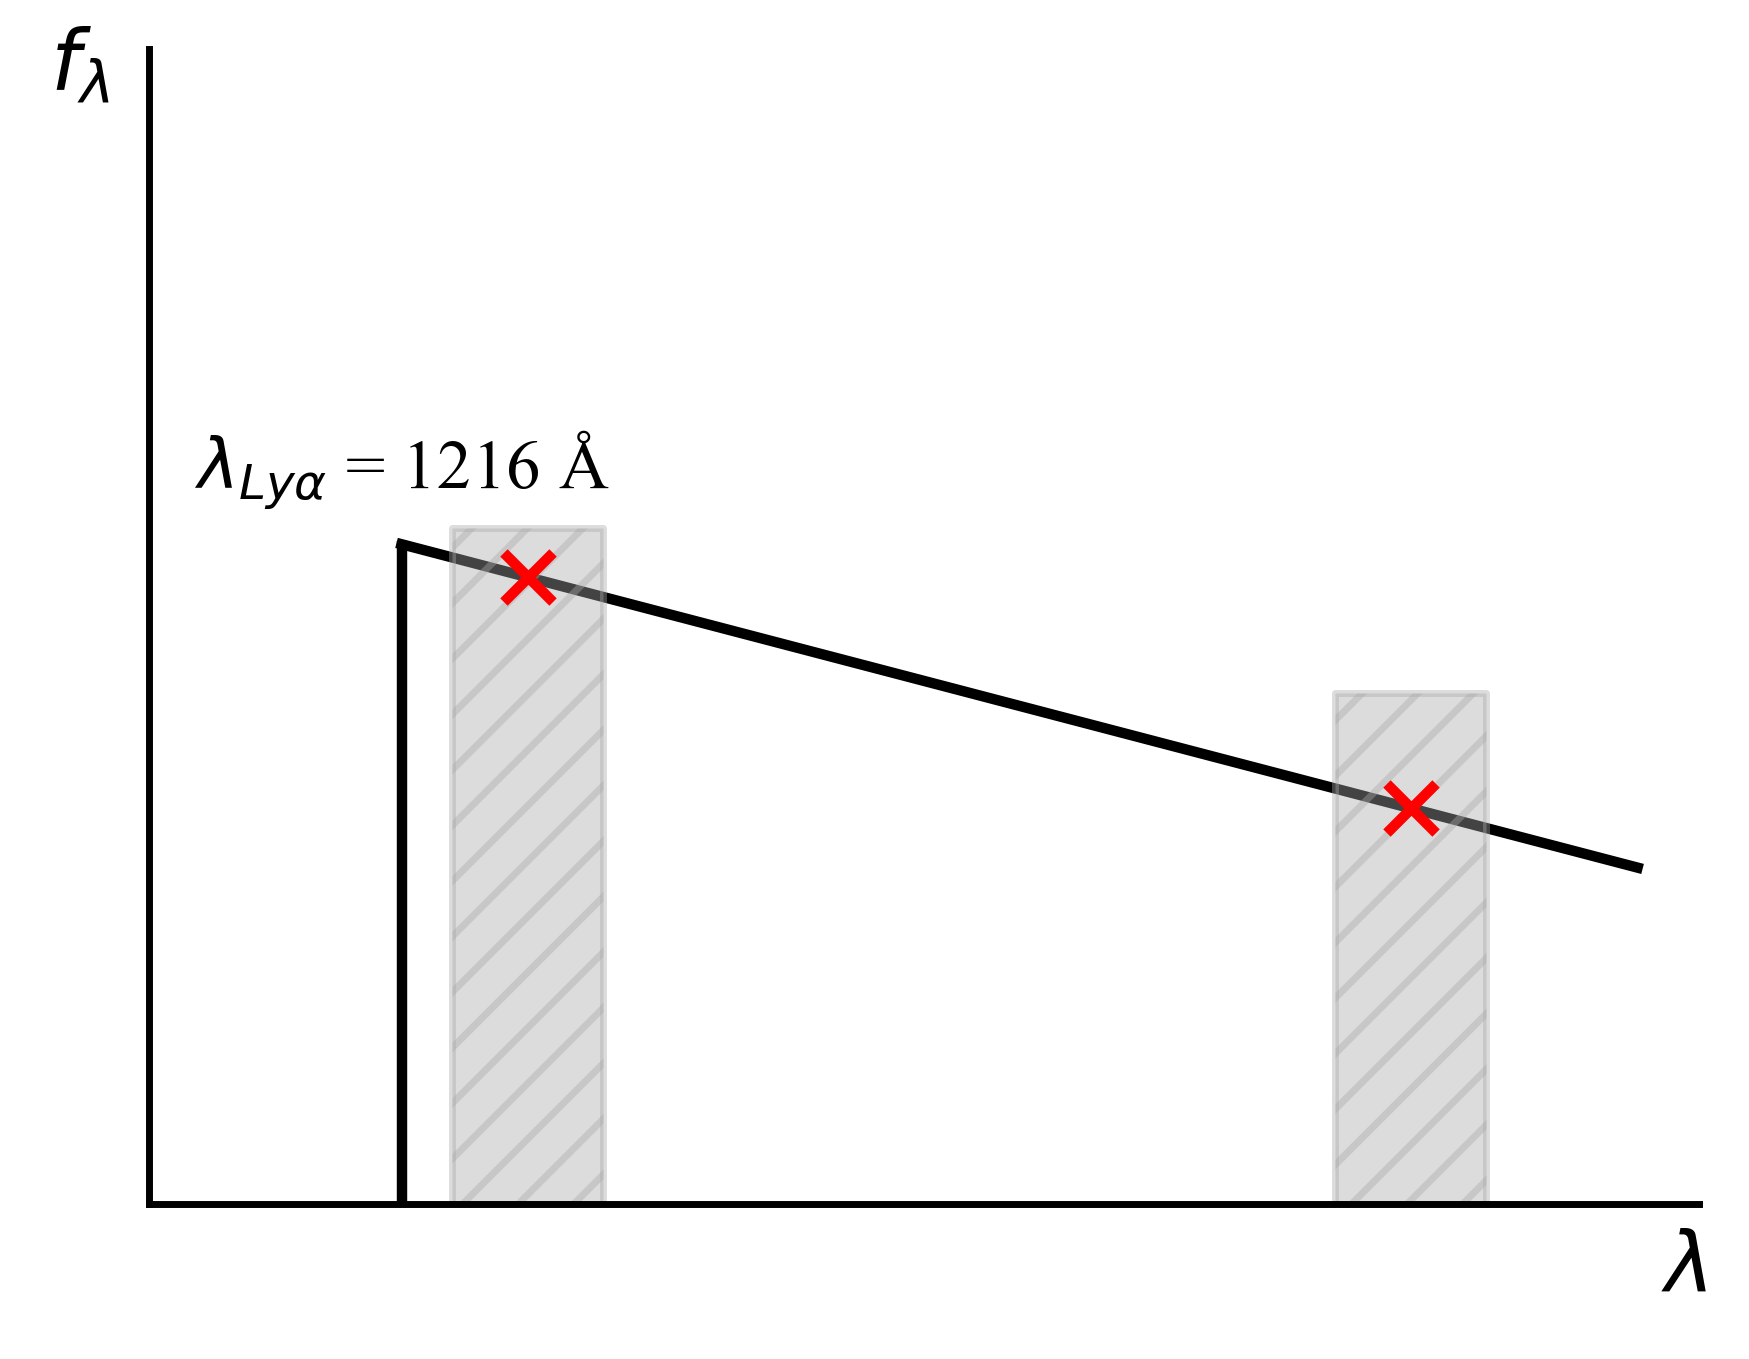

In [3]:
plt.figure(dpi=500, figsize=(4, 3))
a = np.arange(5, 10, 0.1)
b = -2*a


plt.plot(a, b, c='k', zorder=0)
plt.axvline(5, ymin=-30, ymax=0.57, c='k')
plt.text(5, -9, r'$\lambda_{Ly\alpha}$ = 1216 Å', ha='center', va='bottom', color='k')
plt.scatter([5.5, 9], [-11, -18], c='red', marker='x', s=50, zorder=2)
plt.ylim(-30, 5)
plt.xlim(4, )


plt.fill_betweenx([plt.ylim()[0], -9.5], 5.2, 5.8, color='darkgrey', alpha=0.4, hatch='///', zorder=1)
plt.fill_betweenx([plt.ylim()[0], -14.5], 8.7, 9.3, color='darkgrey', alpha=0.4, hatch='///', zorder=1)

plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# make x label to the right of the plot
plt.xlabel(r'$\lambda$', fontsize=12, x=0.99)
plt.ylabel(r'$f_{\lambda}$', fontsize=12, y=0.95, rotation=0, labelpad=10)

# make tips of the axis to be arrowheads
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)

plt.show()

In [4]:
# Merged Catologue
data_cat_full = pd.read_csv(os.path.join(homedir, 'Output', 'Catalogue', 'Matched_MODIFIED_Catalogue_all.txt'), sep='\s+')
data_cat = pd.read_csv(os.path.join(homedir, 'Output', 'Catalogue', 'Matched_Catalogue.txt'), sep='\s+')
data_mod_cat = pd.read_csv(os.path.join(homedir, 'Output', 'Catalogue', 'Matched_MODIFIED_Catalogue.txt'), sep='\s+')
ross_cat = pd.read_csv(os.path.join(homedir, 'Output', 'Blythe_jades_dr1.cat'), sep='\s+')

# Read Matched Catalogue (Modified) into a dictionary
data_mod = {}
for key in data_mod_cat.keys():
    data_mod[key] = data_mod_cat[key].values
        
    #data_mod[key] = (data_mod_cat[key].values).astype()

data_mod_cat = pd.DataFrame(data_mod)
data_mod_cat

In [5]:
Fil_vals = np.array([8984.98, 11433.62, 14872.56, 18388.83, 19680.41, 20908.35, 27278.58, 33537.23, 35287.04, 40723.18,
                     42784.79, 4341.36, 43504.26, 46269.86, 48139.33, 5776.43, 7624.32, 8019.74, 9115.28])

Fil_vals_mod = np.array([8984.98, 11433.62, 14872.56, 19680.41, 27278.58, 33537.23, 35287.04, 40723.18, 4341.36, 43504.26, 
                         5776.43, 7624.32, 8019.74, 9115.28])

410 - 4262.86 <br>
335 - 3389.42

In [6]:
def solve(data):
    # Difference in Magnitudes
    data['diff_mag'] = (data['mag_f410m'] - data['mag_f335m'])
    # EWs
    data['EWs_phot_410'] = ((4262.86)*(10**(-0.4*data['diff_mag'])))/(1+data['z_phot'])
    data['EWs_spec_410'] = ((4262.86)*(10**(-0.4*data['diff_mag'])))/(1+data['z_spec'])

    data['EWs_phot_335'] = ((3389.42)*(10**(-0.4*data['diff_mag'])))/(1+data['z_phot'])
    data['EWs_spec_335'] = ((3389.42)*(10**(-0.4*data['diff_mag'])))/(1+data['z_spec'])

    # Luminosities/Magnitudes
    data['mag_f090w'] = -(2.5 * np.log10(data['f090w'])) + 23.9
    data['mag_f150w'] = -(2.5 * np.log10(data['f150w'])) + 23.9
    data['mag_f115w'] = -(2.5 * np.log10(data['f115w'])) + 23.9
    data['mag_f200w'] = -(2.5 * np.log10(data['f200w'])) + 23.9
    
    # Colour
    data['del_mag_5'] = (data['mag_f090w'] - data['mag_f150w'])
    data['del_mag_7'] = (data['mag_f115w'] - data['mag_f200w'])

    # Spectral Slope
    data['beta_5'] = (data['del_mag_5']/(2.5*np.log10(14872.56/8984.98)))-2.0
    data['beta_7'] = (data['del_mag_7']/(2.5*np.log10(19680.41/11433.62)))-2.0

    # MASKS
    SIGMACUT = (data['f356w'] > data['f356w_err']*5)
    MAGCUT = (data['mag_f356w'] > 29.6)
    HA_335_cut = (data['z_phot'] > 3.8) & (data['z_phot'] < 4.6)
    HA_410_cut = (data['z_phot'] > 4.6) & (data['z_phot'] < 5.35)

    OIII_335_cut = (data['z_phot'] > 5.35) & (data['z_phot'] < 6.4)
    OIII_410_cut = (data['z_phot'] > 6.75) & (data['z_phot'] < 7.55)

    return data, HA_335_cut, HA_410_cut, OIII_335_cut, OIII_410_cut, SIGMACUT, MAGCUT

data_cat = solve(data_cat)
data_mod_cat = solve(data_mod_cat)
data_cat_full = solve(data_cat_full)

In [7]:
data_cat, HA_335, HA_410, OIII_335, OIII_410, SIGMACUT_410, MAGCUT_410 = solve(data_cat)
data_mod_cat, HA_335_mod, HA_410_mod, OIII_335_mod, OIII_410_mod, SIGMACUT_410_mod, MAGCUT_410_mod = solve(data_mod_cat)
data_cat_full, HA_335_full, HA_410_full, OIII_335_full, OIII_410_full, SIGMACUT_full, MAGCUT_full = solve(data_cat_full)

c:\Users\blybe\miniconda3\envs\astro-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\blybe\miniconda3\envs\astro-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\blybe\miniconda3\envs\astro-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\blybe\miniconda3\envs\astro-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\blybe\miniconda3\envs\astro-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\blybe\miniconda3\envs\astr

master_cat, HA_335_master, HA_410_master, OIII_335_master, OIII_410_master, SIGMACUT_master, MAGCUT_master = solve(master_cat)

In [8]:
filters_list  = [{'Telescope': 'NIRCam Short Wavelength',
                  'filters': ['090w', '115w', '150w', '182m', '200w', '210m'],
                  'colours': ['#B7AAEE', '#AF47FF', '#5C55B3', '#99CCFF', '#00A8E0', '#0101DF']},
                 {'Telescope': 'NIRCam Long Wavelength',
                  'filters': ['277w', '335m', '356w', '410m', '430m', '444w', '460m', '480m'],
                  'colours': ['#256E37', '#B58653', '#A84900', '#0B412B', '#51C083', '#C8D96F', '#89931E', '#6DB41D']},
                 {'Telescope': 'HST ACS', 
                  'filters': ['435w', '606w', '775w', '814w', '850lp'],
                  'colours': ['#660000', '#DD0000', '#DB2E6B', 'orange', '#E0D100']},
                ]

In [9]:
filters_list  = [{'Telescope': 'NIRCam Short Wavelength',
                  'filters': ['090w', '115w', '150w', '182m', '200w', '210m'],
                  'colours': ['#B7AAEE', '#AF47FF', '#5C55B3', '#99CCFF', '#00A8E0', '#0101DF']},
                 {'Telescope': 'NIRCam Long Wavelength',
                  'filters': ['277w', '335m', '356w', '410m', '430m', '444w', '460m', '480m'],
                  'colours': ['#1CE026', '#904300', '#FFB370', '#2C302E', '#6CF4C4', '#C8D96F', '#909590', '#85AE5F']},
                 {'Telescope': 'HST ACS', 
                  'filters': ['435w', '606w', '775w', '814w', '850lp'],
                  'colours': ['#660000', '#DD0000', '#DB2E6B', 'orange', '#E0D100']},
                ]

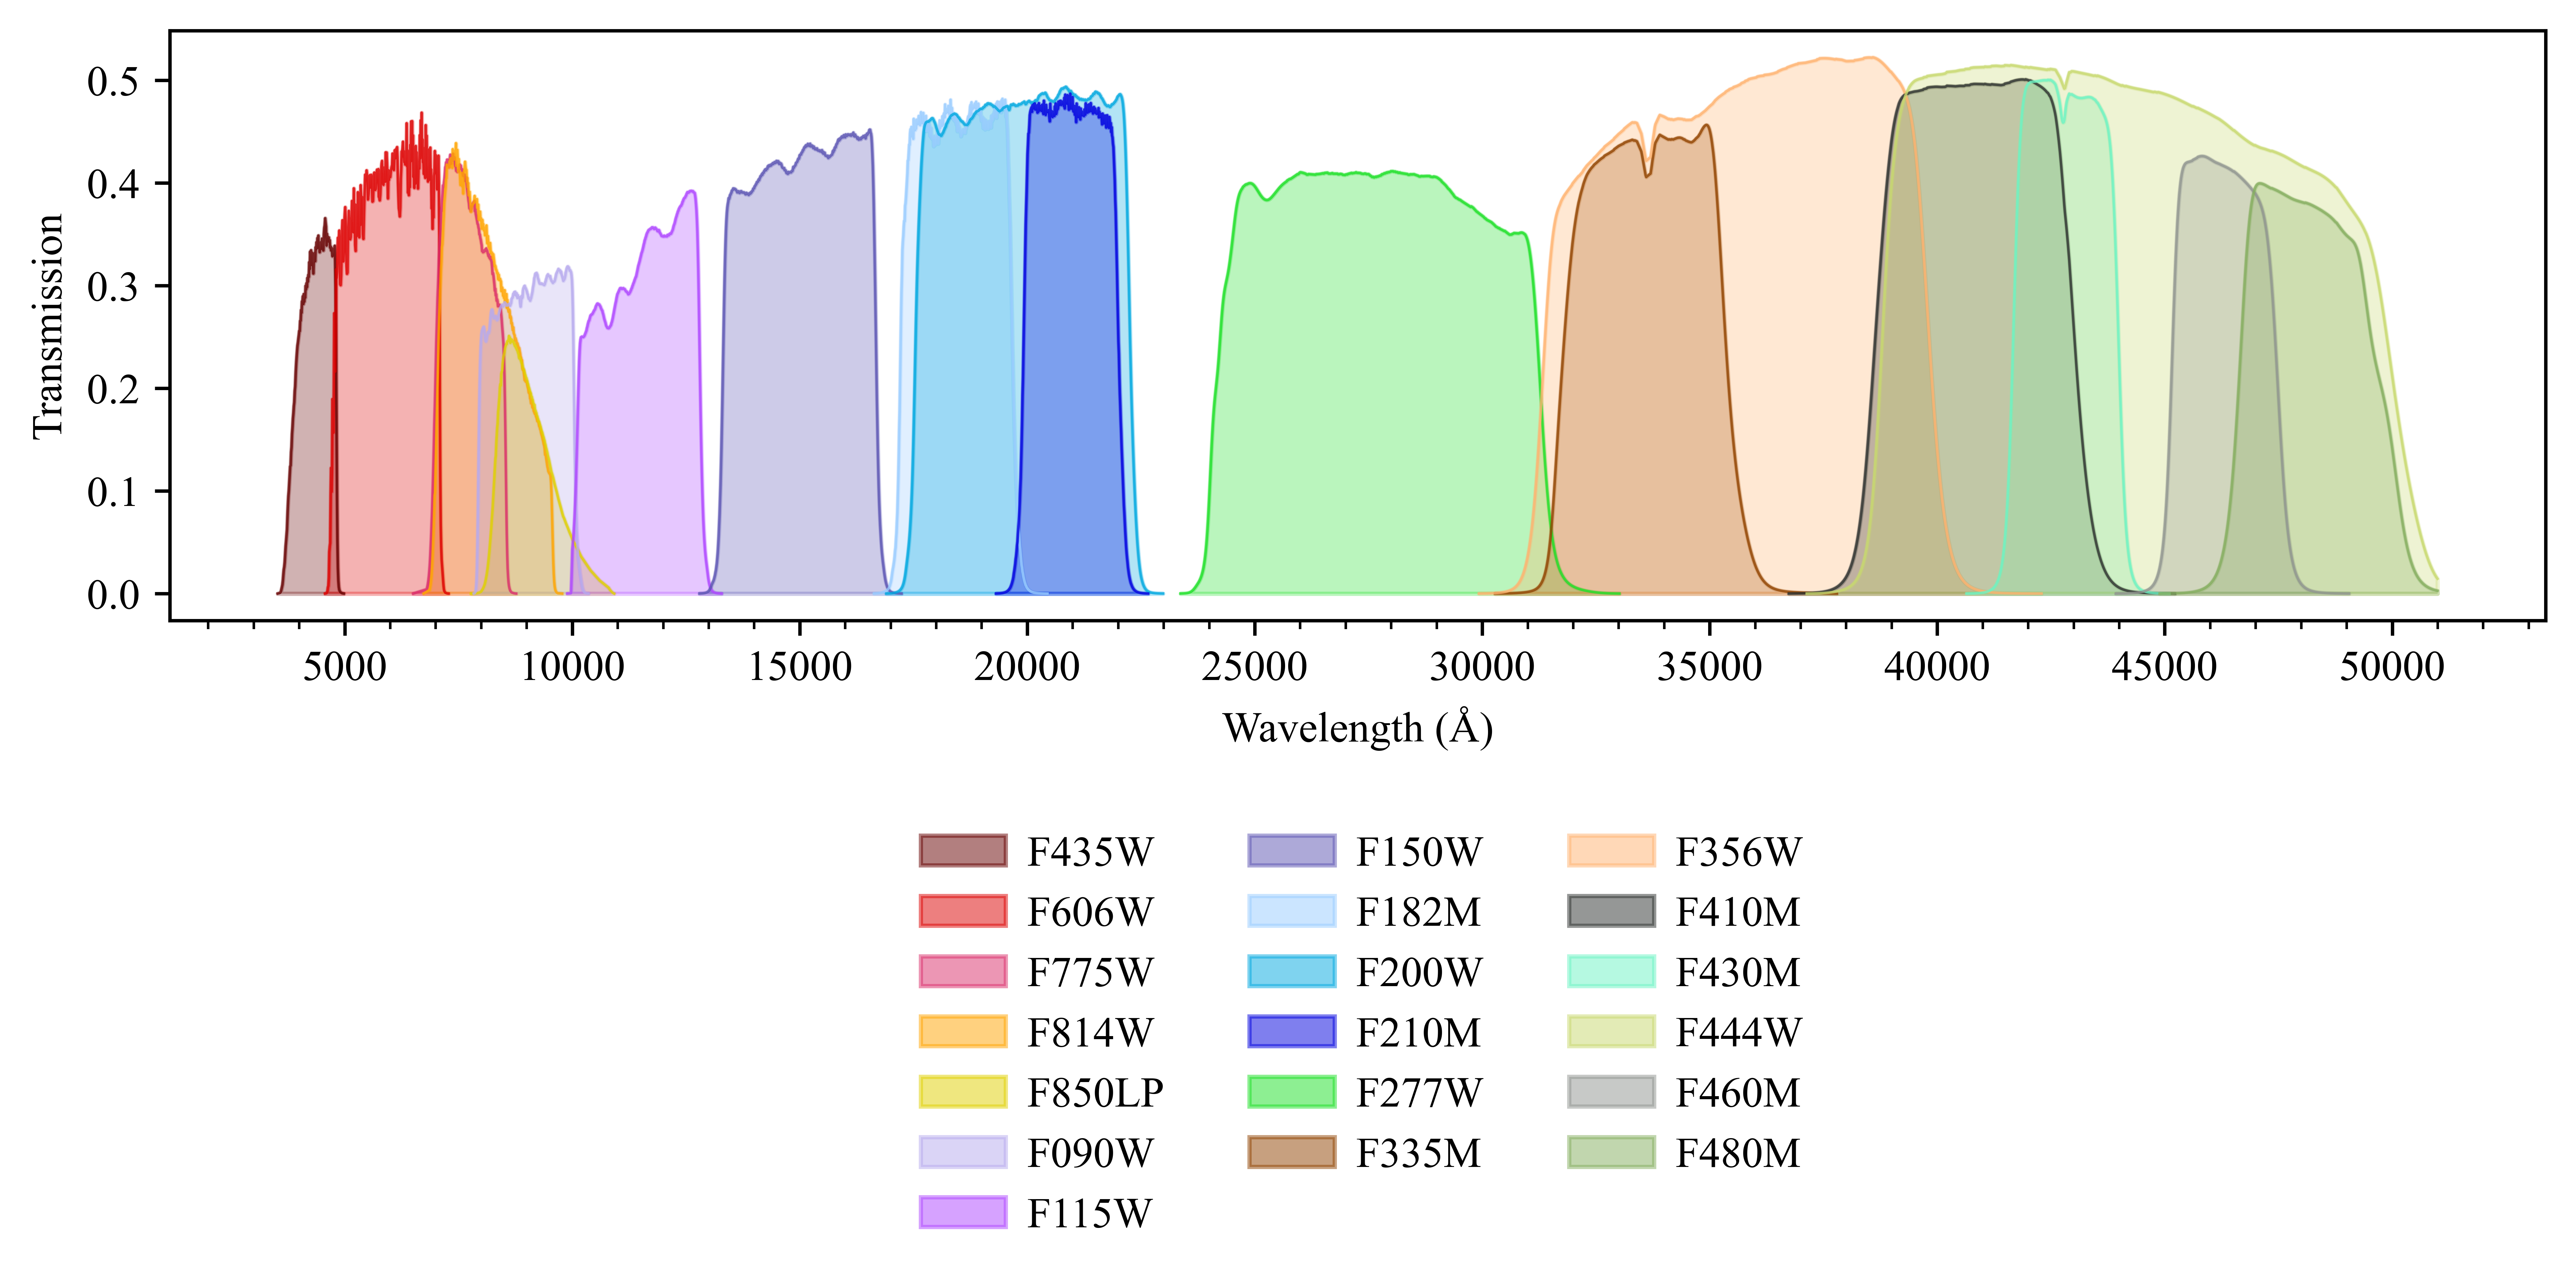

In [10]:
plt.figure(dpi=1000, figsize=(10, 2.5))

for file in os.listdir(os.path.join(homedir, "Filter_files")):
    if file.endswith('.dat'):
        for t in filters_list:
            for fil in t['filters']:
                if fil.upper() in file.split('.')[1]:
                    data = pd.read_csv(os.path.join(homedir, "Filter_files", file), sep='\s+', header=None, names=['Wavelength', 'Transmission'])
                    plt.plot(data['Wavelength'], data['Transmission'], color=t['colours'][t['filters'].index(fil)], alpha=0.8, linewidth=0.6)
                    plt.fill_between(data['Wavelength'], data['Transmission'], label=f'F{fil.upper()}', color=t['colours'][t['filters'].index(fil)], alpha=0.3) 

plt.xlabel('Wavelength (Å)')
plt.ylabel('Transmission')
#plt.title('Filter Transmission Profiles')
leg = plt.legend(ncol=3, bbox_to_anchor=(0.3, -0.3), loc='upper left', frameon=False, columnspacing=2, handletextpad=0.5)
for lh in leg.legend_handles:
    lh.set_alpha(0.5)

plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(5000))
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(5))

#plt.xlim(0, 50000)
plt.show()

# Create combined figure
fig = plt.figure(figsize=(8,6), dpi=500)
plt.title('Redshift')
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2,1])
axs = gs.subplots(sharex=True)

# Plot 1
axs[0].scatter(data_mod_cat['z_spec'], data_mod_cat['z_phot'], s=0.5, color='black', alpha=0.6)
axs[0].set_ylabel('Photometric Redshift (z)')
axs[0].set_xlim(0, max(data_mod_cat['z_spec']))  # Set x-axis limit here
x_line_u = np.linspace(0, max(data_mod_cat['z_spec']), 2)
x_line_d = np.linspace(0, max(data_mod_cat['z_spec']), 2)
m_u = 1.15 * x_line_u
m_d = 0.85 * x_line_d
axs[0].plot(x_line_u, m_u, 'black', linewidth=0.5, alpha=0.5)
axs[0].plot(x_line_d, m_d, 'black', linewidth=0.5, alpha=0.5)
axs[0].xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
axs[0].yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

# Plot 2
axs[1].scatter(data_cat['z_phot'], (data_cat['z_phot']-data_cat['z_spec'])/(1+data_cat['z_spec']), s=0.5, color='black', alpha=0.6)
axs[1].scatter(ross_cat['z_phot'], (ross_cat['z_phot']-ross_cat['z_spec'])/(1+ross_cat['z_spec']), s=0.5, color='indianred', alpha=0.6, label='Ross')
axs[1].set_xlabel('Photometric Redshift (z)')
axs[1].set_ylabel('Residuals')
axs[1].set_ylim(-0.75, 0.75)
#axs[1].set_xlim(0, max(data_cat['z_phot']))  # Set x-axis limit here

# Show the plots
plt.show()


fig = plt.figure(figsize=(8,6), dpi=500)
plt.title('Redshift')
gs = fig.add_gridspec(2, hspace=0, height_ratios=[2,1])
axs = gs.subplots(sharex=True)


# Plot1
#axs[0].scatter(data_cat['z_spec'], data_cat['z_phot'], s=0.5, color='black', alpha=0.6)
axs[0].scatter(data_mod_cat['z_spec'], data_mod_cat['z_phot'], s=0.5, color='black', alpha=0.6)
#axs[0].scatter(ross_cat['z_spec'], ross_cat['z_phot'], s=0.5, color='indianred', alpha=0.6, label='Ross')
#axs[0].plot([], [], label='±15% Error', color='black', linewidth=0.5, alpha=0.5)

axs[0].set(ylabel='Photometric Redshift (z)')
#axs[0].set_ylim(0, )
#xlim = plt.xlim(0, )
x_line_u = np.linspace(0, max(data_cat['z_spec']), 2)
x_line_d = np.linspace(0, max(data_cat['z_spec']), 2)
m_u = 1.15 * x_line_u
m_d = 0.85 * x_line_d
axs[0].plot(x_line_u, m_u, 'black', linewidth=0.5, alpha=0.5)
axs[0].plot(x_line_d, m_d, 'black', linewidth=0.5, alpha=0.5)



# Plot2
axs[1].scatter(data_cat['z_phot'], (data_cat['z_phot']-data_cat['z_spec'])/(1+data_cat['z_spec']), s=0.5, color='black', alpha=0.6)
axs[1].scatter(ross_cat['z_phot'], (ross_cat['z_phot']-ross_cat['z_spec'])/(1+ross_cat['z_spec']), s=0.5, color='indianred', alpha=0.6, label='Ross')

axs[1].set(ylabel='Residuals')
#axs[1].set_ylim(-0.75, 0.75)

#plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(6))
plt.xlabel('Spectroscopic Redshift (z)')
plt.show()

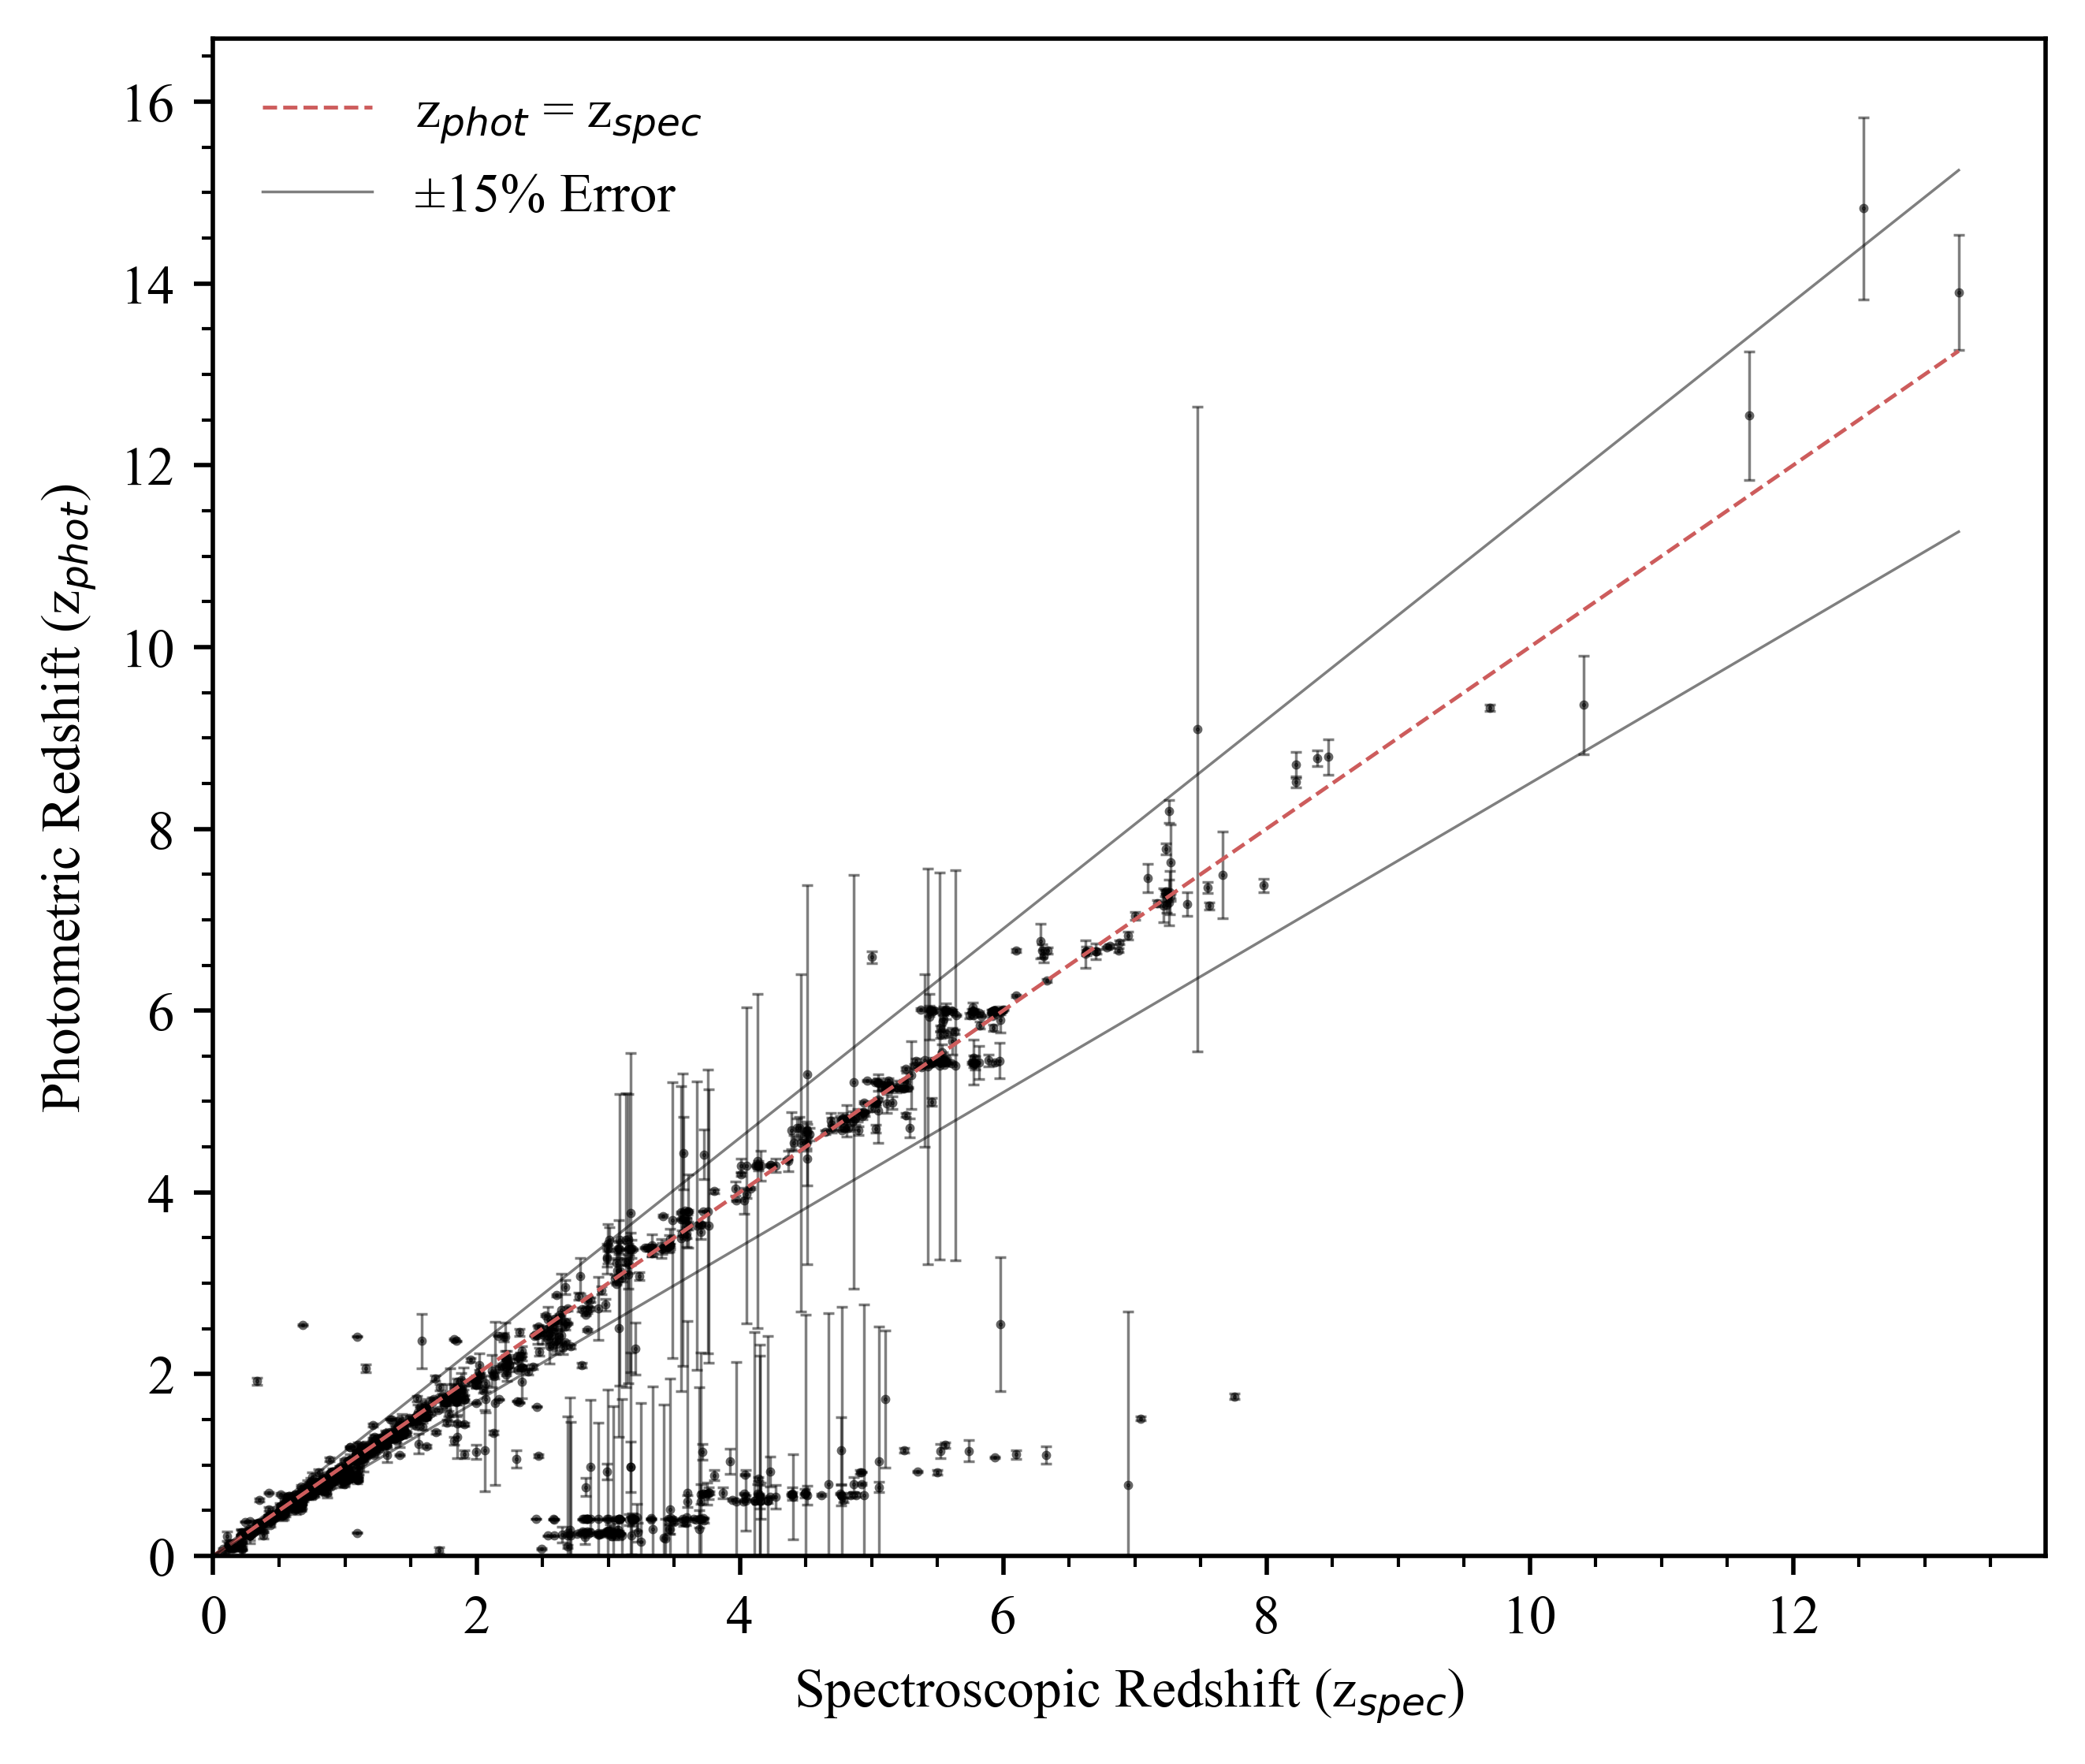

In [11]:
plt.figure(dpi=500, figsize=(6, 5))

dat = data_cat_full[(data_cat_full['z_spec'] >= 0)]

plt.errorbar(dat['z_spec'], dat['z_phot'], 
             yerr=abs(dat['z_err']), color='black', 
             alpha=0.5, elinewidth=0.5, capsize=1, capthick=0.5, linewidth=0)

plt.scatter(dat['z_spec'], dat['z_phot'], s=0.5, color='black', alpha=0.6)

plt.plot([0, max(dat['z_spec'])], [0, max(dat['z_spec'])], color='indianred', linewidth=0.7, linestyle='--', label='z$_{phot}$ = z$_{spec}$')

plt.xlabel('Spectroscopic Redshift (z$_{spec}$)')
plt.ylabel('Photometric Redshift (z$_{phot}$)')

plt.ylim(0, )
xlim = plt.xlim(0, )

x_line_u = np.linspace(0, max(dat['z_spec']), 2)
x_line_d = np.linspace(0, max(dat['z_spec']), 2)
m_u = 1.15 * x_line_u
m_d = 0.85 * x_line_d
plt.plot(x_line_u, m_u, 'black', linewidth=0.5, alpha=0.5, label='±15% Error')
plt.plot(x_line_d, m_d, 'black', linewidth=0.5, alpha=0.5)

plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(4))

plt.legend(frameon=False)
plt.show()

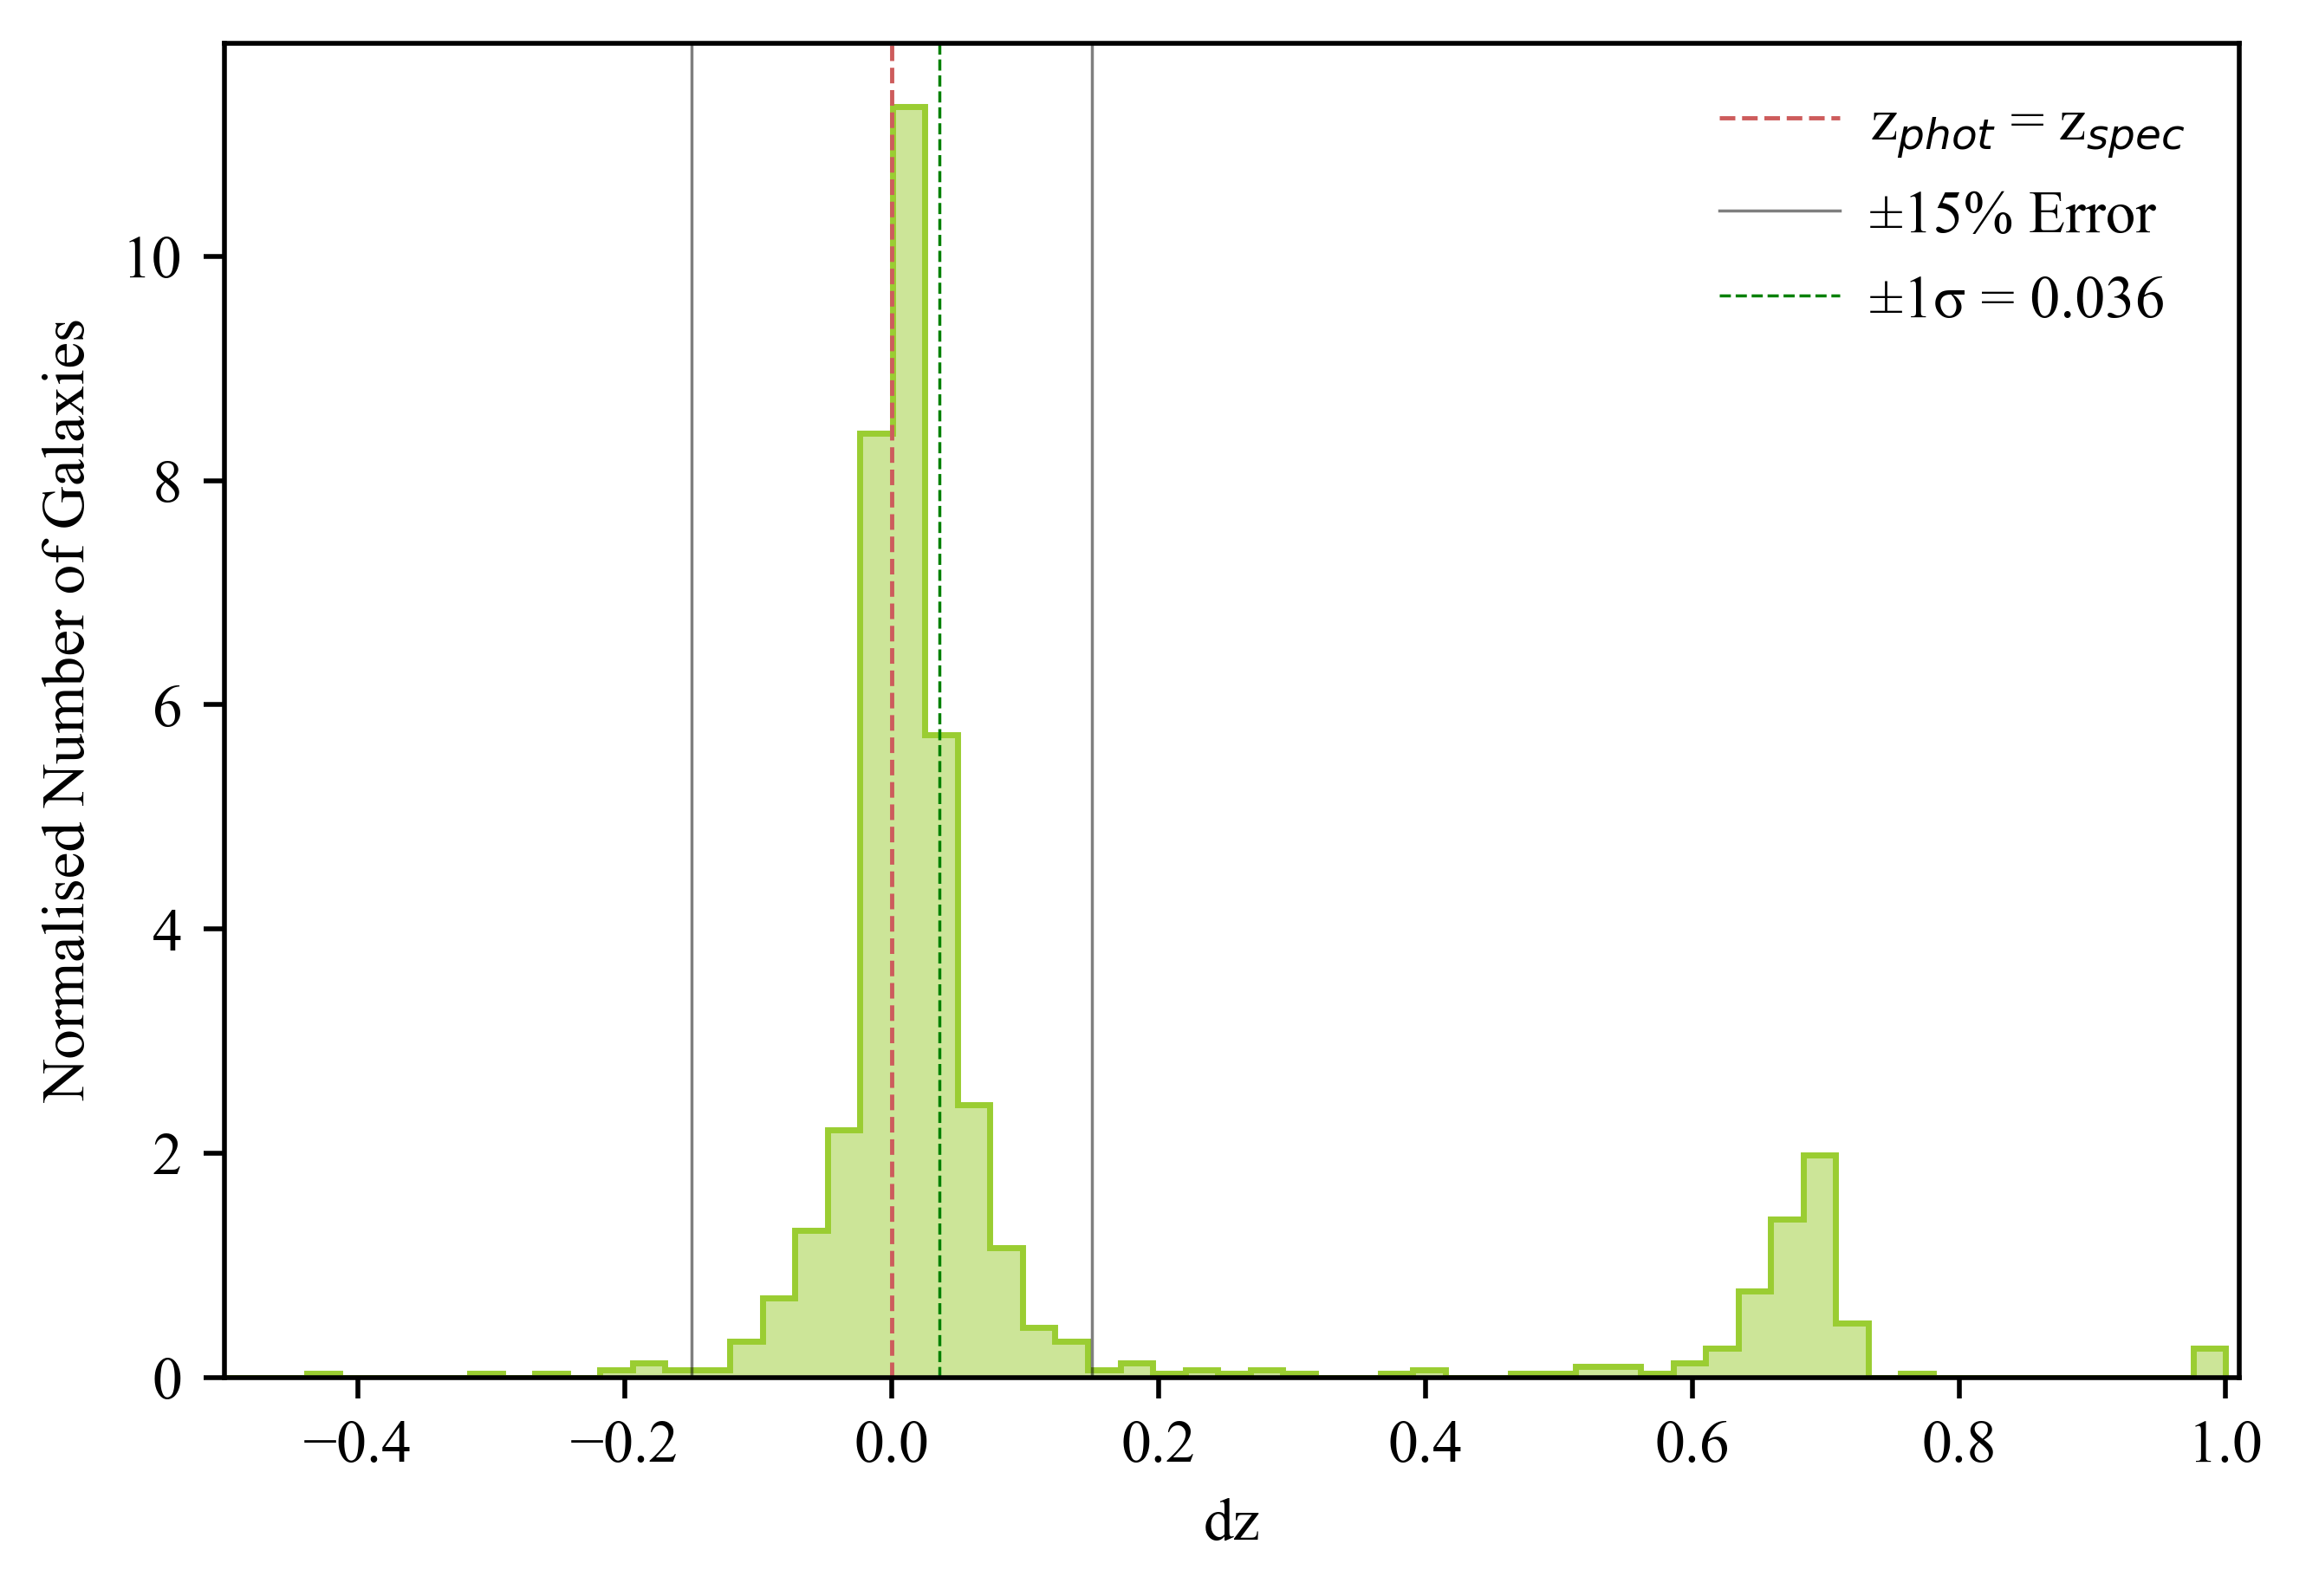

In [12]:
dz = (dat['z_spec'] - dat['z_phot'])/(1 + dat['z_spec'])
BINS = 90
colour = 'yellowgreen'

plt.figure(dpi=500, figsize=(6, 4))

plt.hist(dz, bins=BINS, density=True, histtype='step', color=colour)
plt.hist(dz, bins=BINS, alpha=0.5, density=True, color=colour)

plt.axvline(0, color='indianred', linewidth=0.7, linestyle='--', label='z$_{phot}$ = z$_{spec}$')
plt.axvline(-0.15, color='black', linewidth=0.5, alpha=0.5, label='±15% Error')
plt.axvline(0.15, color='black', linewidth=0.5, alpha=0.5)
plt.axvline(mad(dz), color='green', linewidth=0.5, linestyle='--', label=r'±1σ = {:.3f}'.format(mad(dz)))

plt.xlim(-0.5, 1.01)
plt.xlabel('dz')
plt.ylabel('Normalised Number of Galaxies')

plt.legend(frameon=False, handletextpad=0.5)
plt.show()

plt.scatter(data_cat['z_phot'], (data_cat['z_phot']-data_cat['z_spec'])/(1+data_cat['z_spec']), s=0.5, color='black', alpha=0.6)
plt.scatter(ross_cat['z_phot'], (ross_cat['z_phot']-ross_cat['z_spec'])/(1+ross_cat['z_spec']), s=0.5, color='indianred', alpha=0.6, label='Ross')

plt.xlabel('Photometric Redshift (z)')
plt.ylabel('Residuals')
plt.title('Residuals')

plt.ylim(-0.75, 0.75)
plt.xlim(0, )
plt.show()

In [13]:
for file in os.listdir(os.path.join(homedir, "Filter_files")):
    if file.endswith('.dat'):
        print(file)

HST_ACS_WFC.F435W.dat
HST_ACS_WFC.F606W.dat
HST_ACS_WFC.F775W.dat
HST_ACS_WFC.F814W.dat
HST_ACS_WFC.F850LP.dat
JWST_NIRCam.F090W.dat
JWST_NIRCam.F115W.dat
JWST_NIRCam.F150W.dat
JWST_NIRCam.F182M.dat
JWST_NIRCam.F200W.dat
JWST_NIRCam.F210M.dat
JWST_NIRCam.F277W.dat
JWST_NIRCam.F335M.dat
JWST_NIRCam.F356W.dat
JWST_NIRCam.F410M.dat
JWST_NIRCam.F430M.dat
JWST_NIRCam.F444W.dat
JWST_NIRCam.F460M.dat
JWST_NIRCam.F480M.dat


ross_cat['mag_f335m'] = -2.5 * np.log10(ross_cat['f335m']) + 23.9
ross_cat['mag_f410m'] = -2.5 * np.log10(ross_cat['f410m']) + 23.9
ross_cat['mag_f444w'] = -2.5 * np.log10(ross_cat['f444w']) + 23.9

In [14]:
dat = data_cat[(data_cat['f356w'] > (data_cat['f356w_err'] * 5))]

In [15]:
data_cat

id       RA_1      Dec_1    x-position    y-position     f090w  \
0          0  53.170847 -27.846690  11900.596423   3016.091202  0.034247   
1          1  53.171597 -27.846238  11821.012876   3070.296079  0.018574   
2          2  53.170415 -27.846126  11946.465761   3083.765373  0.002529   
3          3  53.168789 -27.845896  12119.017701   3111.370567  0.003378   
4          4  53.168823 -27.845868  12115.399200   3114.803996  0.006550   
...      ...        ...        ...           ...           ...       ...   
17789  17789  53.157937 -27.725109  13266.252216  17606.266148  0.057552   
17790  17790  53.158642 -27.724727  13191.411099  17652.079302  0.003492   
17791  17791  53.158817 -27.724722  13172.808502  17652.660986  0.003645   
17792  17792  53.157558 -27.724730  13306.517042  17651.699134  0.044080   
17793  17793  53.157963 -27.724665  13263.507302  17659.551524  0.011509   

          f115w     f150w     f200w     f277w  ...  EWs_phot_335  \
0      0.035360  0.035707  0.039747  0.040840  ...   1565.458513   
1      0.022875  0.022863  0.022598  0.020276  ...   1721.850188   
2      0.004552  0.004514  0.006606  0.004867  ...   1797.798992   
3      0.003567  0.004869  0.004720  0.005317  ...   1192.522714   
4      0.006356  0.007468  0.009399  0.009168  ...   2126.412368   
...         ...       ...       ...       ...  ...           ...   
17789  0.068466  0.094280  0.170354  0.190848  ...    907.496980   
17790  0.004229  0.004360  0.005270  0.006887  ...   2234.589387   
17791  0.002492  0.006766  0.006110  0.007041  ...    838.578412   
17792  0.046351  0.058909  0.073827  0.044656  ...   3095.795430   
17793  0.011476  0.013079  0.025176  0.015335  ...    927.425242   

       EWs_spec_335  mag_f090w  mag_f150w  mag_f115w  mag_f200w  del_mag_5  \
0               NaN  27.563458  27.518123  27.528719  27.401751   0.045336   
1               NaN  28.227742  28.002169  28.001612  28.014841   0.225573   
2               NaN  30.392511  29.763502  29.754530  29.350166   0.629008   
3               NaN  30.078195  29.681477  30.019282  29.715117   0.396718   
4               NaN  29.359474  29.217002  29.392035  28.967297   0.142472   
...             ...        ...        ...        ...        ...        ...   
17789           NaN  26.999847  26.463950  26.811319  25.821617   0.535897   
17790           NaN  30.042245  29.801286  29.834455  29.595416   0.240960   
17791           NaN  29.995727  29.324121  30.408713  29.434931   0.671606   
17792           NaN  27.289396  26.974539  27.234853  26.729464   0.314857   
17793           NaN  28.747438  28.608546  28.750550  27.897540   0.138891   

       del_mag_7    beta_5    beta_7  
0       0.126968 -1.917146 -1.784664  
1      -0.013228 -1.587747 -2.022435  
2       0.404364 -0.850437 -1.314203  
3       0.304165 -1.274966 -1.484139  
4       0.424738 -1.739620 -1.279648  
...          ...       ...       ...  
17789   0.989703 -1.020604 -0.321474  
17790   0.239040 -1.559626 -1.594591  
17791   0.973782 -0.772586 -0.348475  
17792   0.505389 -1.424573 -1.142865  
17793   0.853010 -1.746165 -0.553304  

[17794 rows x 59 columns]

dat = data_cat_full[np.logical_and(SIGMACUT_full, MAGCUT_full)]
dat = dat[(dat['z_spec'] >= 0)]

plt.figure(dpi=500, figsize=(8, 3))
# plt.errorbar(dat['z_phot'], dat['diff_mag'], 
#              xerr=abs(dat['z_err']), color='black', 
#              alpha=0.5, elinewidth=0.5, capsize=1, capthick=0.5, linewidth=0)
plt.scatter(dat['z_phot'], dat['diff_mag'], s=0.5, c='black', alpha=0.8, label='Photometric')
plt.scatter(dat['z_spec'], dat['diff_mag'], s=0.5, c='mediumpurple', alpha=0.2, label='Spectroscopic')

plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

plt.axvline(x=3.8, color='mediumseagreen', linestyle='--', linewidth=0.6, alpha=0.9)
plt.axvline(x=4.6, color='mediumseagreen', linestyle='--', linewidth=0.6, alpha=0.9)

plt.axvline(x=5.35, color='red', linestyle='--', linewidth=0.6, alpha=0.8)
plt.axvline(x=6.25, color='red', linestyle='--', linewidth=0.6, alpha=0.8)

plt.xlabel('Photometric Redshift (z)')
plt.ylabel('Difference in Magnitude [mJy]') # ΔMag (F410M - F335M)

leg = plt.legend(frameon=False, columnspacing=0.8, handlelength=-0.5, markerscale=1.5)
for lh in leg.legend_handles:
    lh.set_alpha(0.8)

plt.xlim(0, )
# Format of the x-axis should be intergers
#plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:g}'.format(x)))
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
plt.grid(True, alpha=0.1)

# cbar = plt.colorbar(scatter)
# cbar.set_label('Chi²')
# cbar.set_alpha(0.7)
# scatter.set_clim(10, 40)

# cbar_mod = plt.colorbar(scatter_mod)
# cbar_mod.set_label('χ²')
# cbar_mod.set_alpha(0.7)
# scatter_mod.set_clim(10, 40)

plt.show()

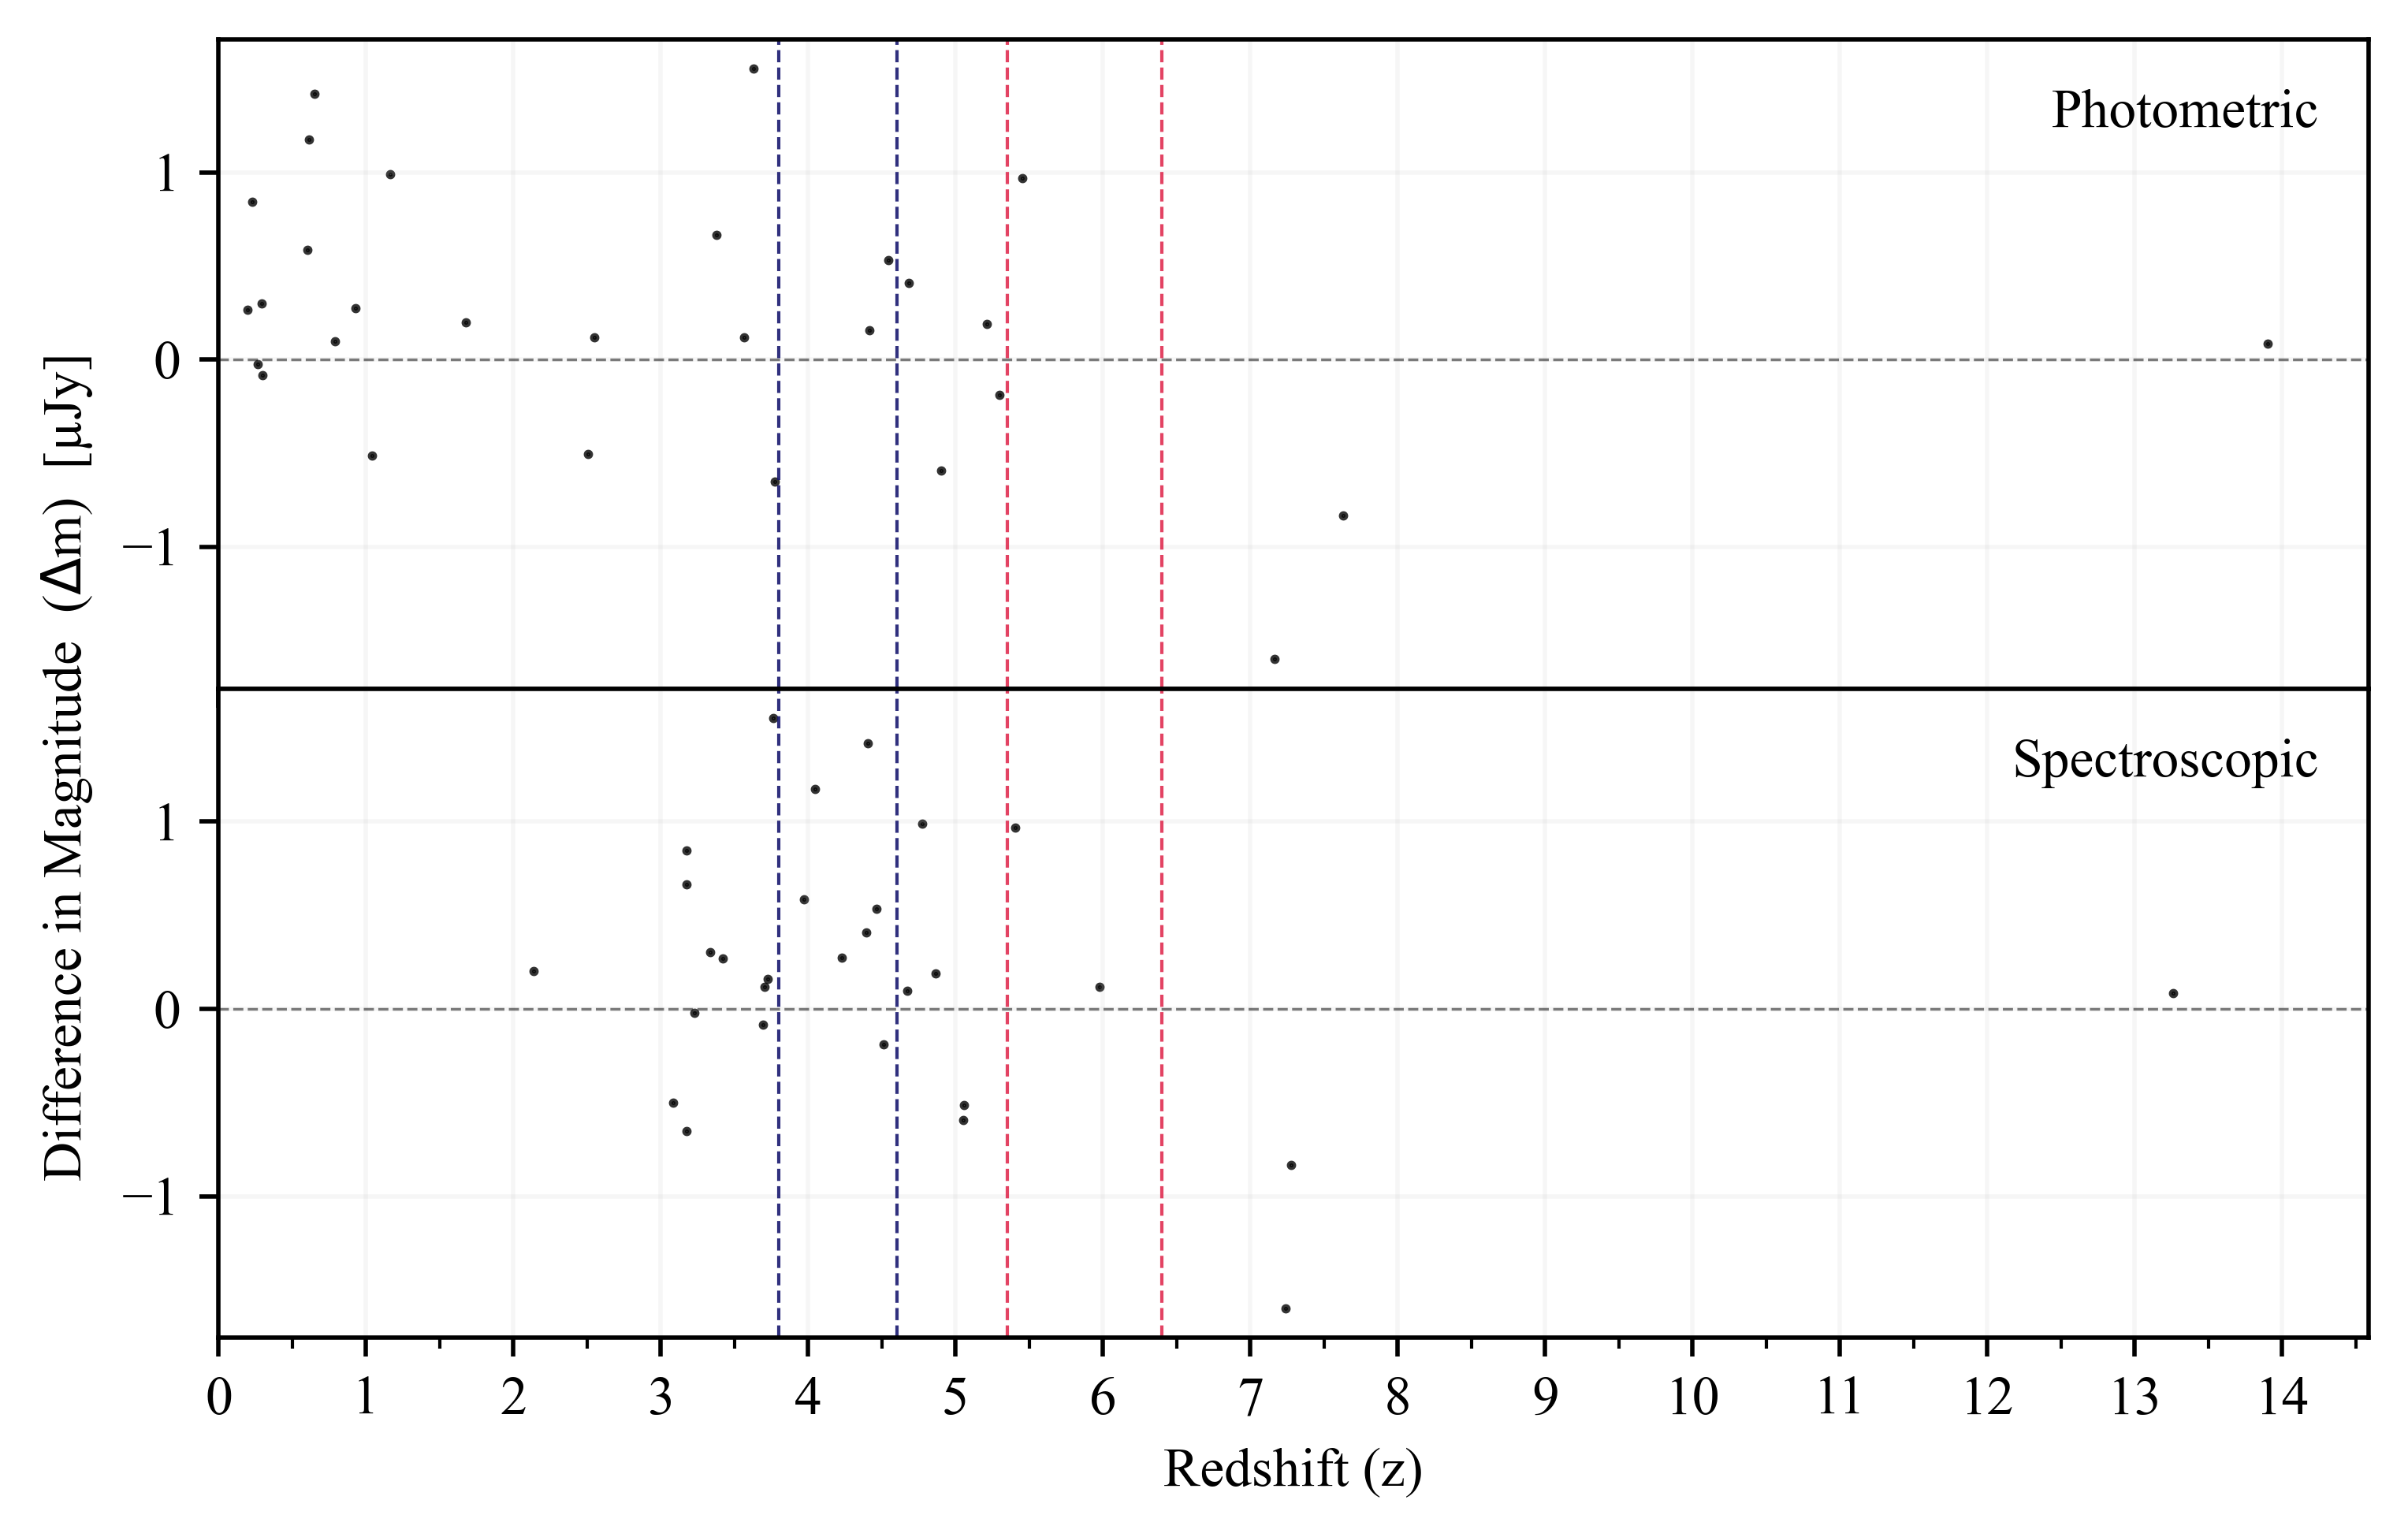

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming data_cat_full, SIGMACUT_full, MAGCUT_full are defined

# Assuming 'diff_mag', 'z_phot', 'z_spec', 'z_err' are columns in dat

fig = plt.figure(figsize=(6,4), dpi=500)
gs = fig.add_gridspec(2, hspace=0) 
axs = gs.subplots(sharex=True, sharey=True)


dat = data_cat_full[np.logical_and(SIGMACUT_full, MAGCUT_full)]
dat = dat[(dat['z_spec'] >= 0)]

# Plot for Photometric Redshift
axs[0].scatter(dat['z_phot'], dat['diff_mag'], s=0.5, c='black', alpha=0.8, label='Photometric')
axs[0].axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
axs[0].axvline(x=3.8, color='midnightblue', linestyle='--', linewidth=0.6, alpha=0.9)
axs[0].axvline(x=4.6, color='midnightblue', linestyle='--', linewidth=0.6, alpha=0.9)
axs[0].axvline(x=5.35, color='crimson', linestyle='--', linewidth=0.6, alpha=0.8)
axs[0].axvline(x=6.4, color='crimson', linestyle='--', linewidth=0.6, alpha=0.8)
axs[0].legend(frameon=False, columnspacing=0.8, handlelength=-0.5, markerscale=0)
axs[0].grid(True, alpha=0.1)

# Plot for Spectroscopic Redshift
axs[1].scatter(dat['z_spec'], dat['diff_mag'], s=0.5, c='black', alpha=0.8, label='Spectroscopic')
axs[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
axs[1].axvline(x=3.8, color='midnightblue', linestyle='--', linewidth=0.6, alpha=0.9)
axs[1].axvline(x=4.6, color='midnightblue', linestyle='--', linewidth=0.6, alpha=0.9)
axs[1].axvline(x=5.35, color='crimson', linestyle='--', linewidth=0.6, alpha=0.8)
axs[1].axvline(x=6.4, color='crimson', linestyle='--', linewidth=0.6, alpha=0.8)
axs[1].legend(frameon=False, columnspacing=0.8, handlelength=-0.5, markerscale=0)

plt.xlim(0, )
# Format of the x-axis should be integers
axs[1].xaxis.set_major_locator(mtick.MultipleLocator(1))
axs[1].xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
axs[1].grid(True, alpha=0.1)

fig.text(-0.01, 0.5, 'Difference in Magnitude  ($\Delta$m)  [µJy]', va='center', rotation='vertical')
plt.xlabel("Redshift (z)")
plt.tight_layout()
plt.show()


plt.figure(dpi=500, figsize=(8, 3))

#scatter = plt.scatter(data_cat['z_phot'], data_cat['mag_f410m'] - data_cat['mag_f335m'], s=1, c=data_cat['chi2_best'], cmap='gist_rainbow', alpha=0.5)
#plt.errorbar(data_cat['z_phot'], data_cat['mag_f410m'] - data_cat['mag_f335m'], xerr=data_cat['z_phot_err'], yerr=data_cat['mag_f410m_err'] - data_cat['mag_f335m_err'], fmt='none', ecolor='black', alpha=0.1, elinewidth=0.5, capsize=0.5)
plt.scatter(ross_cat['z_spec'], ross_cat['mag_f410m'] - ross_cat['mag_f335m'], s=0.5, c='mediumpurple', alpha=0.5, label='Ross')
plt.scatter(data_mod_cat['z_spec'], data_mod_cat['mag_f410m'] - data_mod_cat['mag_f335m'], s=0.5, c='black', alpha=1)

plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(x=3.8, color='blue', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(x=4.6, color='blue', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(x=5.3, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axvline(x=6.4, color='red', linestyle='--', linewidth=0.5, alpha=0.5)

plt.xlabel('Spectroscopic Redshift')
plt.ylabel('ΔMag (F410M - F335M)')

leg = plt.legend()
for lh in leg.legend_handles:
    lh.set_alpha(0.5)
plt.xlim(0, )
# Format of the x-axis should be intergers
#plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:g}'.format(x)))
#plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(2))

# cbar = plt.colorbar(scatter)
# cbar.set_label('Chi²')
# cbar.set_alpha(0.7)
# scatter.set_clim(10, 40)

# cbar_mod = plt.colorbar(scatter_mod)
# cbar_mod.set_label('χ²')
# cbar_mod.set_alpha(0.7)
# scatter_mod.set_clim(10, 40)

plt.show()

In [17]:
def get_hist_info(data, NBINS):
    # Derive the appropriate numbers in the data
    # Here shifting x values to the center of the bins and
    # getting the height of the bin for y values

    """
    Returns:
    --------
    bins : array
        The x values of the histogram
    n : array
        The y values of the histogram
    """
    
    n, bins = np.histogram(data, bins=NBINS)
    bins = [(bins[i] + bins[i+1])/2. for i in range(len(bins)-1)]
    bins = np.array(bins)
    n = np.array(n)
    
    return bins, n

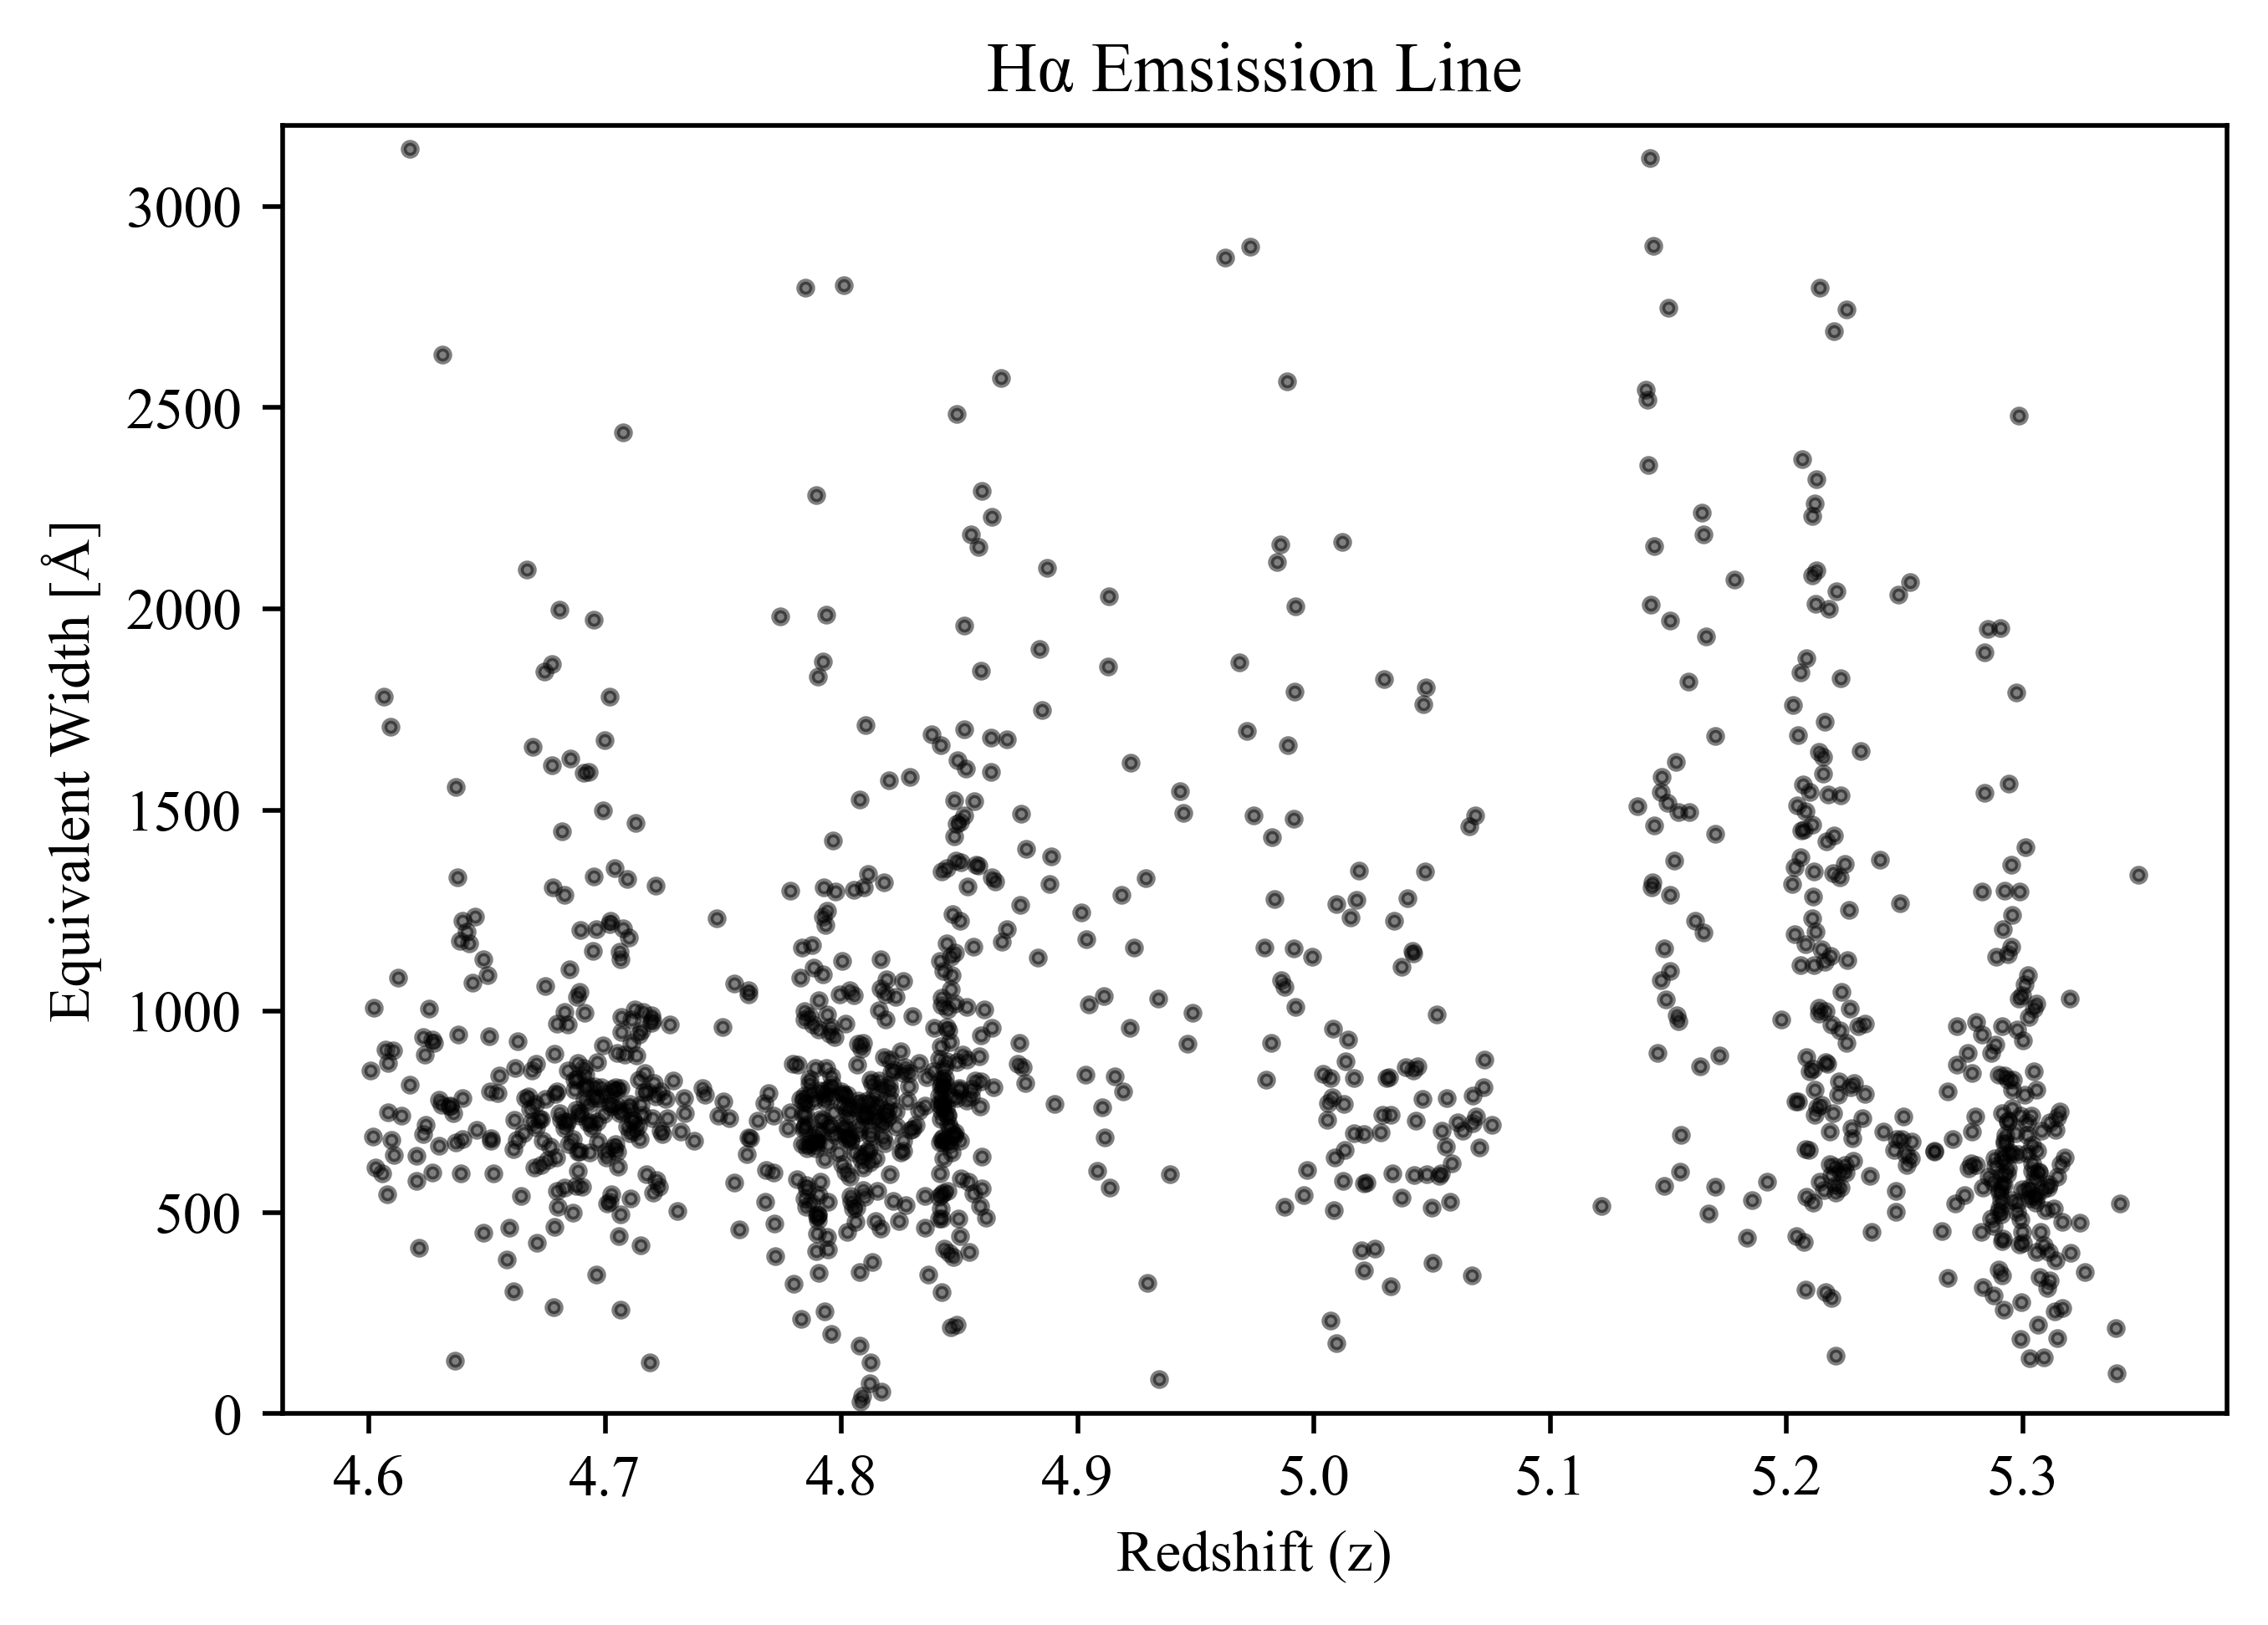

In [18]:
dat = data_cat_full[np.logical_and(HA_410_full, SIGMACUT_full, MAGCUT_full)]

plt.figure(dpi=500, figsize=(6, 4))
plt.scatter(dat['z_phot'], dat['EWs_phot_410'], alpha=0.5, s=5, color='black')

plt.xlabel('Redshift (z)')
plt.ylabel('Equivalent Width [Å]')
#plt.xlim(4, 6)
plt.ylim(0, 3200)

plt.title('Hα Emsission Line')

# plt.legend(frameon=False, handlelength=-0.5)
# plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(5))
# plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
# plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.show()

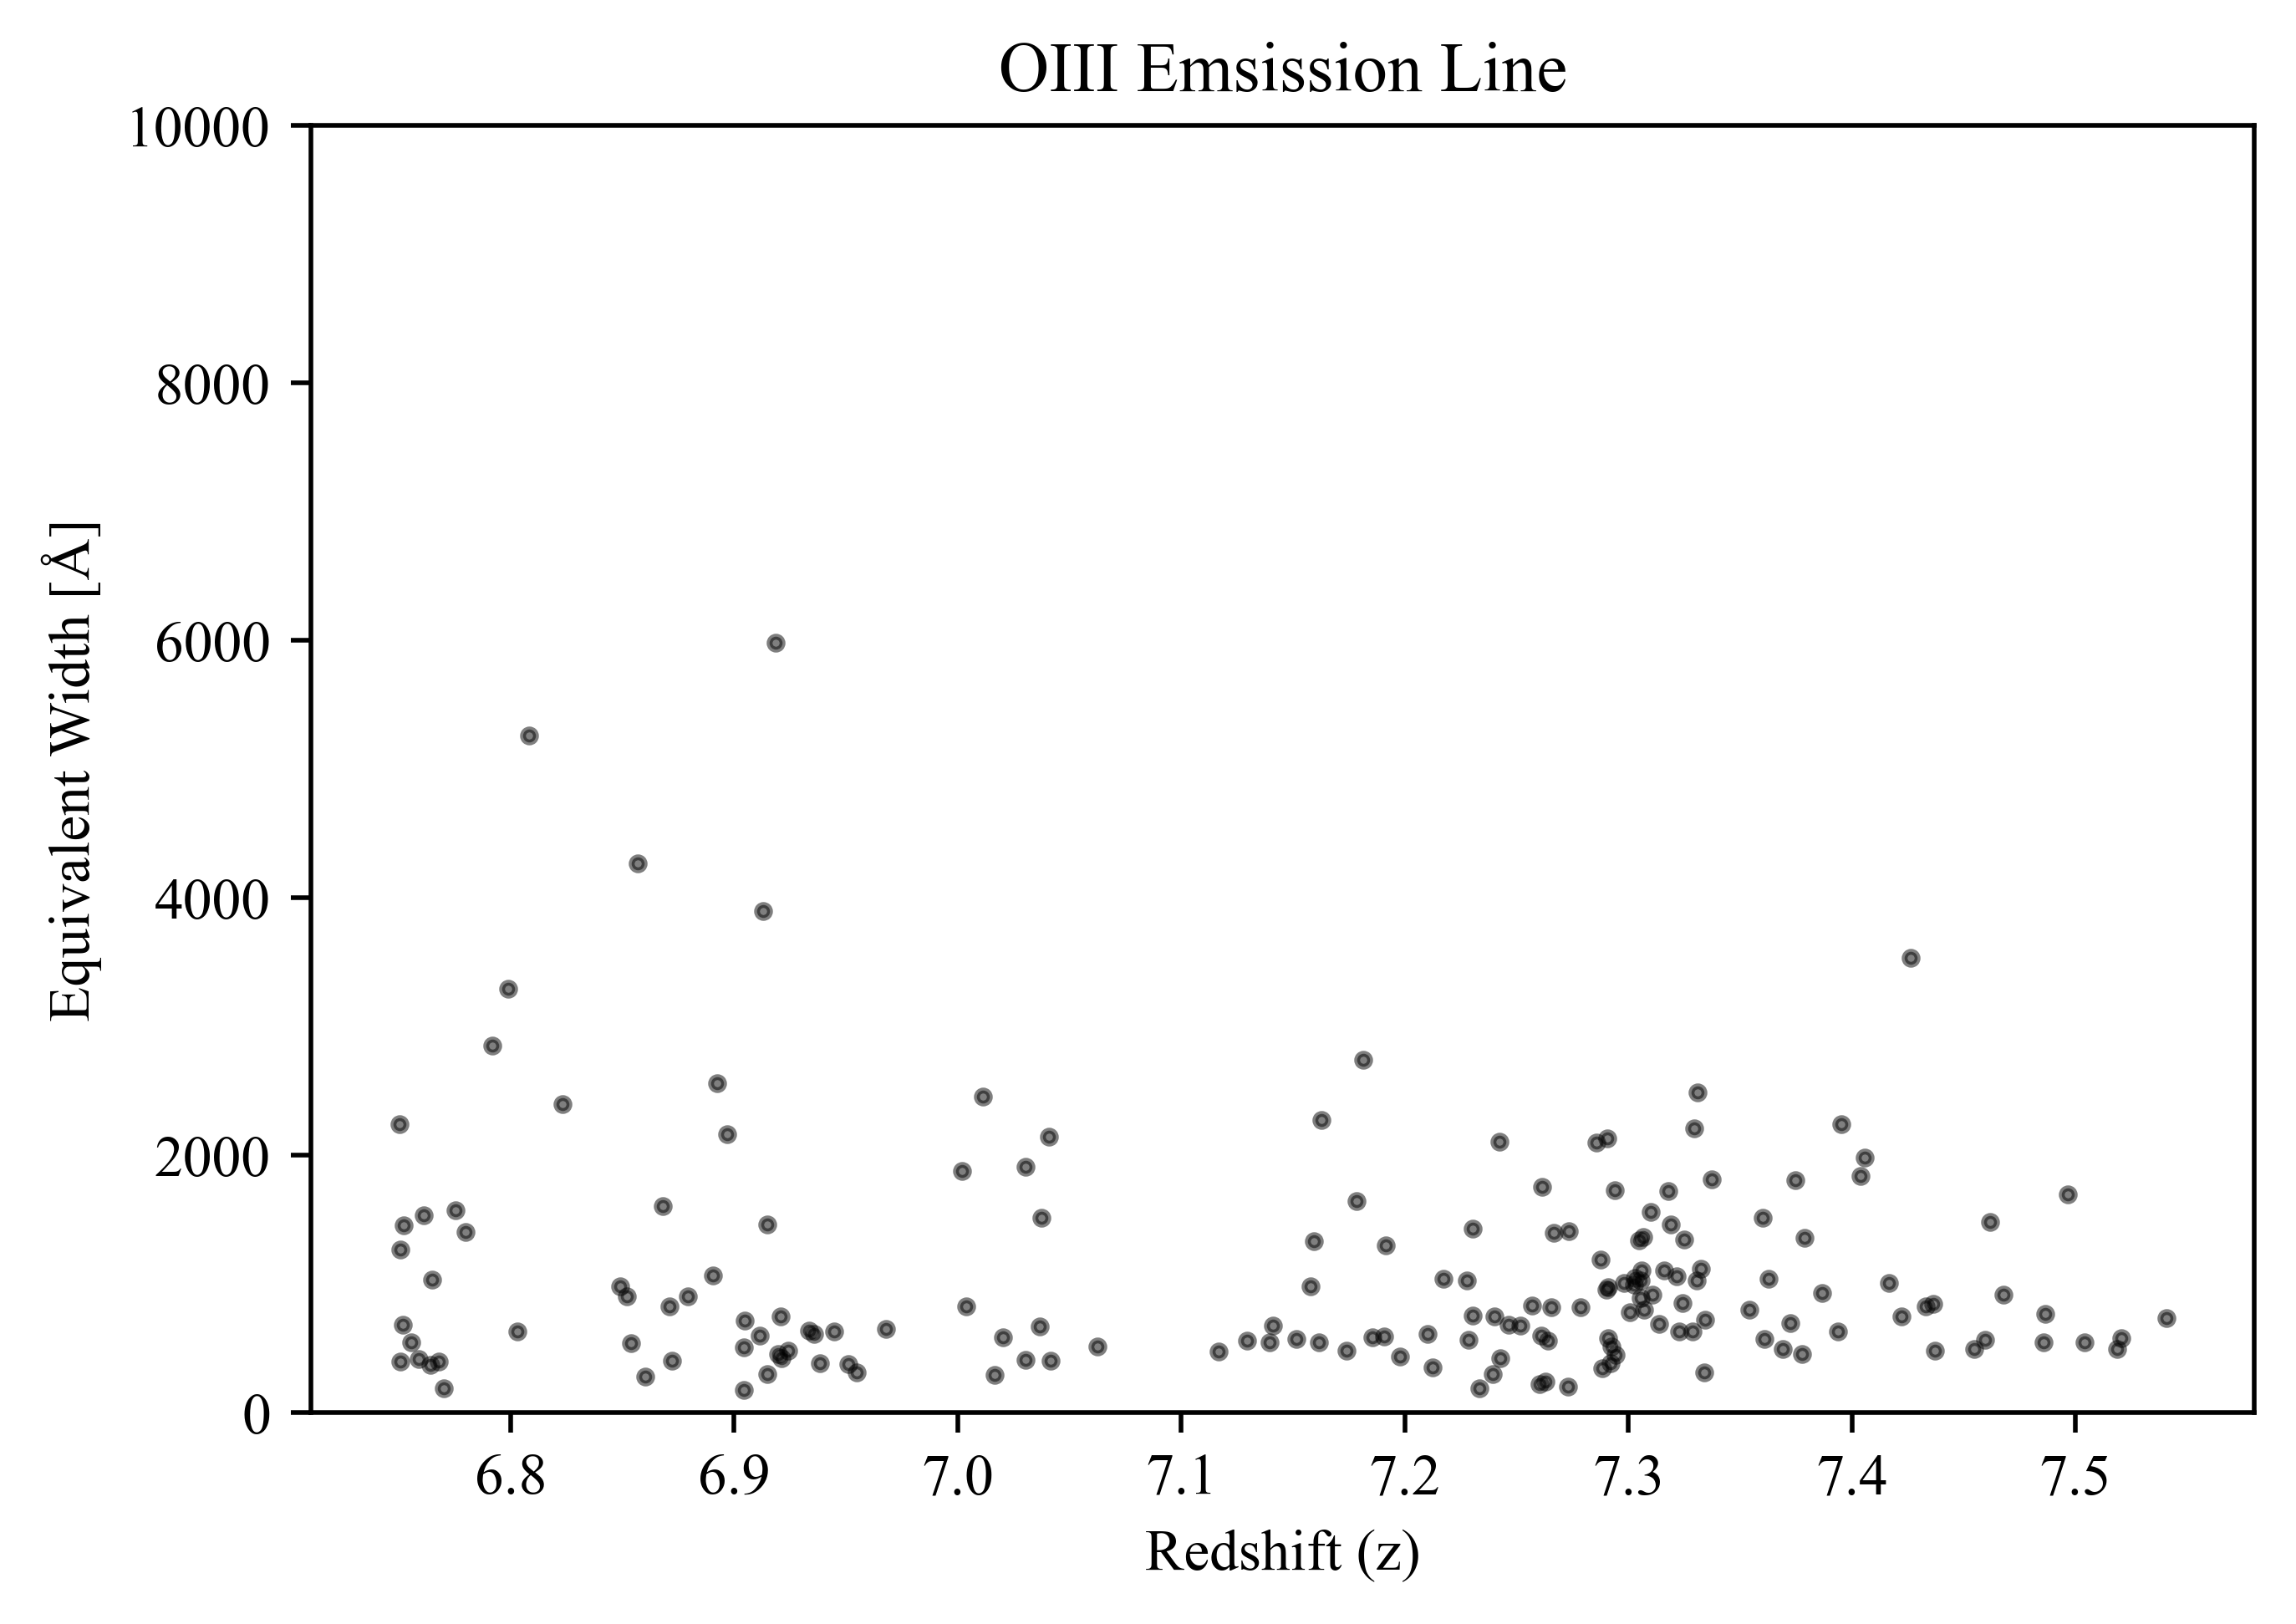

In [19]:
dat = data_cat_full[np.logical_and(OIII_410_full, SIGMACUT_full, MAGCUT_full)]

plt.figure(dpi=500, figsize=(6, 4))
plt.scatter(dat['z_phot'], dat['EWs_phot_410'], alpha=0.5, s=5, color='black')

plt.xlabel('Redshift (z)')
plt.ylabel('Equivalent Width [Å]')
#plt.xlim(4, 6)
plt.ylim(-1, 10000)

plt.title('OIII Emsission Line')

# plt.legend(frameon=False, handlelength=-0.5)
# plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(5))
# plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
# plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.show()

In [20]:
dat = data_cat_full[np.logical_and(HA_410_full, SIGMACUT_full)]
print(len(dat['EWs_phot_410']))

dat = data_cat_full[np.logical_and(HA_410_full, SIGMACUT_full, MAGCUT_full)]
print(len(dat['EWs_phot_410']))

1132
1132


In [21]:
import pandas as pd

# Assuming data_cat_full is a pandas DataFrame
dat1 = data_cat_full[data_cat_full[SIGMACUT_full] & data_cat_full[MAGCUT_full]].copy()
print("Shape of dat1:", dat1.shape)

dat2 = data_cat_full[data_cat_full[HA_410_full] & data_cat_full[SIGMACUT_full] & data_cat_full[MAGCUT_full]].copy()
print("Shape of dat2:", dat2.shape)


TypeError: unsupported operand type(s) for &: 'float' and 'bool'

In [ ]:
# make a deepcopy of the data
dat = data_cat_full.copy()

AttributeError: 'tuple' object has no attribute 'copy'

(0.0, 3200.0)

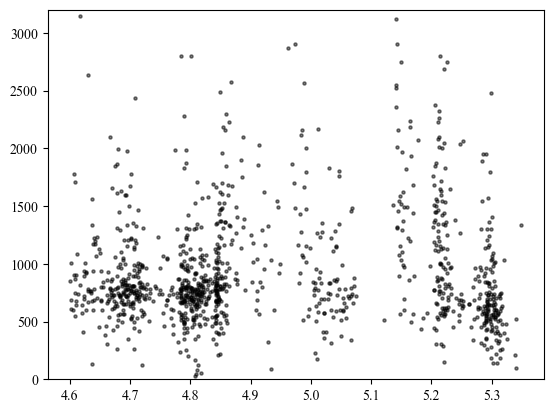

In [ ]:
dat = data_cat_full[np.logical_and(HA_410_full, SIGMACUT_full, MAGCUT_full)]

plt.scatter(dat['z_phot'], dat['EWs_phot_410'], alpha=0.5, s=5, color='black')
plt.ylim(0, 3200)
#plt.xlim(4, 9)

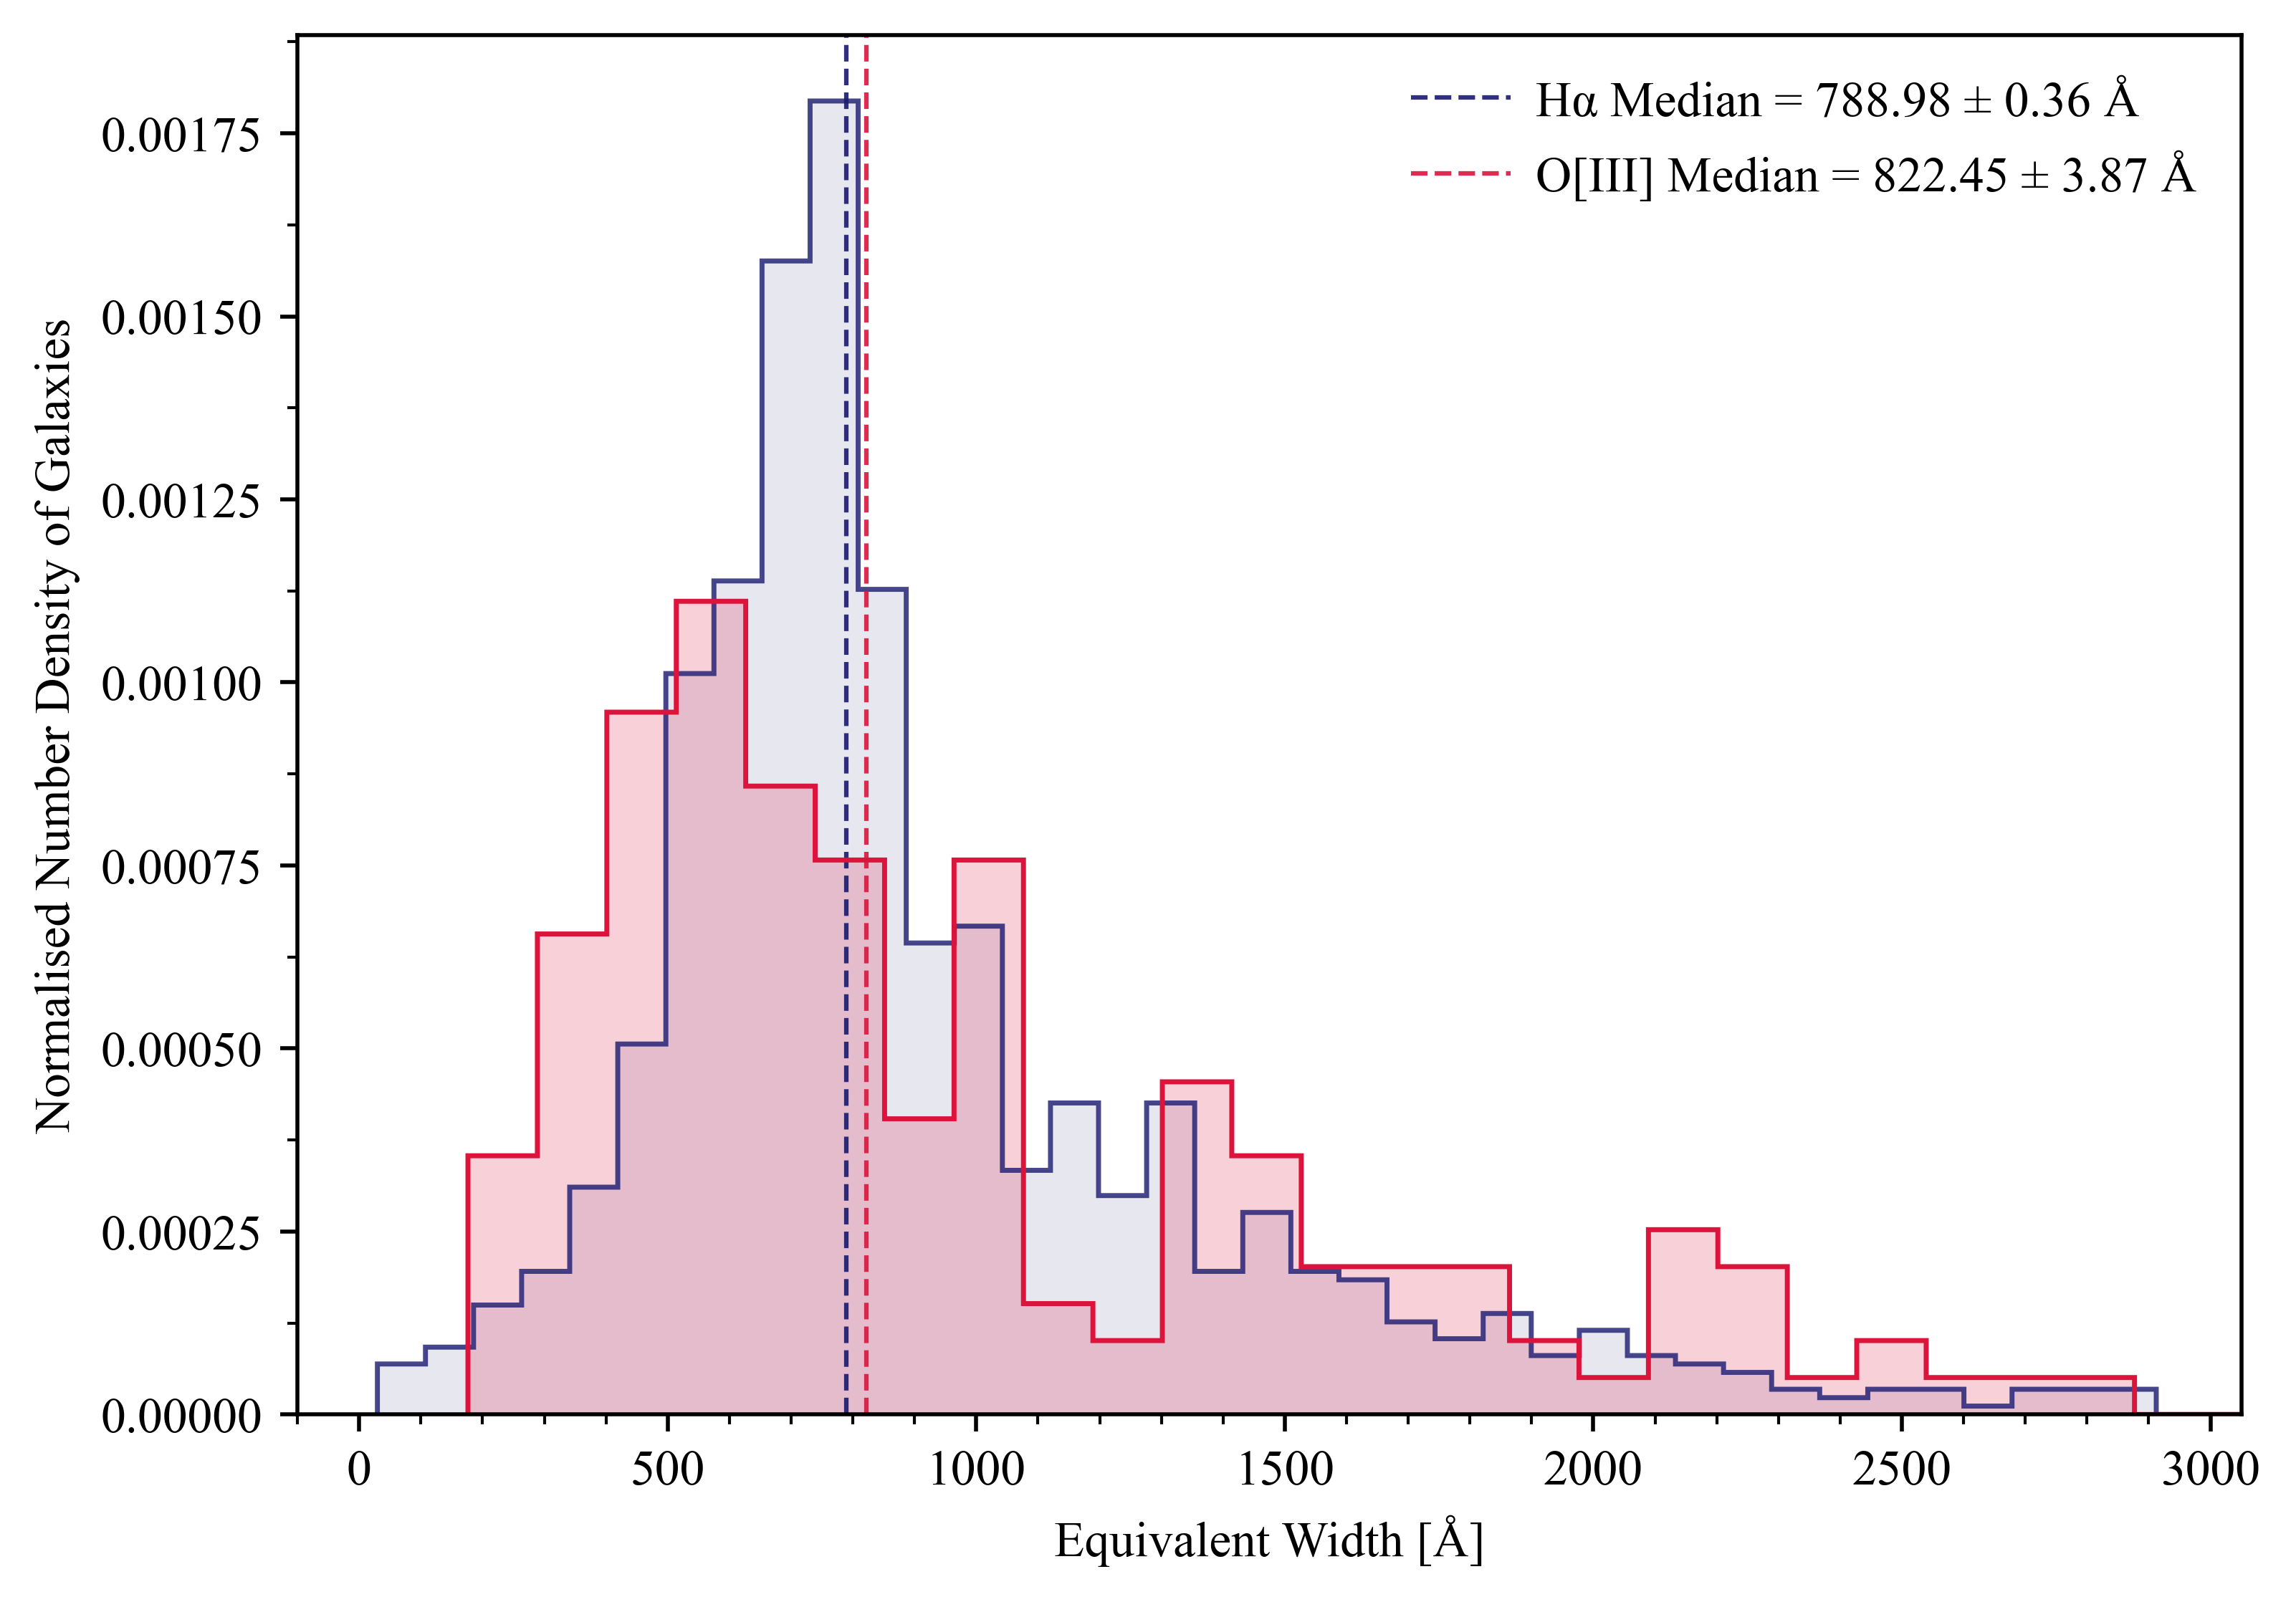

1935.330640421507 788.9840967366226 512.7333892680467


In [35]:
dat = data_cat_full[np.logical_and(HA_410_full, SIGMACUT_full, MAGCUT_full)]

BINS = 1000
EWs_phot = dat['EWs_phot_410']

plt.figure(dpi=500, figsize=(7, 5))
plt.hist(EWs_phot, bins=BINS, color='midnightblue', alpha=0.1, density=True)
plt.hist(EWs_phot, bins=BINS, color='midnightblue', alpha=0.8, histtype='step', density=True)
# find sigma, mean and median of the EWs
# ignore nans
EWs_phot = EWs_phot[~np.isnan(EWs_phot)]
_err = np.percentile(EWs_phot, [16, 50, 84])
err_Ha = (np.average([np.subtract(_err[1], _err[0]), np.subtract(_err[2], _err[1])])/len(EWs_phot))

mean_phot = np.mean(EWs_phot)
median_phot_Ha = np.median(EWs_phot)
sigma_phot = mad(EWs_phot)

# plt.axvline(sigma_phot, color='green', linestyle='--', linewidth=0.8, alpha=0.5, label='±1σ = {:.2f} Å'.format(sigma_phot))
plt.axvline(median_phot_Ha, color='midnightblue', linestyle='--', linewidth=0.9, alpha=0.9, label='Hα Median = {0:.2f} ± {1:.2f} Å'.format(median_phot_Ha, err_Ha))
# plt.axvline(mean_phot, color='black', linestyle='--', linewidth=0.8, alpha=0.5, label='Mean = {:.2f} Å'.format(mean_phot))

dat = data_cat_full[np.logical_and(OIII_410_full, SIGMACUT_full, MAGCUT_full)]
EWs_phot = dat['EWs_phot_410']
plt.hist(EWs_phot, bins=BINS, color='crimson', alpha=0.2, density=True)
plt.hist(EWs_phot, bins=BINS, color='crimson', histtype='step', density=True)
# find sigma, mean and median of the EWs
# ignore nans
EWs_phot = EWs_phot[~np.isnan(EWs_phot)]
_err = np.percentile(EWs_phot, [16, 50, 84])
err_OIII = (np.average([np.subtract(_err[1], _err[0]), np.subtract(_err[2], _err[1])])/len(EWs_phot))

mean_phot = np.mean(EWs_phot)
median_phot_OIII = np.median(EWs_phot)
sigma_phot = mad(EWs_phot)

# plt.axvline(sigma_phot, color='green', linestyle='--', linewidth=0.8, alpha=0.5, label='±1σ = {:.2f} Å'.format(sigma_phot))
plt.axvline(median_phot_OIII, color='crimson', linestyle='--', linewidth=0.9, alpha=0.9, label='O[III] Median = {0:.2f} ± {1:.2f} Å'.format(median_phot_OIII, err_OIII))
# plt.axvline(mean_phot, color='black', linestyle='--', linewidth=0.8, alpha=0.5, label='Mean = {:.2f} Å'.format(mean_phot))

plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.xlim(-100, 3050)
#plt.title('Hα Emsission Line in f410m')
plt.xlabel('Equivalent Width [Å]')
plt.ylabel('Normalised Number Density of Galaxies')
plt.legend(frameon=False, handletextpad=0.5)
plt.show()

print(mean_phot, median_phot_Ha, sigma_phot)

In [36]:
dat = data_cat_full[np.logical_and(OIII_410_full, SIGMACUT_full)]
print(len(dat['EWs_phot_410']))

dat = data_cat_full[np.logical_and(OIII_410_full, SIGMACUT_full, MAGCUT_full)]
print(len(dat['EWs_phot_410']))

187
187


In [37]:
dat = data_cat_full[np.logical_and(OIII_410_full, SIGMACUT_full, MAGCUT_full)]
EWs_phot = dat['EWs_phot_410']

EWs_phot = EWs_phot[~np.isnan(EWs_phot)]
_err = np.percentile(EWs_phot, [16, 50, 84])
err_OIII = (np.average([np.subtract(_err[1], _err[0]), np.subtract(_err[2], _err[1])])/len(EWs_phot))
print(err_OIII)

3.8655076600484177


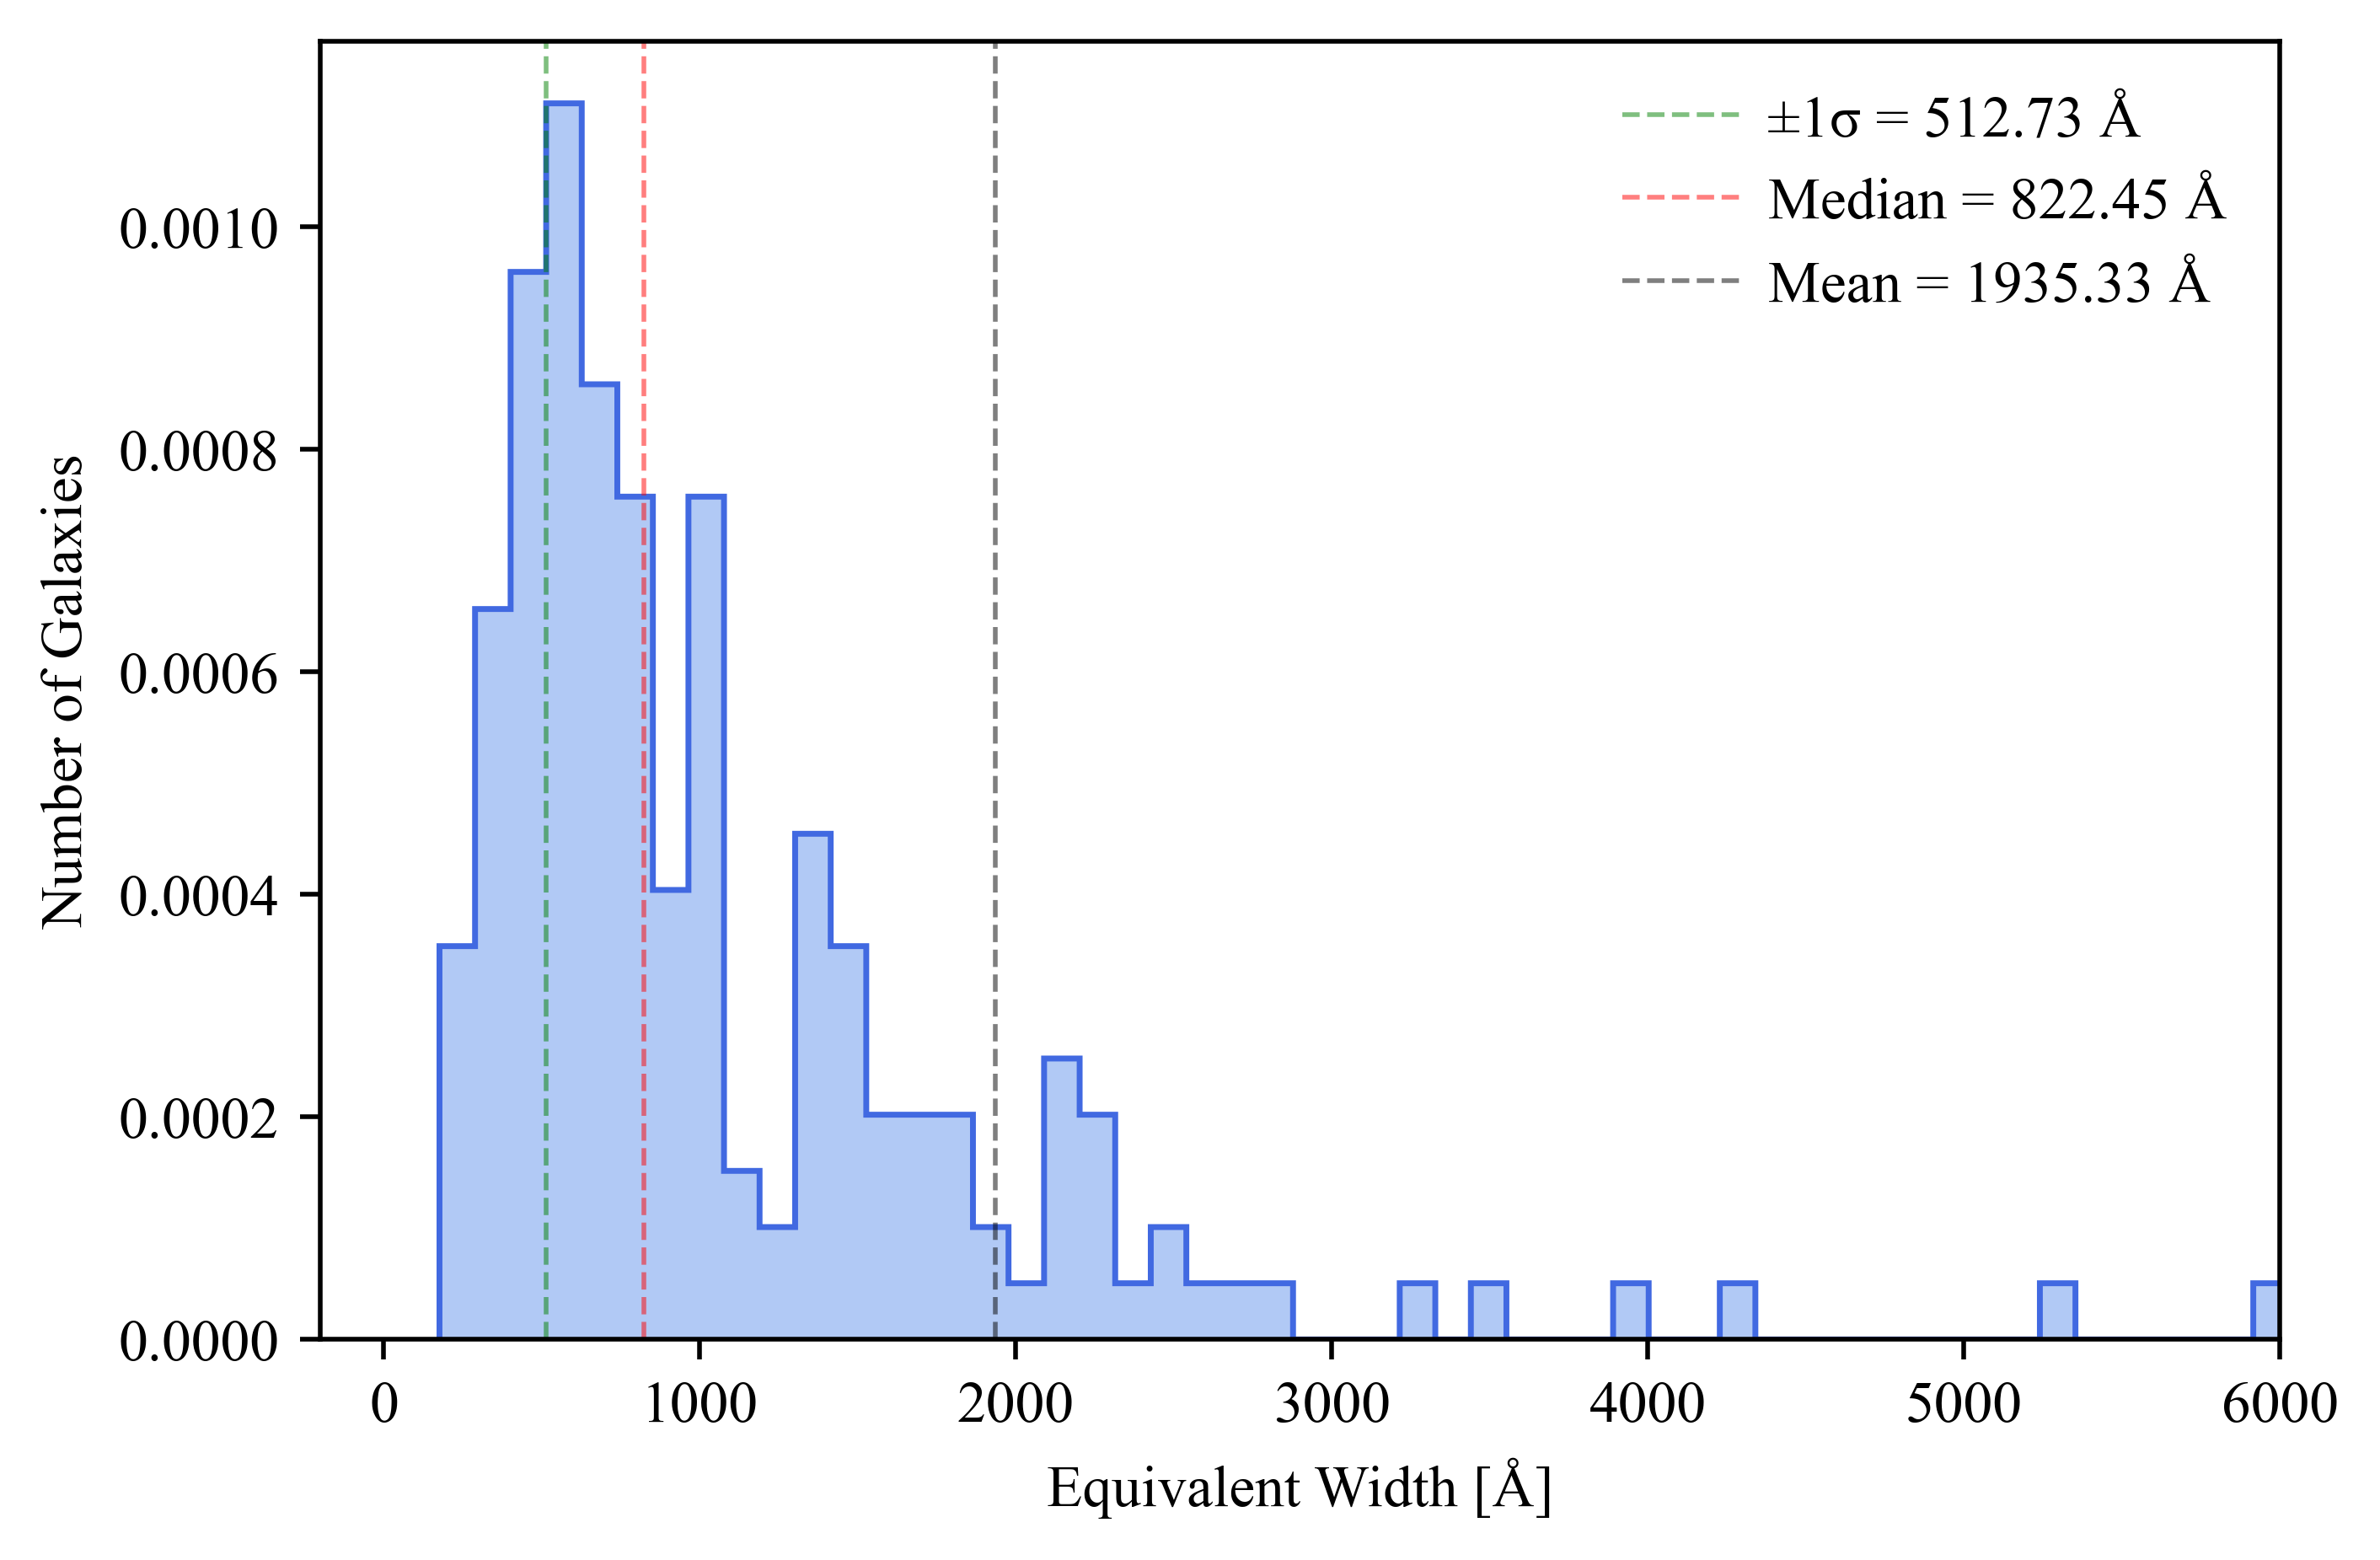

1935.330640421507 822.4474854755883 512.7333892680467


In [38]:
BINS = 1000
dat = data_cat_full[np.logical_and(OIII_410_full, SIGMACUT_full, MAGCUT_full)]
EWs_phot = dat['EWs_phot_410']

plt.figure(dpi=500, figsize=(6, 4))

plt.hist(EWs_phot, bins=BINS, color='cornflowerblue', alpha=0.5, density=True)
plt.hist(EWs_phot, bins=BINS, color='royalblue', histtype='step', density=True)
# find sigma, mean and median of the EWs
# ignore nans
EWs_phot = EWs_phot[~np.isnan(EWs_phot)]
_err = np.percentile(EWs_phot, [16, 50, 84])
err_OIII = (np.average([np.subtract(_err[1], _err[0]), np.subtract(_err[2], _err[1])])/len(EWs_phot))

mean_phot = np.mean(EWs_phot)
median_phot_OIII = np.median(EWs_phot)
sigma_phot = mad(EWs_phot)

plt.axvline(sigma_phot, color='green', linestyle='--', linewidth=0.8, alpha=0.5, label='±1σ = {:.2f} Å'.format(sigma_phot))
plt.axvline(median_phot_OIII, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='Median = {0:.2f} Å'.format(median_phot_OIII))
plt.axvline(mean_phot, color='black', linestyle='--', linewidth=0.8, alpha=0.5, label='Mean = {:.2f} Å'.format(mean_phot))

plt.xlim(-200, 6000)
#plt.title('OIII Emsission Line in f410m')
plt.xlabel('Equivalent Width [Å]')
plt.ylabel('Number of Galaxies')
plt.legend(frameon=False, handletextpad=0.5)
plt.show()

print(mean_phot, median_phot_OIII, sigma_phot)

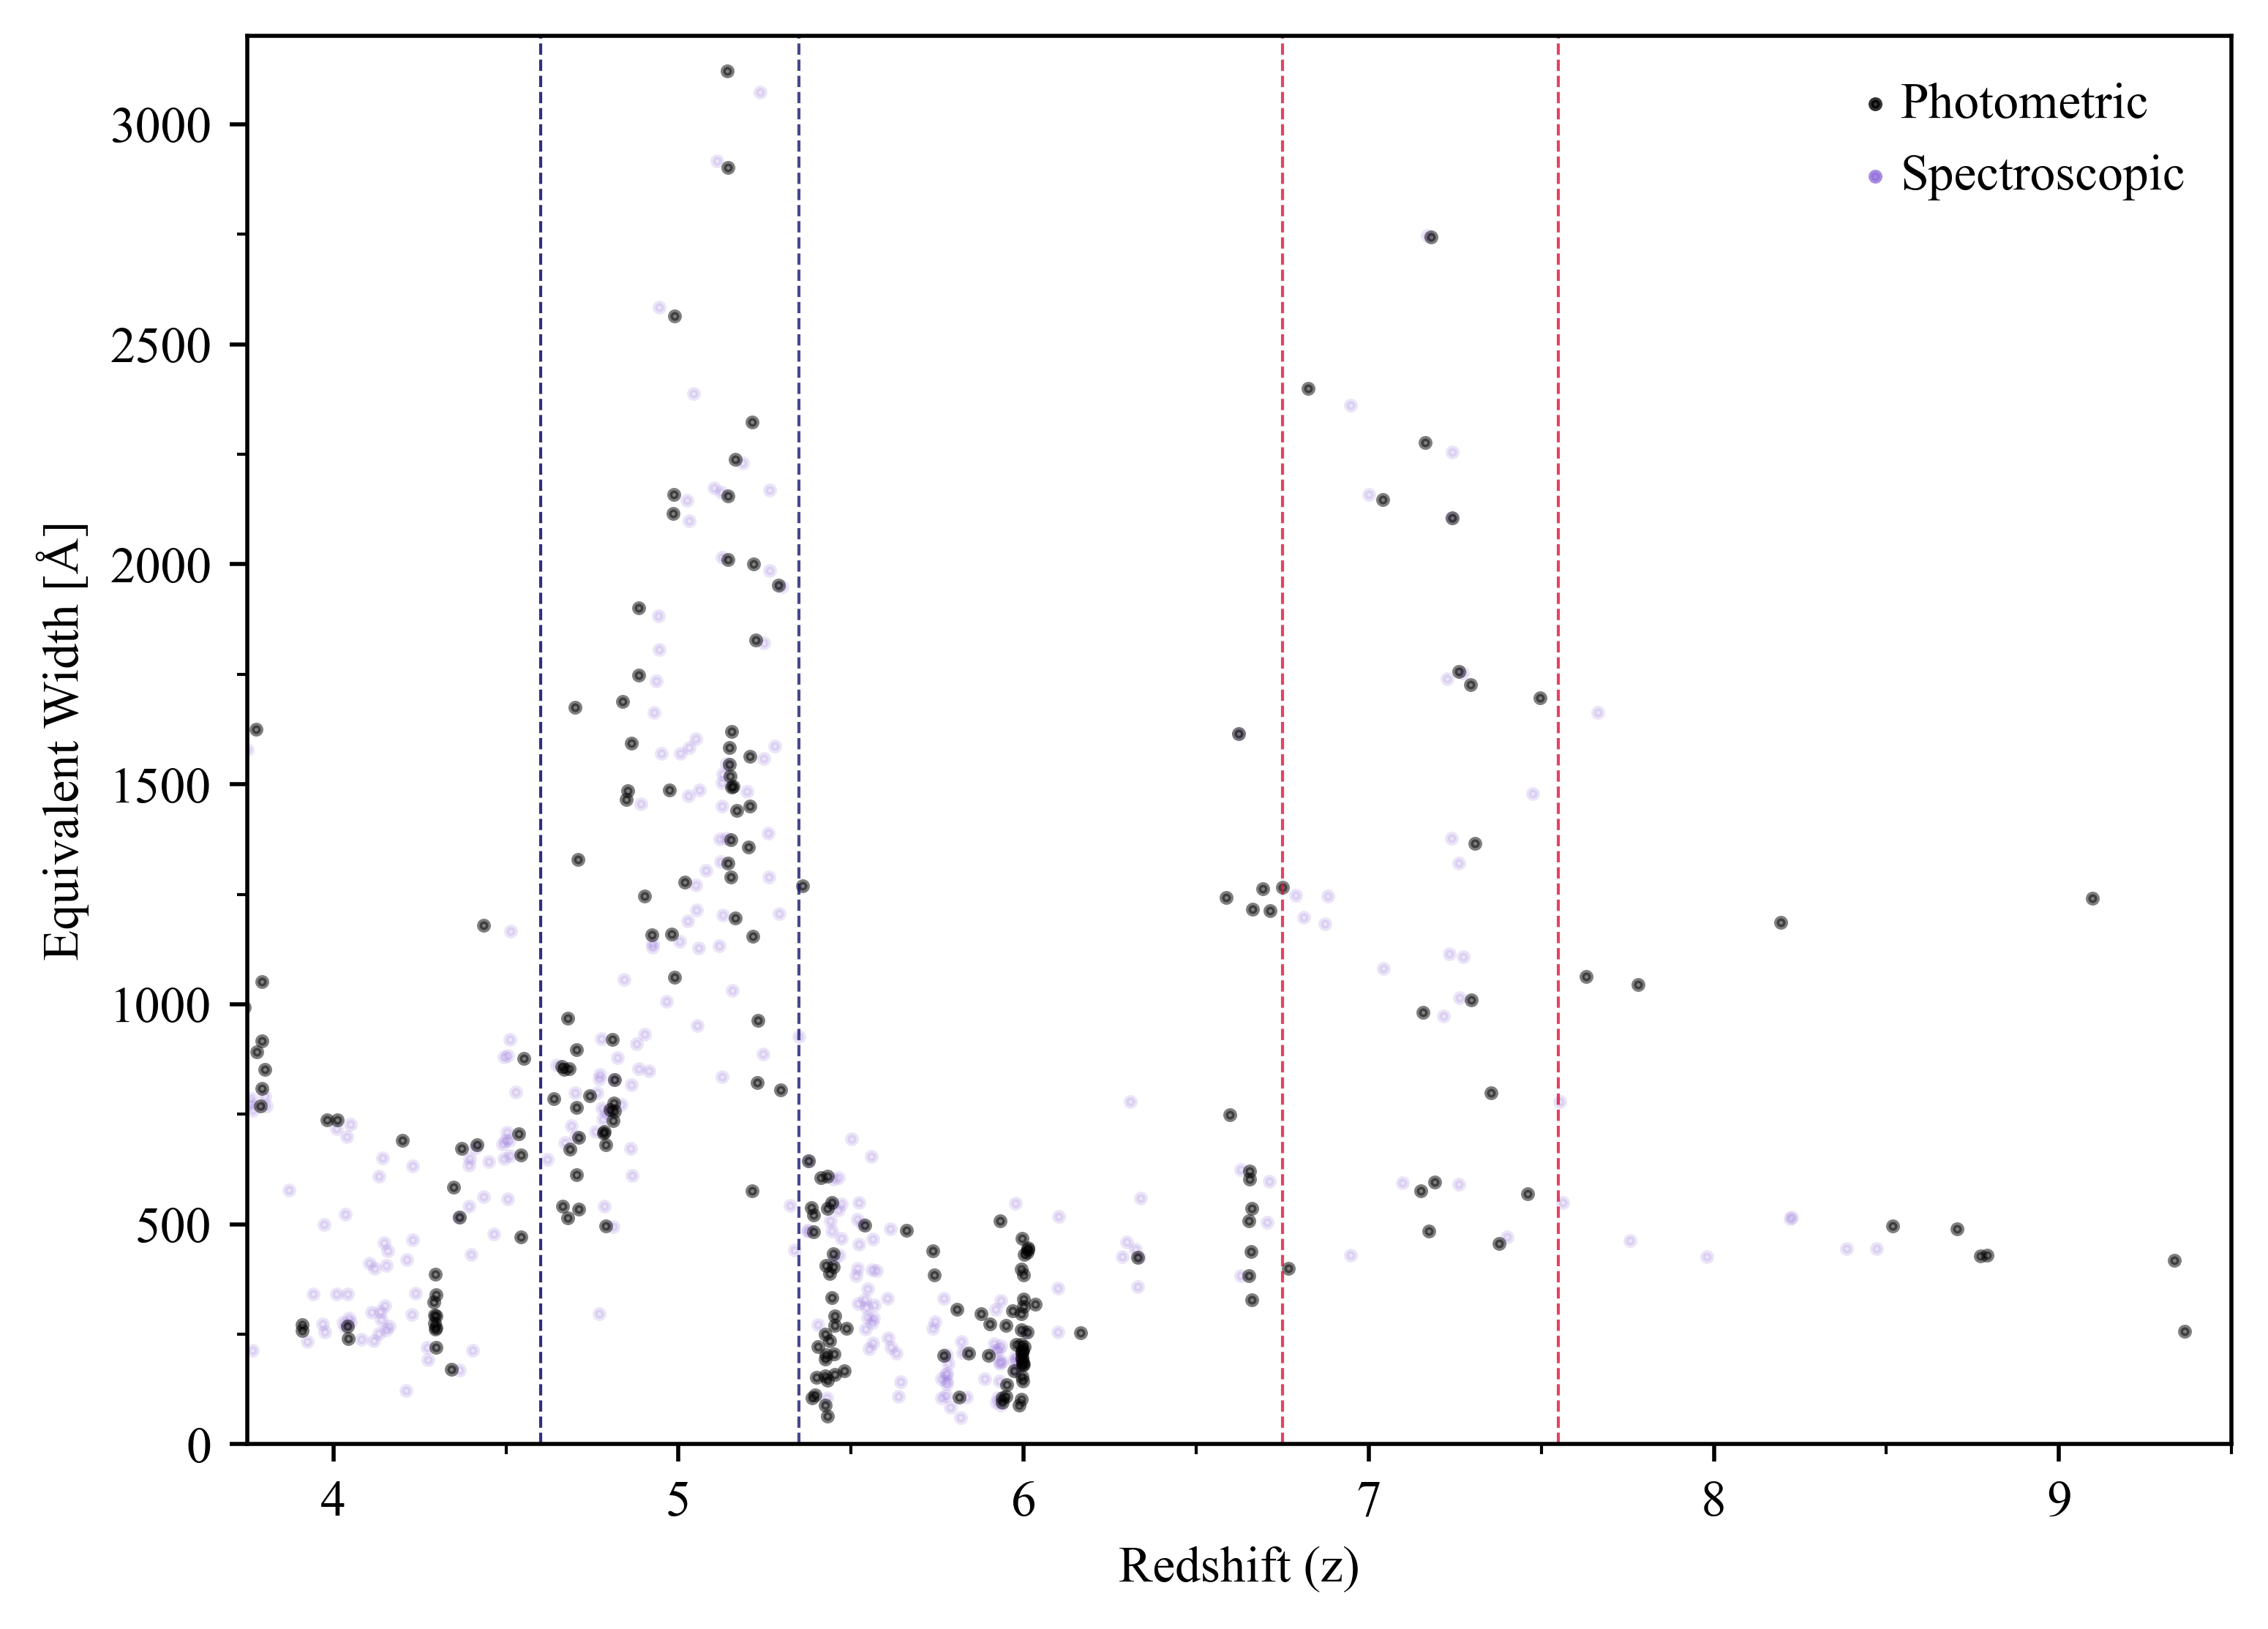

In [39]:
plt.figure(dpi=500, figsize=(7, 5))
dat = data_cat_full[np.logical_and((data_cat_full['z_spec'] > 0), SIGMACUT_full, MAGCUT_full)]

plt.scatter(dat['z_phot'], dat['EWs_phot_410'], alpha=0.5, s=3, label='Photometric', color='black', zorder=2)
plt.scatter(dat['z_spec'], dat['EWs_spec_410'], alpha=0.175, s=3, label='Spectroscopic', color='mediumpurple', zorder=1)
plt.xlabel('Redshift (z)')
plt.ylabel('Equivalent Width [Å]')
plt.xlim(0, 10)
plt.ylim(0, 3200)

plt.axvline(4.6, color='midnightblue', linestyle='--', linewidth=0.6, alpha=0.9)
plt.axvline(5.35, color='midnightblue', linestyle='--', linewidth=0.6, alpha=0.8)

plt.axvline(6.75, color='crimson', linestyle='--', linewidth=0.6, alpha=0.8)
plt.axvline(7.55, color='crimson', linestyle='--', linewidth=0.6, alpha=0.8)

leg = plt.legend(frameon=False, handletextpad=-0.5)
for lh in leg.legend_handles:
    lh.set_alpha(0.8)

plt.xlim(3.75, 9.5)
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.show()

plt.figure(dpi=500, figsize=(5, 5))
#plt.scatter(data_cat['z_phot'], data_cat['chi2_best'], s=0.5, color='black', alpha=0.6)
plt.scatter(data_mod_cat['z_phot'], data_mod_cat['chi2_best'], s=0.5, color='black', alpha=0.6, label='Modified')
plt.xlabel('Photometric Redshift (z)')
plt.ylabel('Chi²')
leg = plt.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)

plt.xscale('symlog')
plt.xlim(0, )
plt.ylim(0, 600)
plt.show()

In [40]:
data_mod_cat.iloc[0, 5:19]

f090w     0.006618
f115w      0.01299
f150w     0.014152
f200w     0.011931
f277w      0.01534
f335m     0.043944
f356w     0.029038
f410m      0.01111
f435w    -0.000663
f444w     0.017311
f606w     0.001169
f775w     0.007594
f814w     0.002149
f850lp    0.010392
Name: 0, dtype: object

In [41]:
data_mod_cat.iloc[0, 19:33]

f090w_err     0.000934
f115w_err     0.000767
f150w_err     0.000798
f200w_err     0.000783
f277w_err     0.000588
f335m_err     0.001012
f356w_err     0.000665
f410m_err     0.000972
f435w_err     0.002101
f444w_err     0.000806
f606w_err     0.001529
f775w_err      0.00252
f814w_err     0.001909
f850lp_err    0.003567
Name: 0, dtype: object

In [42]:
data_mod_cat.keys()[-20]

'RA_2'

# filter dataframe rows with HA_410 mask
for i in data_mod_cat[HA_410].iterrows():
    mag = -(2.5*np.log10(np.array(i[-1][5:19].values).astype(float)))+23.9
    plt.scatter(Fil_vals_mod, mag, label='Flux')
    #plt.errorbar(Fil_vals, mag, yerr=data_mod_cat.iloc[i, 24:37], elinewidth=0.5, alpha=0.4, capsize=1, 
    #             linewidth=0, ecolor='black')  
    
    plt.gca().invert_yaxis()
    plt.xlabel('Effective Wavelength (Å)')
    plt.ylabel('Magnitude (mJy)')
    plt.title(f'z = {i[1][-14]}')
    #plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
    #plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
    plt.show() 

In [43]:
EWs_phot = data_cat_full['EWs_phot_410'][HA_410_full]
beta = data_cat_full['beta_5'][HA_410_full]

print(len(EWs_phot), len(data_cat_full['z_phot'][HA_410_full]), len(beta))
np.isinf(EWs_phot).sum(), np.isnan(EWs_phot).sum(), np.isinf(beta).sum(), np.isnan(beta).sum()

1814 1814 1814


(0, 266, 0, 367)

In [44]:
dat = data_cat_full[HA_410_full]
plt.figure(dpi=500, figsize=(6, 6))
plt.scatter(dat['z_phot'], dat['beta'], s=5, c=dat['EWs_phot_410'], alpha=0.6, cmap='plasma')

plt.colorbar(orientation='horizontal', label='Equivalent Width (Å)')
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.xlabel('Photometric Redshift (z)')
plt.ylabel('Beta of UV Spectral Slope')
plt.show()

KeyError: 'beta'

<Figure size 3000x3000 with 0 Axes>

In [45]:
dat = data_cat_full[np.logical_and(HA_410_full, SIGMACUT_full, MAGCUT_full)]
beta = dat['beta_5'].values
beta = beta[~np.isnan(beta)]
# beta = beta[~np.isinf(beta)]
_err = np.percentile(beta, [16, 50, 84])
err_Ha_beta = (np.average([np.subtract(_err[1], _err[0]), np.subtract(_err[2], _err[1])]))

print(dat.shape)
print(np.isnan(beta).sum(), np.isinf(beta).sum())

(1132, 57)
0 0


(1132, 57)
0 0
(187, 57)
0 0


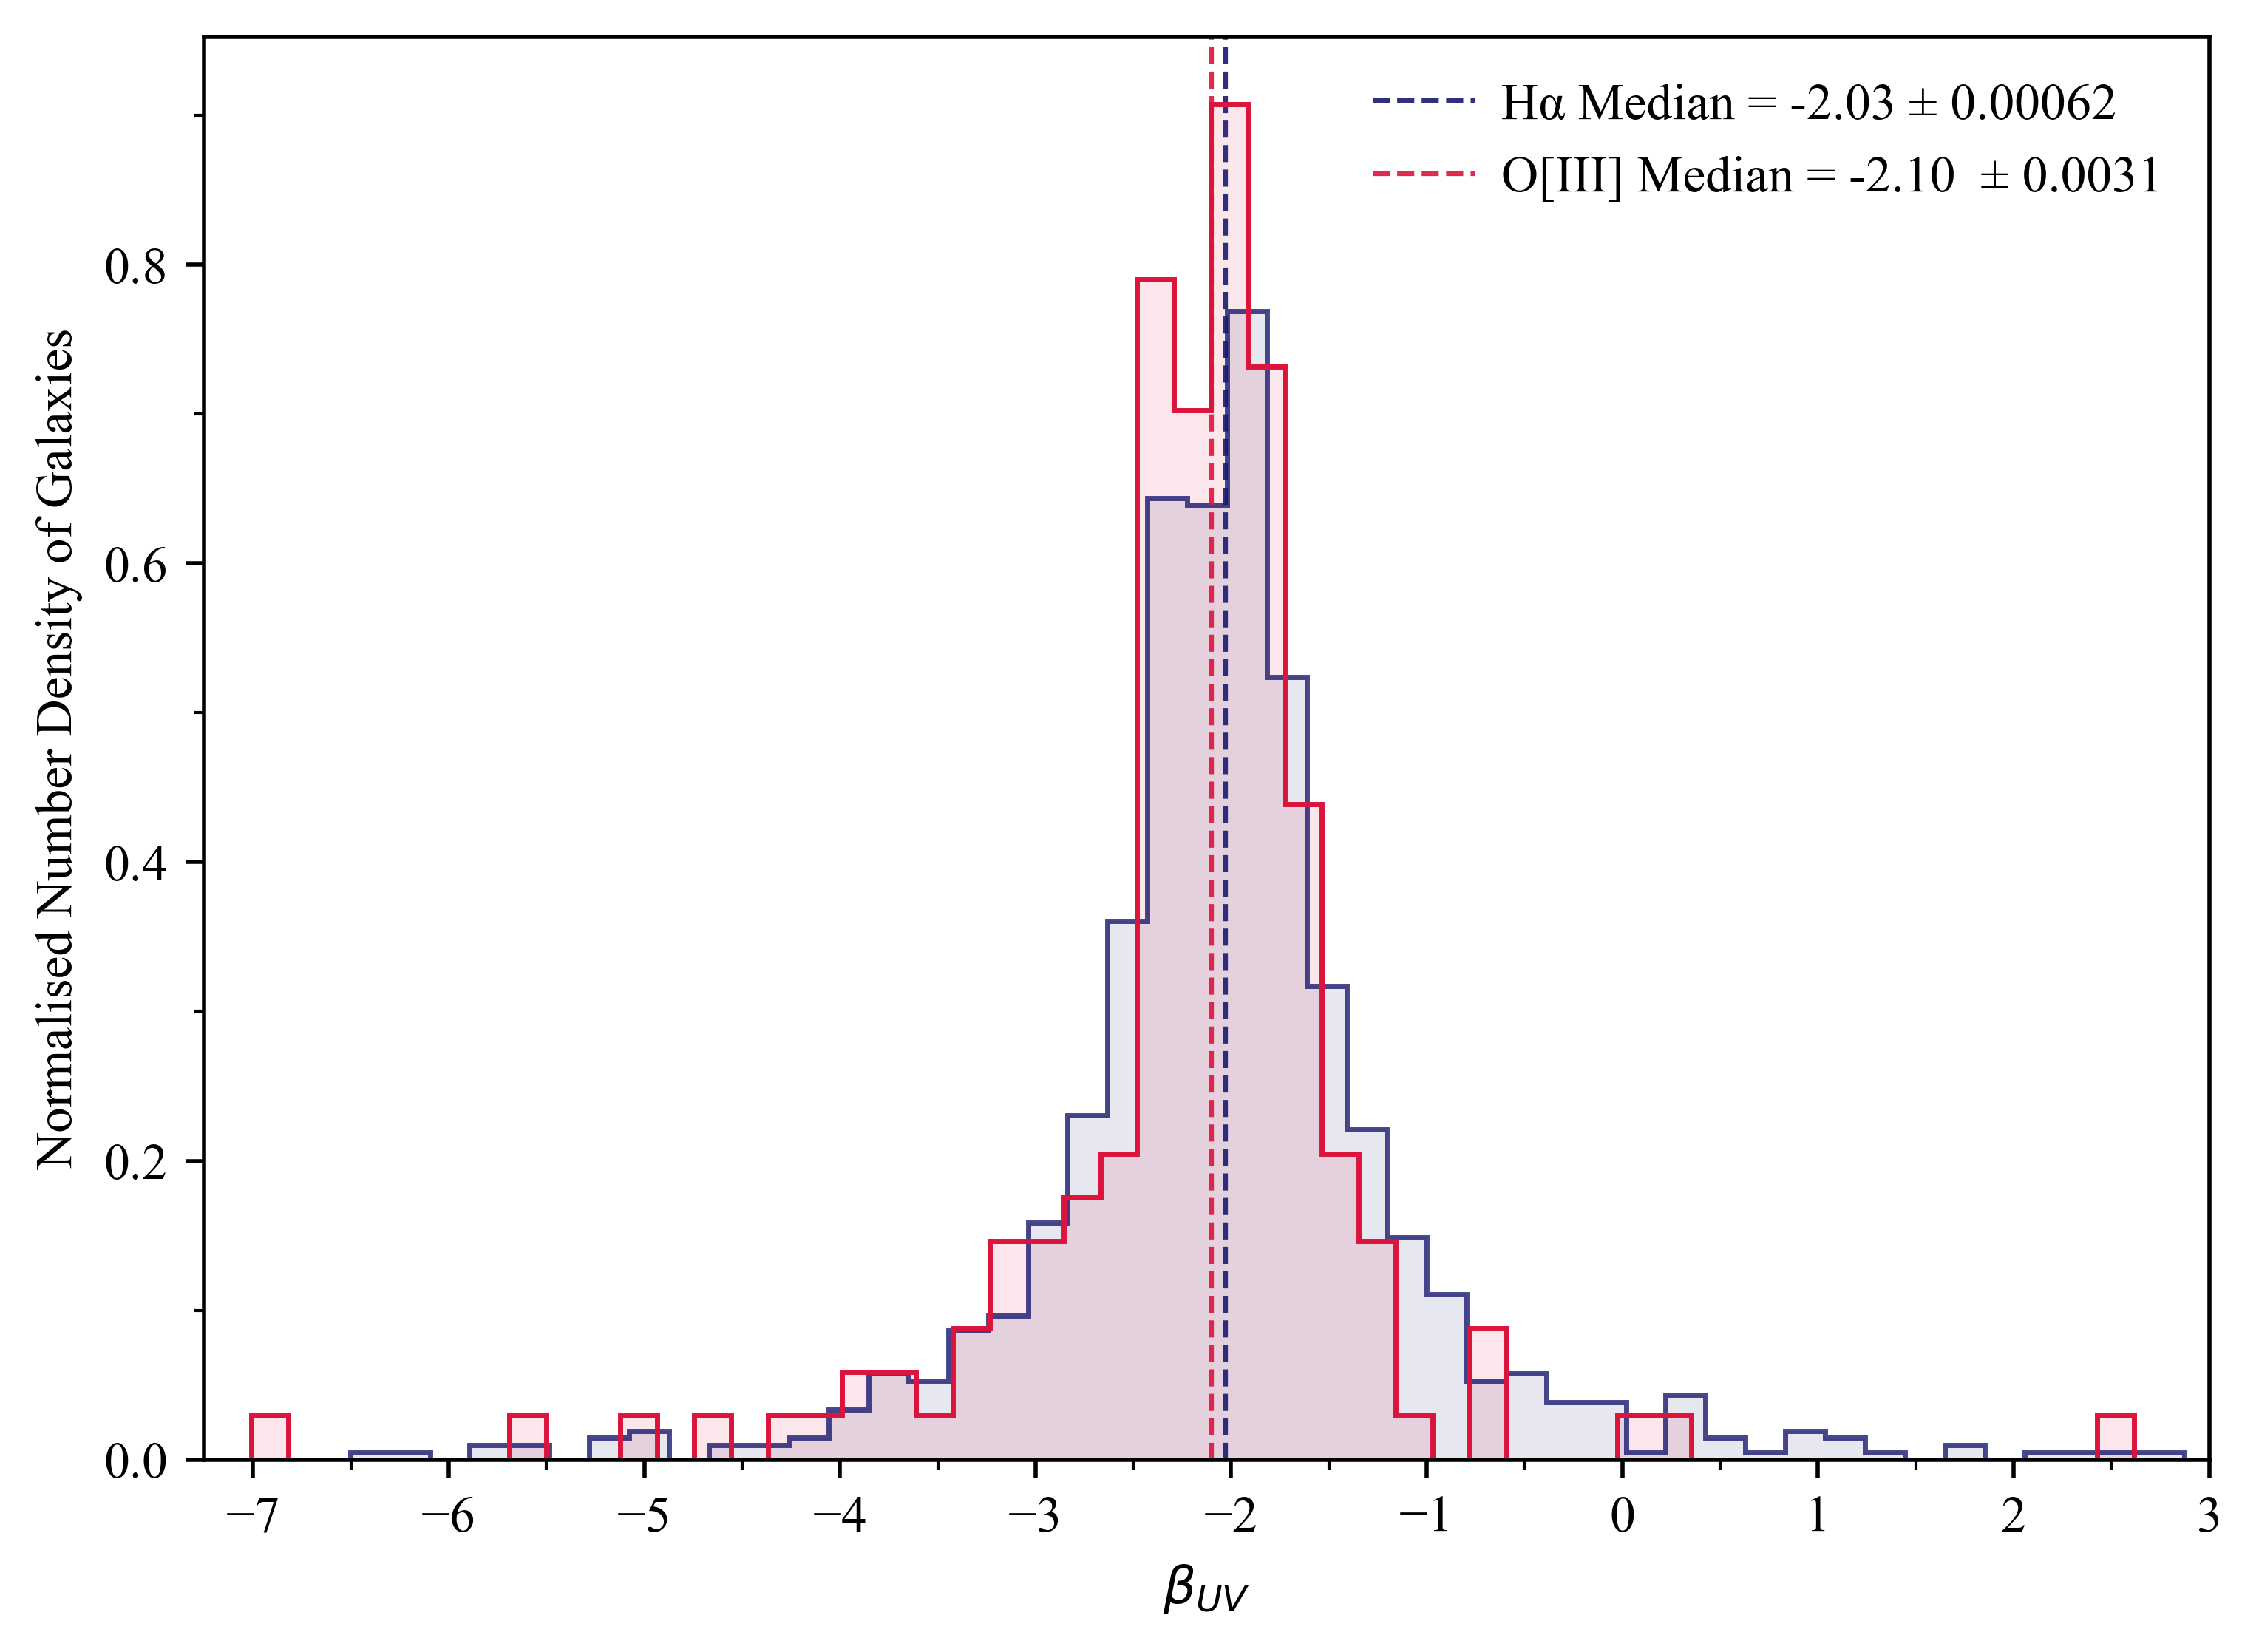

In [46]:
BINS = 100

plt.figure(dpi=500, figsize=(7, 5))


dat = data_cat_full[np.logical_and(HA_410_full, SIGMACUT_full, MAGCUT_full)]
beta = dat['beta_5'].values
beta = beta[~np.isnan(beta)]
# beta = beta[~np.isinf(beta)]
_err = np.percentile(beta, [16, 50, 84])
err_Ha_beta = (np.average([np.subtract(_err[1], _err[0]), np.subtract(_err[2], _err[1])])/len(beta))

print(dat.shape)
print(np.isnan(beta).sum(), np.isinf(beta).sum())

plt.hist(beta, bins=BINS, color='midnightblue', alpha=0.1, density=True)
data = plt.hist(beta, bins=BINS, color='midnightblue', histtype='step', alpha=0.8, density=True)
#mod = data[1][np.argmax(data[0])]
med_Ha = np.median(beta)
sigma = mad(beta)
#plt.axvline(mod, color='black', linestyle='--', linewidth=0.8, alpha=0.8, label='Mode ≈ {:.2f}'.format(mod))

plt.axvline(med_Ha, color='midnightblue', linestyle='--', linewidth=0.9, alpha=0.9, label='Hα Median = {:.2f} ± {:.2g}'.format(med_Ha, err_Ha_beta))
# plt.axvline(sigma, color='green', linestyle='--', linewidth=0.8, alpha=0.8, label='±1σ ≈ {:.2f}'.format(sigma))


BINS = 70
dat = data_cat_full[np.logical_and(OIII_410_full, SIGMACUT_full, MAGCUT_full)]
beta = dat['beta_7'].values
beta = beta[~np.isnan(beta)]
# beta = beta[~np.isinf(beta)]

_err = np.percentile(beta, [16, 50, 84])
err_OIII_beta = (np.average([np.subtract(_err[1], _err[0]), np.subtract(_err[2], _err[1])])/len(beta))

print(dat.shape)
print(np.isnan(beta).sum(), np.isinf(beta).sum())

plt.hist(beta, bins=BINS, color='crimson', alpha=0.1, density=True)
data = plt.hist(beta, bins=BINS, color='crimson', histtype='step', density=True)
#mod = data[1][np.argmax(data[0])]
med_OIII = np.median(beta)
sigma = mad(beta)
#plt.axvline(mod, color='black', linestyle='--', linewidth=0.8, alpha=0.8, label='Mode ≈ {:.2f}'.format(mod))
plt.axvline(med_OIII, color='crimson', linestyle='--', linewidth=0.9, alpha=0.9, label='O[III] Median = {:.2f}  ± {:.2g}'.format(med_OIII, err_OIII_beta))
# plt.axvline(sigma, color='green', linestyle='--', linewidth=0.8, alpha=0.8, label='±1σ ≈ {:.2f}'.format(sigma))

#plt.title('OIII Emission Line in f410m')
plt.xlabel('$β_{UV}$')
plt.ylabel('Normalised Number Density of Galaxies')

plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))


plt.xlim(-7.25, 3)
plt.legend(frameon=False, handletextpad=0.5)
plt.show()

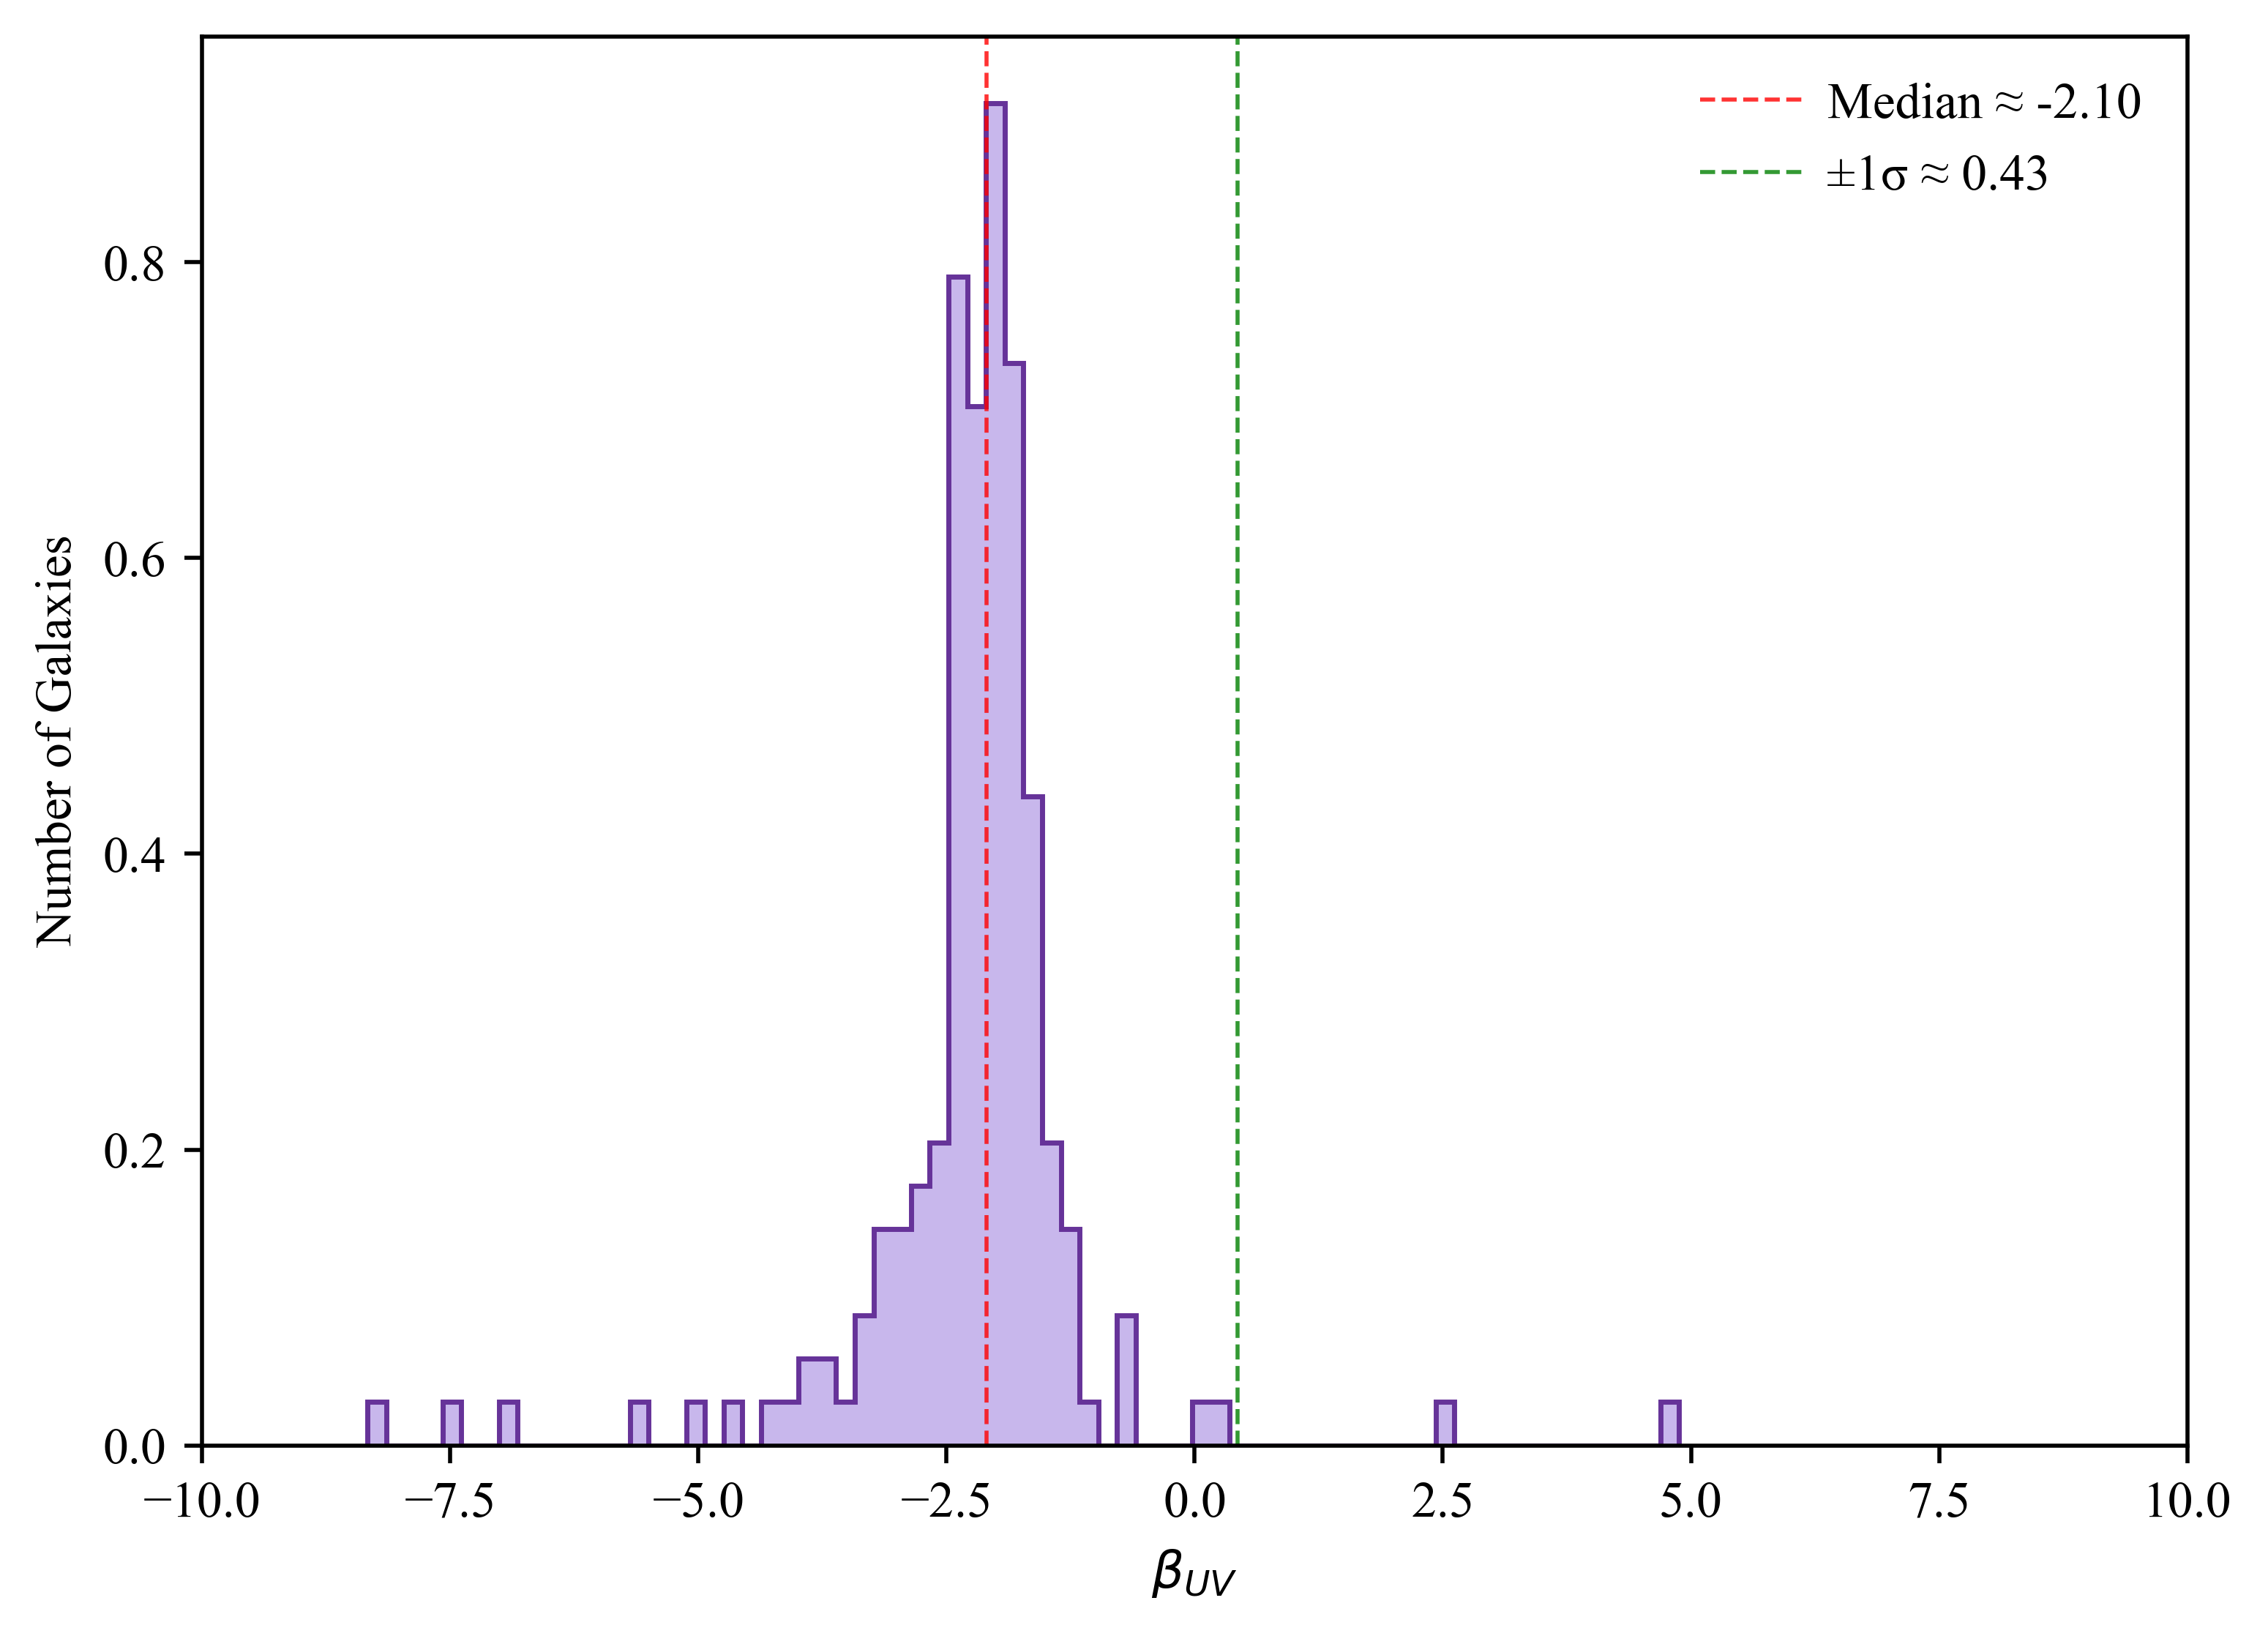

In [47]:
BINS = 70

plt.figure(dpi=500, figsize=(7, 5))
plt.hist(beta, bins=BINS, color='mediumpurple', alpha=0.5, density=True)
data = plt.hist(beta, bins=BINS, color='rebeccapurple', histtype='step', density=True)
#mod = data[1][np.argmax(data[0])]
med_OIII = np.median(beta)
sigma = mad(beta)
#plt.axvline(mod, color='black', linestyle='--', linewidth=0.8, alpha=0.8, label='Mode ≈ {:.2f}'.format(mod))
plt.axvline(med_OIII, color='red', linestyle='--', linewidth=0.8, alpha=0.8, label='Median ≈ {:.2f}'.format(med_OIII))
plt.axvline(sigma, color='green', linestyle='--', linewidth=0.8, alpha=0.8, label='±1σ ≈ {:.2f}'.format(sigma))

#plt.title('OIII Emission Line in f410m')
plt.xlabel('$β_{UV}$')
plt.ylabel('Number of Galaxies')
# plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(4))
# plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(2))
# plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.xlim(-10, 10)
plt.legend(frameon=False, handletextpad=0.5)
plt.show()

In [48]:
# #mpl.colormaps.unregister('beach')
# colors =["#002921", "#003c30", "#008F72", "#FFF7C2", "#4C2C05"]
# nodes = [0.0, 0.03, 0.25, 0.5, 1.0]
# beach = LinearSegmentedColormap.from_list("beach", list(zip(nodes, colors)))
# mpl.colormaps.register(cmap=beach)

plt.figure(dpi=500, figsize=(6, 6))
plt.scatter(beta, EWs_phot, s=1.5, alpha=0.6, c=data_mod_cat['z_spec'][HA_410], cmap='viridis') # c=dat['chi2_best'], cmap='gist_rainbow'

plt.xlabel('Beta of UV Spectral Slope')
plt.ylabel('Equivalent Width [Å]')

# put colourbar on the bottom
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('Photometric Redshift (z)')
cbar.set_alpha(0.7)

plt.show()


In [49]:
redshift = np.linspace(0, 10, 500)
element  = {
    'Lyman-α': 1216,
    'O[III]': 5007,
    'Hα': 6563,
}

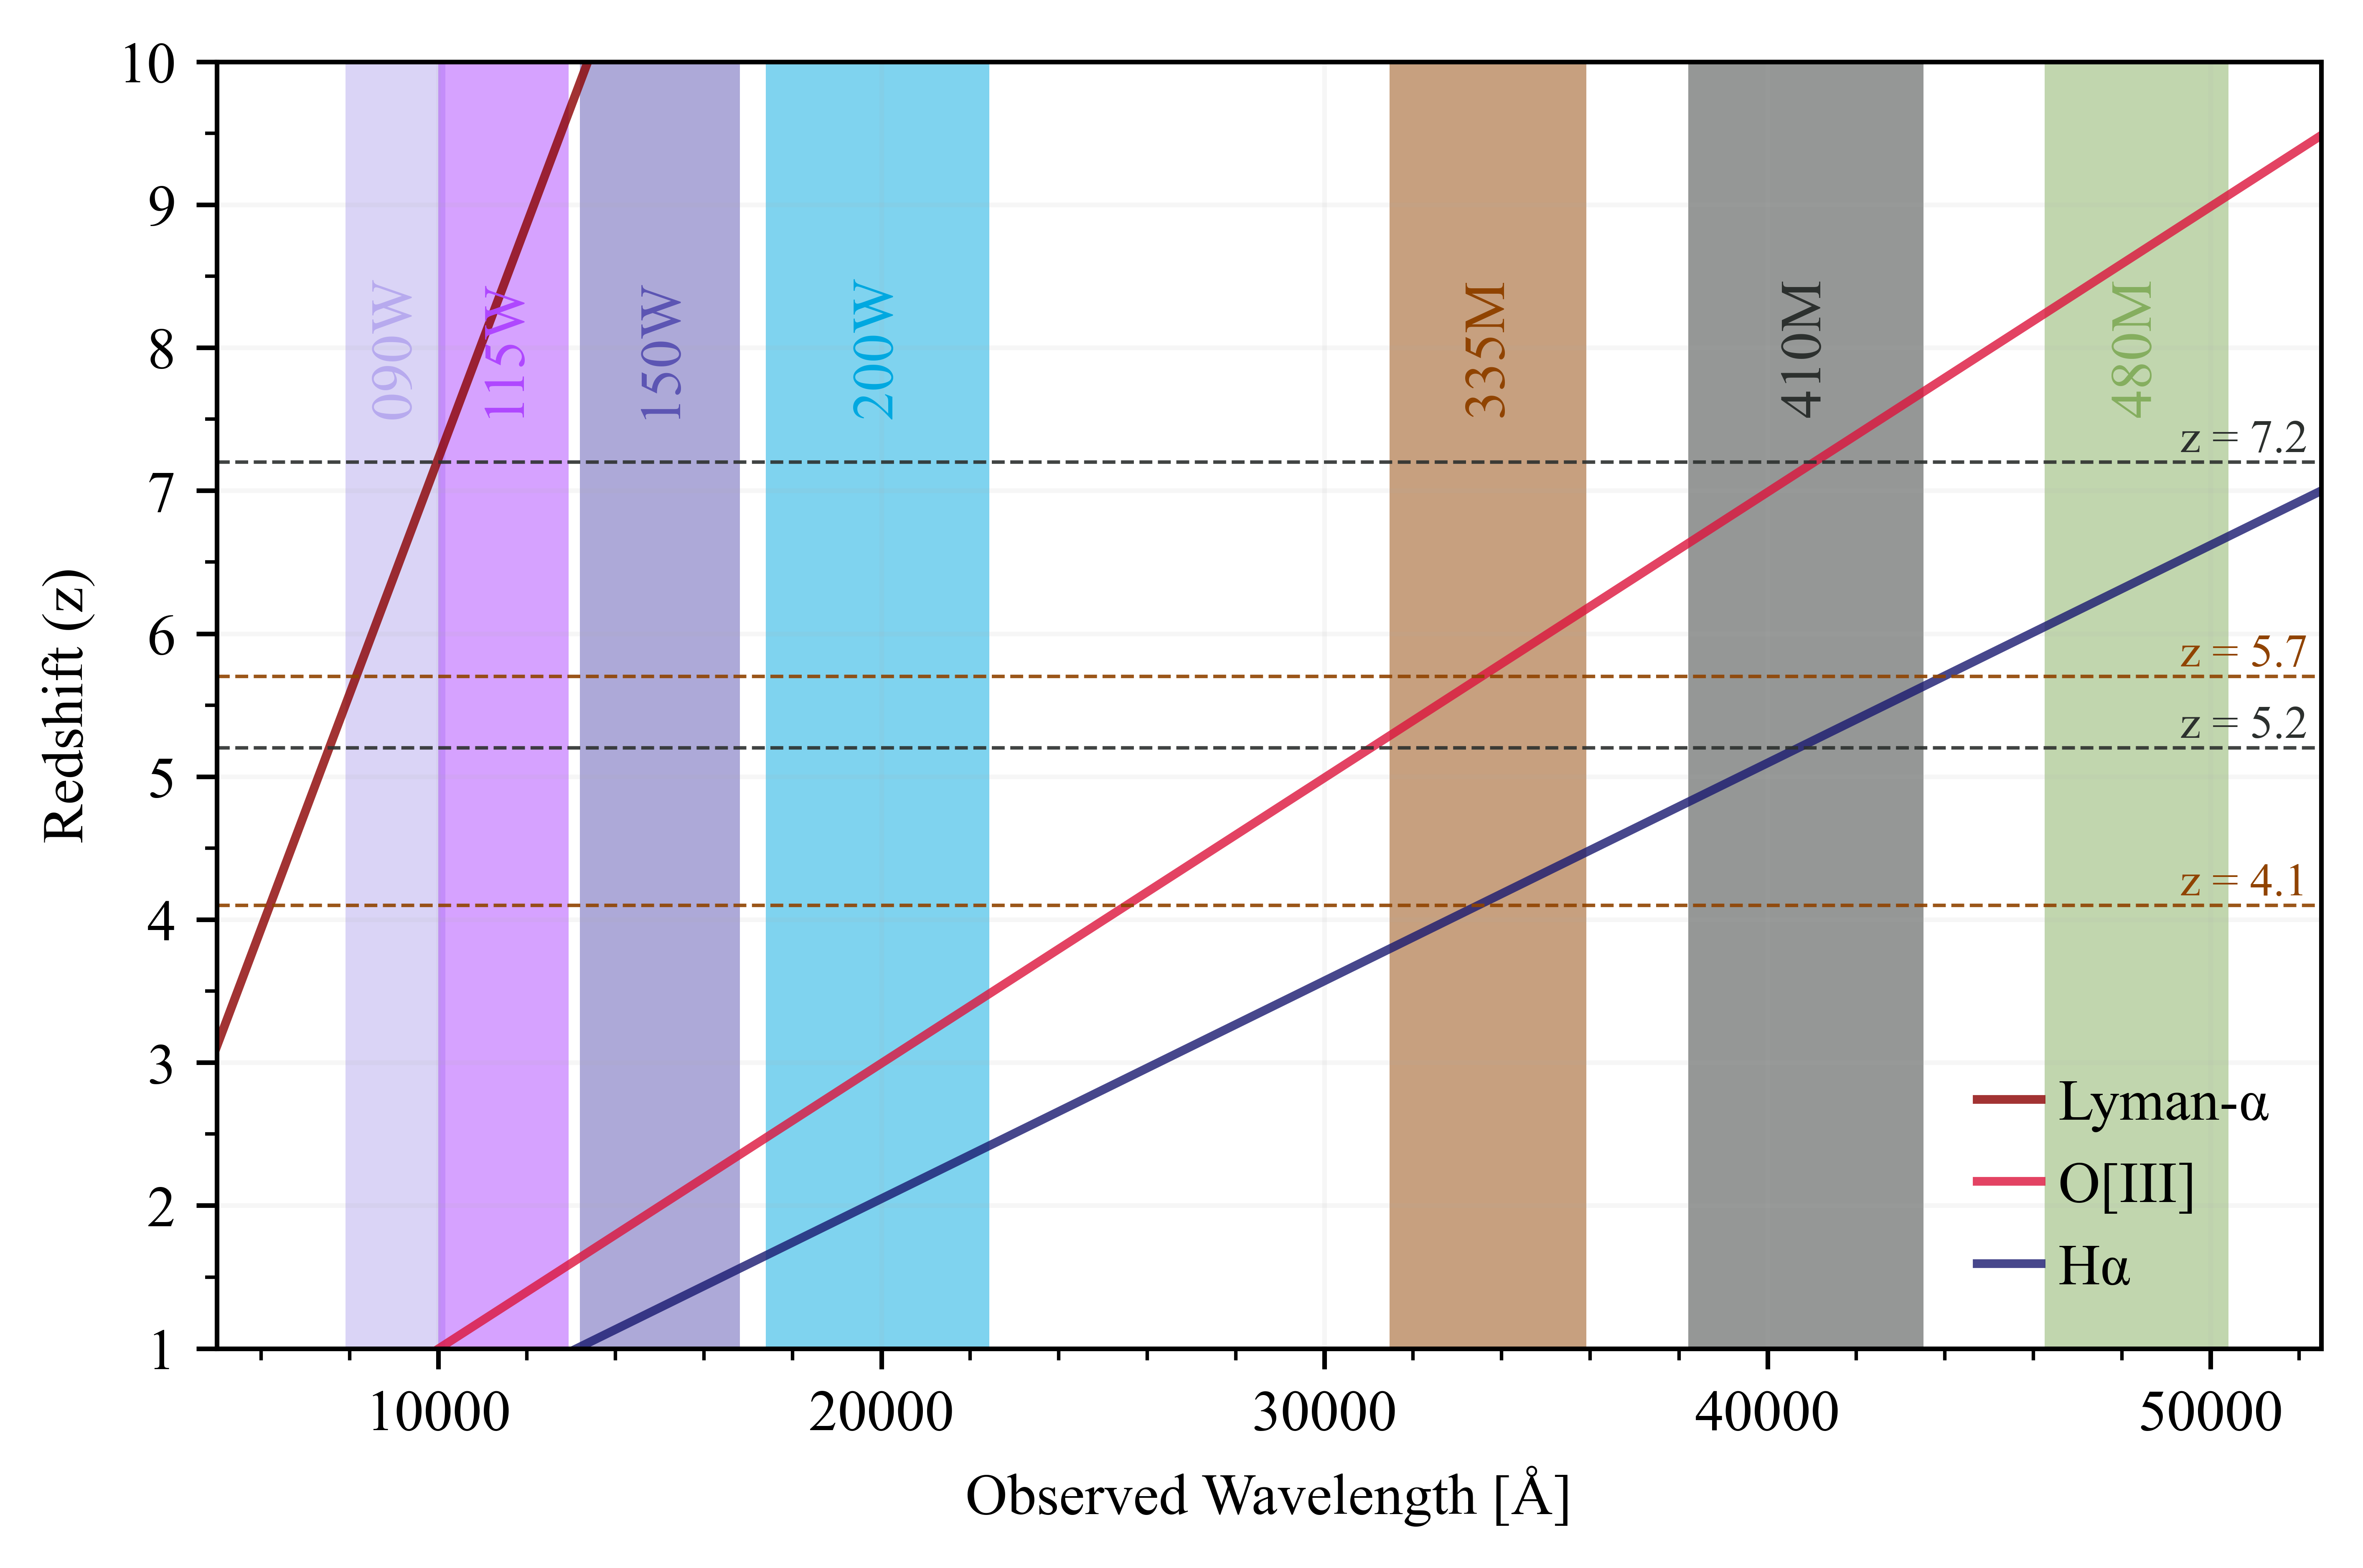

In [50]:
plt.figure(dpi=1000, figsize=(6.5, 4))
colours = ['darkred', 'crimson', 'midnightblue']
for ele, colour in zip(element, colours):
    obs = element[ele] * (1 + redshift)
    plt.plot(obs, redshift, label=ele, color=colour, alpha=0.8)

for file in os.listdir(os.path.join(homedir, "Filter_files")):
    if file.endswith('.dat'):
        for t in filters_list:
            for fil in t['filters']:
                if fil.upper() in file.split('.')[1]:
                    if ('90' in fil) or ('115' in fil) or ('150' in fil) or ('200' in fil) or ('335' in fil) or ('410' in fil) or ('480' in fil):
                       
                        data = pd.read_csv(os.path.join(homedir, "Filter_files", file), sep='\s+', header=None, names=['Wavelength', 'Transmission'])

                        minmax = data[np.isclose(np.max(data['Transmission'])*0.1, data['Transmission'], atol=0.007, rtol=0.01)]
                        fill = [minmax['Wavelength'].min(), minmax['Wavelength'].max()]

                        plt.fill_between(fill, y1=min(redshift), y2=max(redshift), color=t['colours'][t['filters'].index(fil)], alpha=0.5, linewidth=0)
                        # put the filter name on the plot horizontally in the center of the filter
                        plt.text(np.mean(fill), 8, fil.upper(), color=t['colours'][t['filters'].index(fil)], fontsize=10, ha='center', va='center', rotation=90)
                        
                        if fil == '410m':
                            plt.axhline(y=5.2, color=t['colours'][t['filters'].index(fil)], linestyle='--', linewidth=0.6, alpha=0.9)
                            plt.text(50750, 5.35, 'z = 5.2', color=t['colours'][t['filters'].index(fil)], fontsize=8, ha='center', va='center')
                            plt.axhline(y=7.2, color=t['colours'][t['filters'].index(fil)], linestyle='--', linewidth=0.6, alpha=0.9)
                            plt.text(50750, 7.35, 'z = 7.2', color=t['colours'][t['filters'].index(fil)], fontsize=8, ha='center', va='center')

                        if fil == '335m':
                            plt.axhline(y=4.1, color=t['colours'][t['filters'].index(fil)], linestyle='--', linewidth=0.6, alpha=0.9)
                            plt.text(50750, 4.25, 'z = 4.1', color=t['colours'][t['filters'].index(fil)], fontsize=8, ha='center', va='center')
                            plt.axhline(y=5.7, color=t['colours'][t['filters'].index(fil)], linestyle='--', linewidth=0.6, alpha=0.9)
                            plt.text(50750, 5.85, 'z = 5.7', color=t['colours'][t['filters'].index(fil)], fontsize=8, ha='center', va='center')

plt.xlabel('Observed Wavelength [Å]')
plt.ylabel('Redshift (z)')

plt.xlim(5000, 52500)
plt.ylim(1, 10)

# plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
# plt.gca().yaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))
# plt.gca().yaxis.set_major_locator(mtick.FixedLocator([1, 2, 3, 4, 5, 7, 10]))  # Set specific y-axis ticks

plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))
# plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(5000))

plt.grid(True, alpha=0.1)

plt.legend(frameon=False, handlelength=1.1, handletextpad=0.3)
plt.show()

## Working with the Master Catologue

In [51]:
def solve(data):
    # Difference in Magnitudes
    data['diff_mag'] = (data['mag_f410m'] - data['mag_f335m'])

    # EWs
    data['EWs_phot_410'] = ((4262.86)*(10**(-0.4*data['diff_mag'])))/(1+data['z_phot'])
    data['EWs_spec_410'] = ((4262.86)*(10**(-0.4*data['diff_mag'])))/(1+data['z_spec'])

    data['EWs_phot_335'] = ((3389.42)*(10**(-0.4*data['diff_mag'])))/(1+data['z_phot'])
    data['EWs_spec_335'] = ((3389.42)*(10**(-0.4*data['diff_mag'])))/(1+data['z_spec'])

    # Luminosities/Magnitudes
    data['mag_f090w'] = -2.5 * np.log10(data['f090w']) + 23.9
    data['mag_f150w'] = -2.5 * np.log10(data['f150w']) + 23.9

    data['del_mag'] = (data['mag_f090w'] - data['mag_f150w'])

    # Spectral Slope
    data['beta'] = (data['del_mag']/(2.5*np.log10(2890.43/1772.74)))-2.0

    # MASKS
    SIGMACUT = (data['f356w'] > data['f356w_err']*5)
    MAGCUT = (data['mag_f356w'] < 29.6)
    HA_335 = (data['z_phot'] > 3.8) & (data['z_phot'] < 4.6)
    HA_410 = (data['z_phot'] > 4.9) & (data['z_phot'] < 5.5)

    OIII_335 = (data['z_phot'] > 5.35) & (data['z_phot'] < 6.25)
    OIII_410 = (data['z_phot'] > 6.0) & (data['z_phot'] < 8.0)

    return data, HA_335, HA_410, OIII_335, OIII_410, SIGMACUT, MAGCUT

In [52]:
master_cat = pd.read_csv(os.path.join(homedir, 'Output', 'Catalogue', 'Master_Catalogue.txt'), sep='\s+', low_memory=False)
master_cat, HA_335_master, HA_410_master, OIII_335_master, OIII_410_master, SIGMACUT_master, MAGCUT_master = solve(master_cat)

c:\Users\blybe\miniconda3\envs\astro-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\blybe\miniconda3\envs\astro-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\blybe\miniconda3\envs\astro-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [53]:
master_cat

id         RA        Dec    x-position    y-position     f090w  \
0        146  53.170537 -27.844227  11933.376392   3311.670822  0.006618   
1        164  53.168693 -27.844079  12129.109123   3329.432586  0.140312   
2        266  53.169974 -27.843162  11993.062789   3439.495847  0.887314   
3        264  53.169253 -27.842783  12069.638152   3484.981069  1.700261   
4        265  53.169491 -27.842380  12044.277525   3533.262258  0.201978   
...      ...        ...        ...           ...           ...       ...   
36640  36640  53.157024 -27.724048  13363.225977  17733.585998  0.001913   
36641  36641  53.157190 -27.724017  13345.558957  17737.299582 -0.001296   
36642  36642  53.157312 -27.723954  13332.573951  17744.908232 -0.000482   
36643  36643  53.157134 -27.723953  13351.501375  17745.008228  0.002243   
36644  36644  53.157106 -27.723932  13354.477235  17747.508749  0.002014   

          f115w     f150w     f200w     f277w  ...  SFR(Msol/yr)  diff_mag  \
0      0.012990  0.014152  0.011931  0.015340  ...      1.561662  1.492983   
1      0.169181  0.183347  0.196015  0.210762  ...      0.063300  0.317402   
2      0.979958  1.038850  1.081681  0.763371  ...      0.131081  0.183328   
3      2.399981  2.967105  3.676898  4.307370  ...      0.000000  0.232272   
4      0.261651  0.303640  0.342302  0.381582  ...      0.086089  0.242293   
...         ...       ...       ...       ...  ...           ...       ...   
36640  0.000314  0.001235  0.000940  0.001050  ...           NaN -1.185604   
36641  0.000196 -0.001065 -0.001001  0.000905  ...           NaN       NaN   
36642 -0.001533 -0.001341 -0.000174  0.001792  ...           NaN -0.056144   
36643  0.002829  0.002484  0.001924  0.003593  ...      0.041376  0.323160   
36644  0.002075  0.002259  0.002040  0.003416  ...      0.021021  0.184366   

       EWs_phot_410  EWs_spec_410  EWs_phot_335  EWs_spec_335  mag_f090w  \
0        154.046754    159.062725    122.483297    126.471520  29.348116   
1       1791.080709   1800.856982   1424.096681   1431.869842  26.032263   
2       2938.794285   2967.085492   2336.649134   2359.143605  24.029807   
3       1871.655200   1880.485812   1488.161837   1495.183098  23.323711   
4       1871.205125   1840.482878   1487.803980   1463.376577  25.636740   
...             ...           ...           ...           ...        ...   
36640  10023.513589           NaN   7969.742714           NaN  30.695711   
36641           NaN           NaN           NaN           NaN        NaN   
36642    281.309652           NaN    223.670625           NaN        NaN   
36643    917.606840           NaN    729.593506           NaN  30.522957   
36644   1038.921593           NaN    826.051437           NaN  30.639857   

       mag_f150w   del_mag      beta  
0      28.522993  0.825124 -0.445490  
1      25.741818  0.290445 -1.452809  
2      23.858618  0.171189 -1.677485  
3      22.719168  0.604543 -0.861058  
4      25.194101  0.442639 -1.166081  
...          ...       ...       ...  
36640  31.171119 -0.475408 -2.895655  
36641        NaN       NaN       NaN  
36642        NaN       NaN       NaN  
36643  30.411978  0.110979 -1.790919  
36644  30.515024  0.124833 -1.764818  

[36645 rows x 57 columns]

In [54]:
data_cat_full.keys()

Index(['id', 'RA', 'Dec', 'x-position', 'y-position', 'f090w', 'f115w',
       'f150w', 'f200w', 'f277w', 'f335m', 'f356w', 'f410m', 'f435w', 'f444w',
       'f606w', 'f775w', 'f814w', 'f850lp', 'f090w_err', 'f115w_err',
       'f150w_err', 'f200w_err', 'f277w_err', 'f335m_err', 'f356w_err',
       'f410m_err', 'f435w_err', 'f444w_err', 'f606w_err', 'f775w_err',
       'f814w_err', 'f850lp_err', 'z_phot', 'chi2_best', 'z_err', 'mag_f335m',
       'mag_f356w', 'mag_f410m', 'z_spec', 'z_spec_reference', 'z_spec_source',
       'z_spec_quality', 'Separation', 'diff_mag', 'EWs_phot_410',
       'EWs_spec_410', 'EWs_phot_335', 'EWs_spec_335', 'mag_f090w',
       'mag_f150w', 'mag_f115w', 'mag_f200w', 'del_mag_5', 'del_mag_7',
       'beta_5', 'beta_7'],
      dtype='object')

In [55]:
dat_OIII = data_cat_full[np.logical_and(OIII_410_full, SIGMACUT_full, MAGCUT_full)]
log10IonEff_OIII = (0.76*np.log10(dat_OIII['EWs_phot_410']))+23.9
esc_OIII = (1.3*(10**-4))*(10**(-1.22*dat_OIII['beta_7']))

In [56]:
dat_Ha = data_cat_full[np.logical_and(HA_410_full, SIGMACUT_full, MAGCUT_full)]
log10IonEff_Ha = (0.85*np.log10(dat_Ha['EWs_phot_410']))+23.03
esc_ha = (1.3*(10**-4))*(10**(-1.22*dat_Ha['beta_5']))

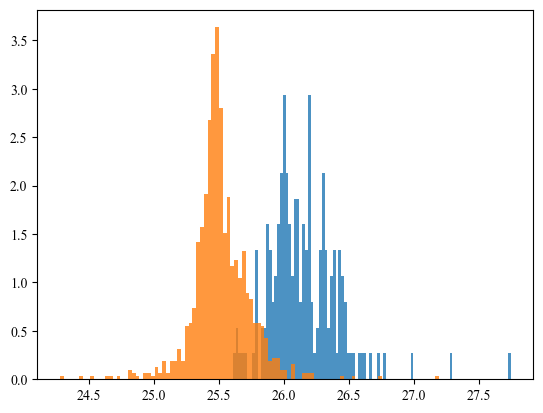

In [57]:
plt.hist(log10IonEff_OIII, bins=100, alpha=0.8, density=True)
plt.hist(log10IonEff_Ha, bins=100, alpha=0.8, density=True)
plt.show()

In [58]:
# find error
EW = np.log10(dat_OIII['EWs_phot_410'])
EW = EW[~np.isnan(EW)]
_err = np.percentile(EW, [16, 50, 84])
errrrr = (np.average([np.subtract(_err[1], _err[0]), np.subtract(_err[2], _err[1])])/len(EW))
print(errrrr)

0.0017059323155298191


C:\Users\blybe\AppData\Local\Temp\ipykernel_12088\649661744.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


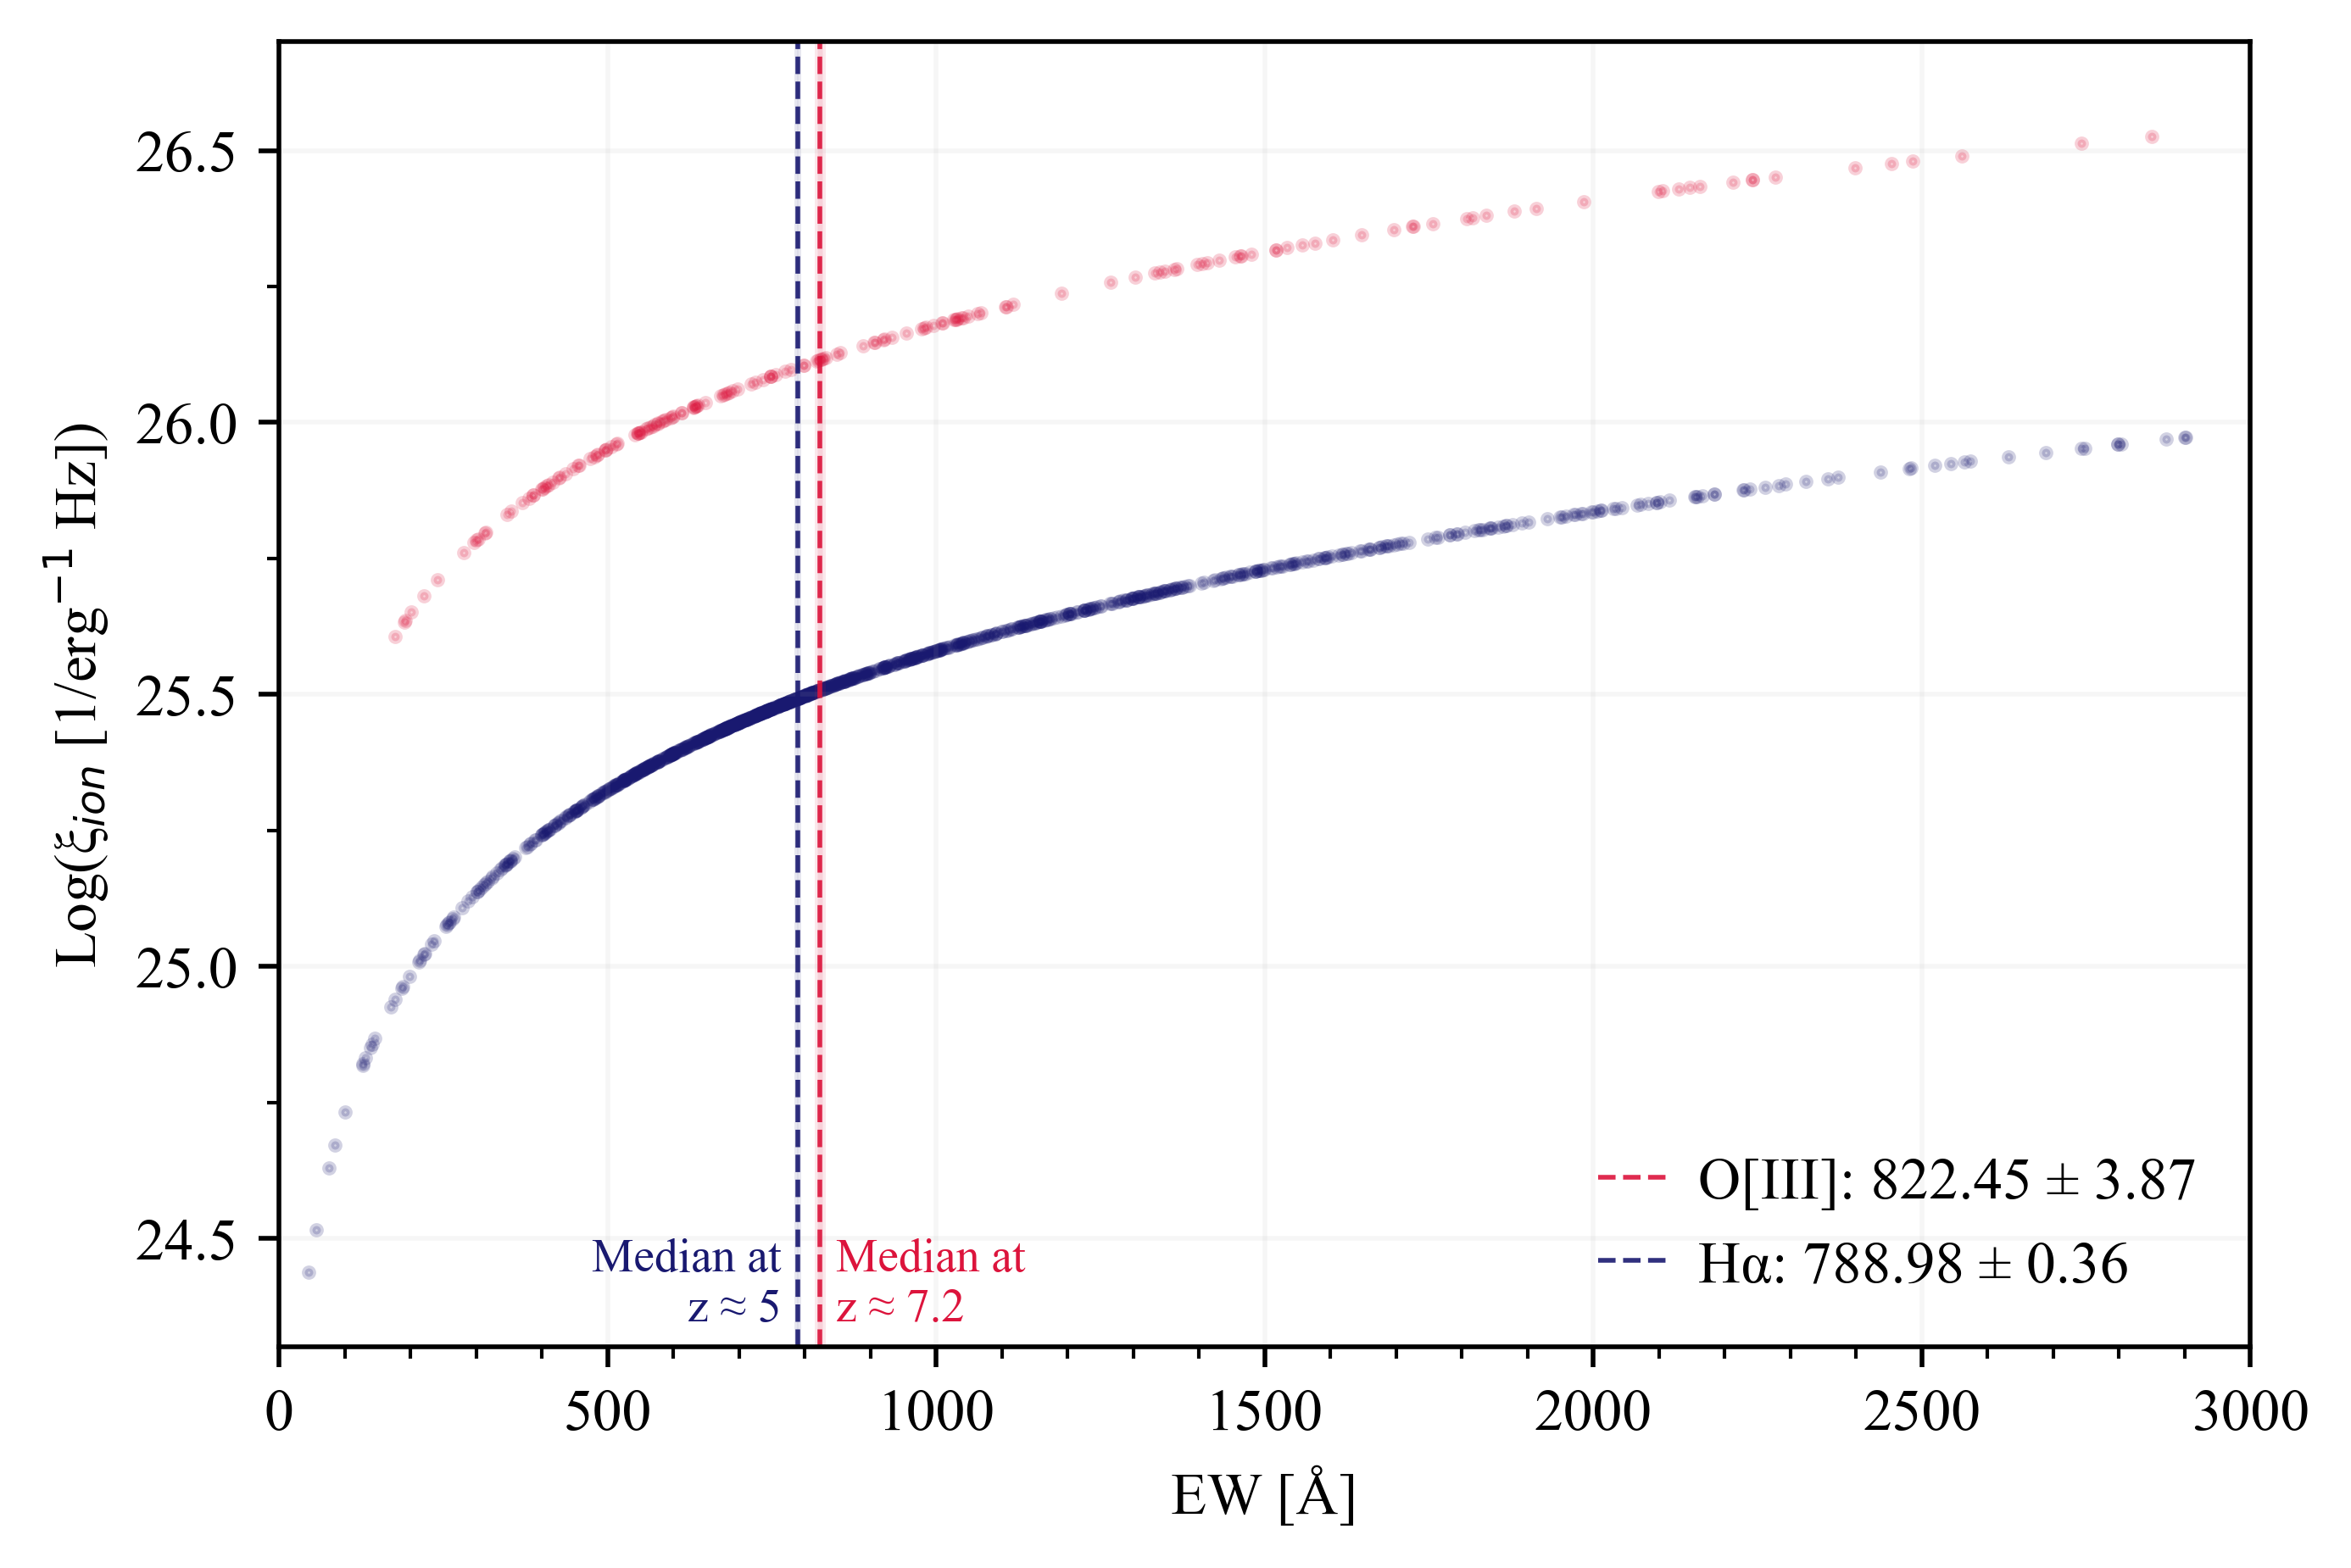

In [59]:
plt.figure(figsize=(6, 4), dpi=500)

EW_OIII = dat_OIII['EWs_phot_410']
EW_OIII = EW_OIII[~np.isnan(EW_OIII)]
_err = np.percentile(EW_OIII, [16, 50, 84])
EW_OIII_err = (np.average([np.subtract(_err[1], _err[0]), np.subtract(_err[2], _err[1])])/len(EW_OIII))

plt.scatter(dat_OIII['EWs_phot_410'], log10IonEff_OIII, alpha=0.2, s=2, color='crimson')

EW_Ha = dat_Ha['EWs_phot_410']
EW_Ha = EW_Ha[~np.isnan(EW_Ha)]
_err = np.percentile(EW_Ha, [16, 50, 84])
EW_Ha_err = (np.average([np.subtract(_err[1], _err[0]), np.subtract(_err[2], _err[1])])/len(EW_Ha))

plt.scatter(dat_Ha['EWs_phot_410'], log10IonEff_Ha, alpha=0.2, s=2, color='midnightblue')

ylim = plt.ylim(plt.ylim()[0], plt.ylim()[1])
plt.axvline(median_phot_OIII, color='crimson', linestyle='--', linewidth=0.8, alpha=0.9, label=f'O[III]: {median_phot_OIII:.2f} ± {EW_OIII_err:.3g}')
plt.text(median_phot_OIII+25, 24.33, 'Median at\nz ≈ 7.2 ', color='crimson', fontsize=8, ha='left', va='bottom')
plt.fill_betweenx(ylim, median_phot_OIII-err_OIII, median_phot_OIII+err_OIII, color='crimson', alpha=0.1)
plt.axvline(median_phot_Ha, color='midnightblue', linestyle='--', linewidth=0.8, alpha=0.9, label=f'Hα: {median_phot_Ha:.2f} ± {EW_Ha_err:.2f}')
plt.text(median_phot_Ha-25, 24.33, 'Median at\nz ≈ 5', color='midnightblue', fontsize=8, ha='right', va='bottom')
plt.fill_betweenx(ylim, median_phot_Ha-err_Ha, median_phot_Ha+err_Ha, color='midnightblue', alpha=0.1)

plt.xlabel('EW [Å]')
plt.ylabel('Log(ξ$_{ion}$ [1/erg Hz$^{-1}$])') #

# minor ticks
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))


# limit axes
# plt.xlim(2.25, )
plt.ylim(24.3, 26.7)
plt.xlim(0, 3000)

plt.grid(True, alpha=0.1)
leg = plt.legend(frameon=False, handletextpad=0.5, markerscale=1, handlelength=1.2)
for lh in leg.legendHandles: 
    lh.set_alpha(0.9)
plt.show()

In [60]:
esc_ha[esc_ha < 10]

138      0.025667
142      0.027693
186      0.145039
188      0.011759
189      0.035067
           ...   
36519    0.085965
36520    0.057728
36564    0.000681
36566    0.809187
36614    0.037447
Name: beta_5, Length: 991, dtype: float64

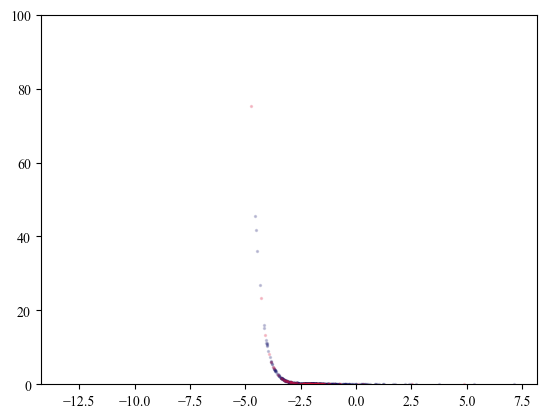

In [61]:
plt.scatter(dat_Ha['beta_5'], esc_ha, alpha=0.2, s=2, color='midnightblue')
plt.scatter(dat_OIII['beta_7'], esc_OIII, alpha=0.2, s=2, color='crimson')
plt.ylim(0, 100)
plt.show()

C:\Users\blybe\AppData\Local\Temp\ipykernel_12088\91067118.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


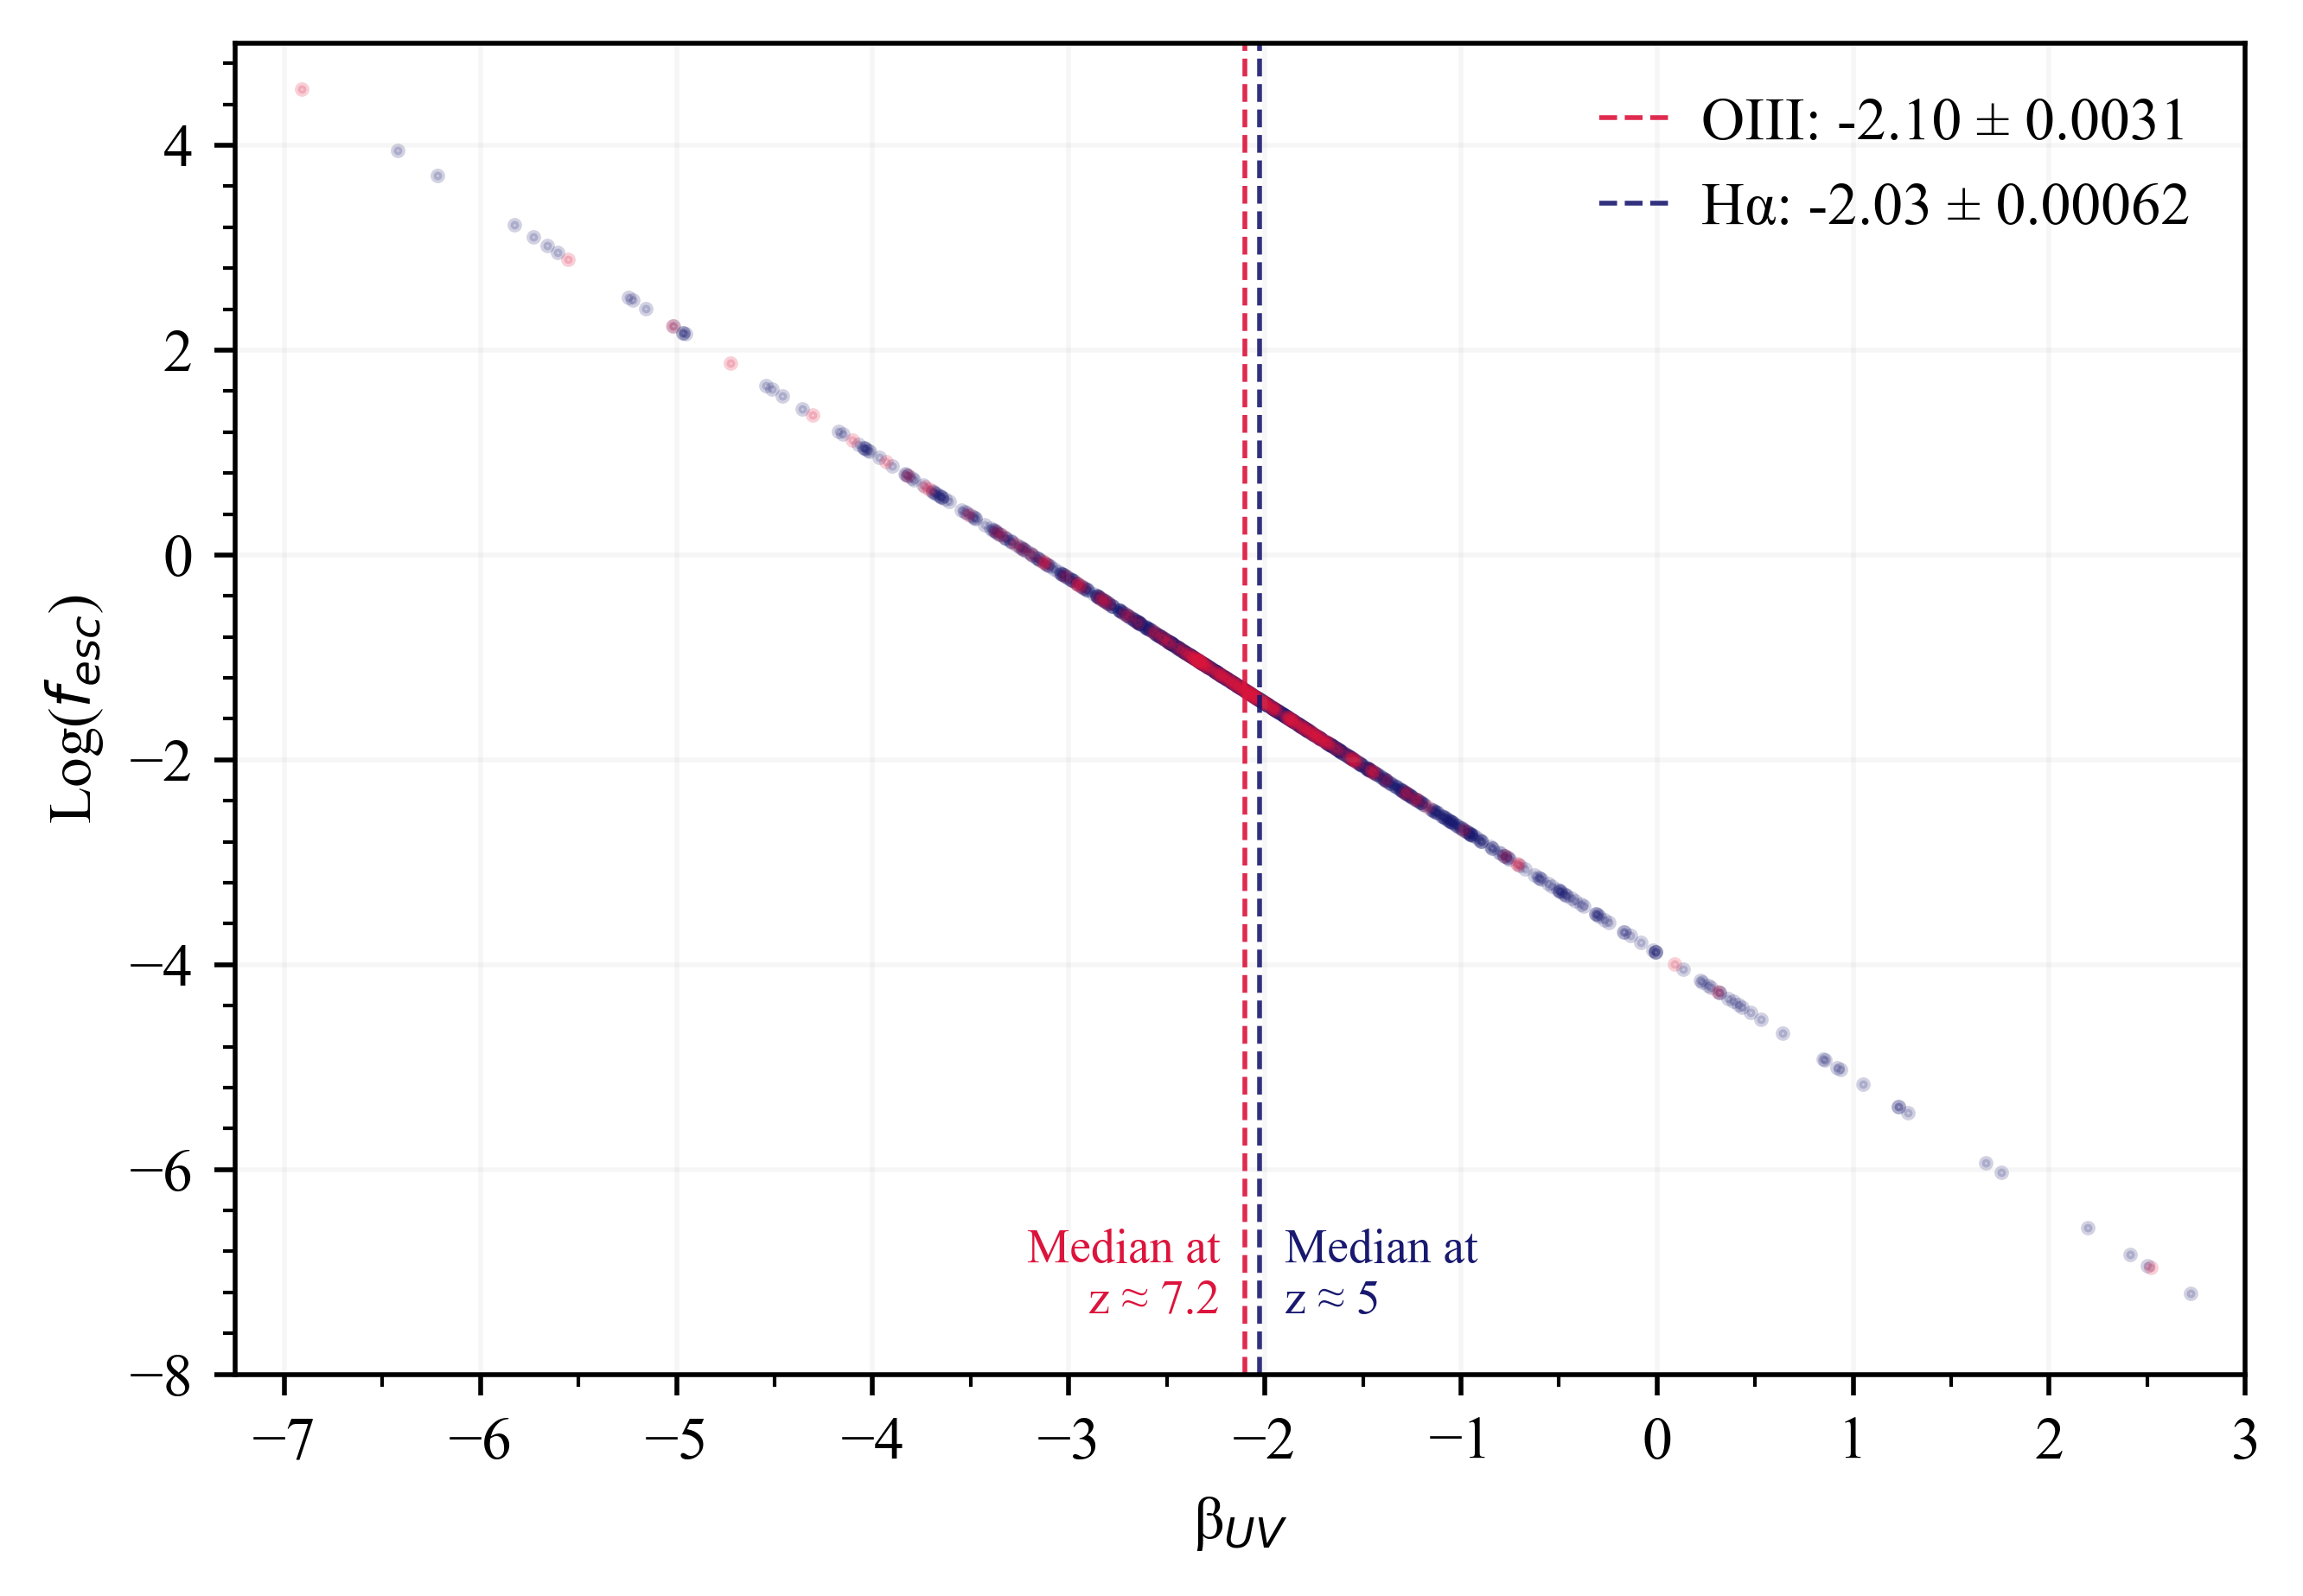

In [62]:
plt.figure(figsize=(6, 4), dpi=500)

# Assuming dat_OIII and dat_Ha are defined elsewhere in your code
plt.scatter(dat_Ha['beta_5'], np.log10(esc_ha), alpha=0.2, s=2, color='midnightblue')
plt.scatter(dat_OIII['beta_7'], np.log10(esc_OIII), alpha=0.2, s=2, color='crimson')

plt.axvline(med_OIII, color='crimson', linestyle='--', linewidth=0.8, alpha=0.9, label=f'OIII: {med_OIII:.2f} ± {err_OIII_beta:.2g}')
plt.text(med_OIII+0.2, -7.5, 'Median at\nz ≈ 5', color='midnightblue', fontsize=8, ha='left', va='bottom')
plt.axvline(med_Ha, color='midnightblue', linestyle='--', linewidth=0.8, alpha=0.9, label=f'Hα: {med_Ha:.2f} ± {err_Ha_beta:.2g}')
plt.text(med_Ha-0.2, -7.5, 'Median at\nz ≈ 7.2', color='crimson', fontsize=8, ha='right', va='bottom')

# plt.axhline(np.log10(5), color='black', linestyle='--', linewidth=0.6, alpha=0.8)
# plt.text(2.75, np.log10(5)-0.5, '$f_{esc}$ at 5%', color='midnightblue', fontsize=8, ha='right', va='bottom')
# plt.axhline(np.log10(10), color='black', linestyle='--', linewidth=0.6, alpha=0.8)
# plt.text(2.75, np.log10(10)-0.5, '$f_{esc}$ at 10%', color='midnightblue', fontsize=8, ha='right', va='bottom')
# plt.axhline(np.log10(20), color='black', linestyle='--', linewidth=0.6, alpha=0.8)
# plt.text(2.75, np.log10(20)-0.5, '$f_{esc}$ at 20%', color='crimson', fontsize=8, ha='right', va='bottom')
# plt.axhline(np.log10(100), color='black', linestyle='--', linewidth=0.6, alpha=0.8)
# plt.text(2.75, np.log10(100)-0.5, '$f_{esc}$ = 100', color='black', fontsize=8, ha='right', va='bottom')

#plt.yscale('symlog')
plt.ylabel('Log($f_{esc}$)')
plt.xlabel('β$_{UV}$')

# Set minor ticks for both x and y axes
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.gca().yaxis.set_major_locator(mtick.MultipleLocator(2))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(5))

plt.grid(True, alpha=0.1)
plt.ylim(-8, 5)
plt.xlim(-7.25, 3)
# Plot the legend
leg = plt.legend(frameon=False, handletextpad=0.5, markerscale=1, handlelength=1.2)
for lh in leg.legendHandles: 
    lh.set_alpha(0.9)

plt.show()

In [63]:
median_phot_Ha, median_phot_OIII, med_Ha, med_OIII

(788.9840967366226,
 822.4474854755883,
 -2.0288590723255964,
 -2.1001682033290123)

In [64]:
err_Ha, err_OIII, err_Ha_beta, err_OIII_beta

(0.3587977730613813,
 3.8655076600484177,
 0.0006189846599668418,
 0.0030998902061785067)

In [65]:
log10IonEff_Ha_median = (0.85*np.log10(median_phot_Ha))+23.03
log10IonEff_Ha_err_median = ((0.85*np.log10(err_Ha))+23.03)/len(dat_Ha['EWs_phot_410'])
log10IonEff_OIII_median = (0.76*np.log10(median_phot_OIII))+23.9
log10IonEff_OIII_err_median = ((0.76*np.log10(err_OIII))+23.9)/len(dat_OIII['EWs_phot_410'])

esc_median = (1.3*(10**-4))*(10**(-1.22*np.array([med_Ha, med_OIII])))
esc_err_median = ((1.3*(10**-4))*(10**(-1.22*np.array([err_Ha_beta, err_OIII_beta])))/len(dat_OIII['EWs_phot_410']))

In [66]:
log10IonEff_Ha_median, log10IonEff_Ha_err_median, log10IonEff_OIII_median, log10IonEff_OIII_err_median, esc_median, esc_err_median

(25.492508011975453,
 0.020010267030061823,
 26.11548221462887,
 0.13019399448689636,
 array([0.03882857, 0.04744042]),
 array([6.93979409e-07, 6.89159710e-07]))

In [67]:
def histLine(pltN, data, bins=None, color=None, transform_angle=0, axisOff=True, linewidth=0.8, label=None):    
    if type(bins) == None:
        bins = np.linspace(np.min(data)-10, np.max(data)+10, 1000)
            
    density = stats.gaussian_kde(data)
    _, x = np.histogram(data, bins=bins,
                        density=True)
    if axisOff == True:
        pltN.axis('off')
    if transform_angle == 90:
        pltN.plot((density(x)), x, color=color, linewidth=linewidth, label=label)
        pltN.invert_yaxis()
        return density(x)
        
    else:
        pltN.plot(x, density(x), color=color, linewidth=linewidth, label=label)
        return density(x)

In [68]:
x_vals = [np.array(log10IonEff_Ha), np.array(log10IonEff_OIII)]
y_vals = [np.log10(np.array(esc_ha)), np.log10(np.array(esc_OIII))]

# clean arrays of nans and infs
x_vals = [x[~np.isnan(x)] for x in x_vals]
y_vals = [y[~np.isnan(y)] for y in y_vals]

np.isinf(x_vals[0]).sum(), np.isnan(x_vals[0]).sum(), np.isinf(y_vals[0]).sum(), np.isnan(y_vals[0]).sum()

(0, 0, 0, 0)

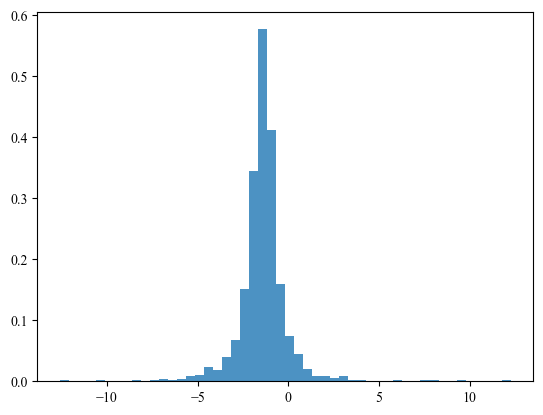

In [69]:
plt.hist(y_vals[0], bins=50, alpha=0.8, density=True)
plt.show()

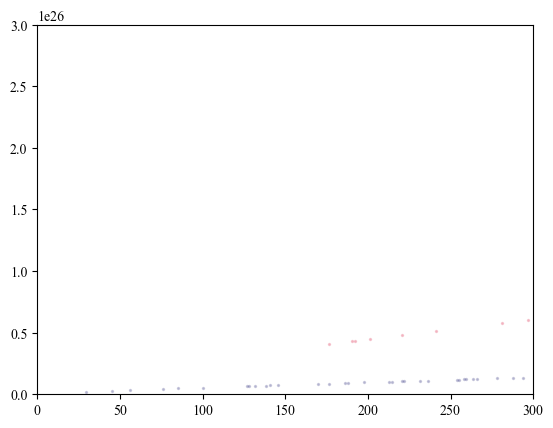

In [70]:
plt.scatter( dat_Ha['EWs_phot_410'], 10**log10IonEff_Ha, alpha=0.2, s=2, color='midnightblue')
plt.scatter( dat_OIII['EWs_phot_410'], 10**log10IonEff_OIII, alpha=0.2, s=2, color='crimson')
plt.xlim(0, 300)
plt.ylim(0, 0.3e27)
plt.show()

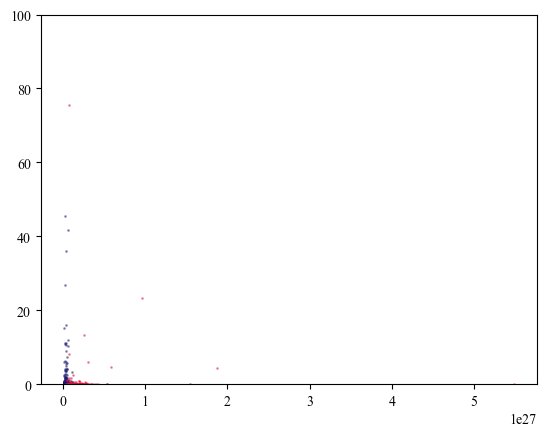

In [71]:
plt.scatter(10**log10IonEff_Ha, esc_ha, alpha=0.4, s=1, color='midnightblue', label='Hα')
plt.scatter(10**log10IonEff_OIII, esc_OIII, alpha=0.4, s=1, color='crimson', label='OIII')
plt.ylim(0, 100)
plt.xlim()
plt.show()

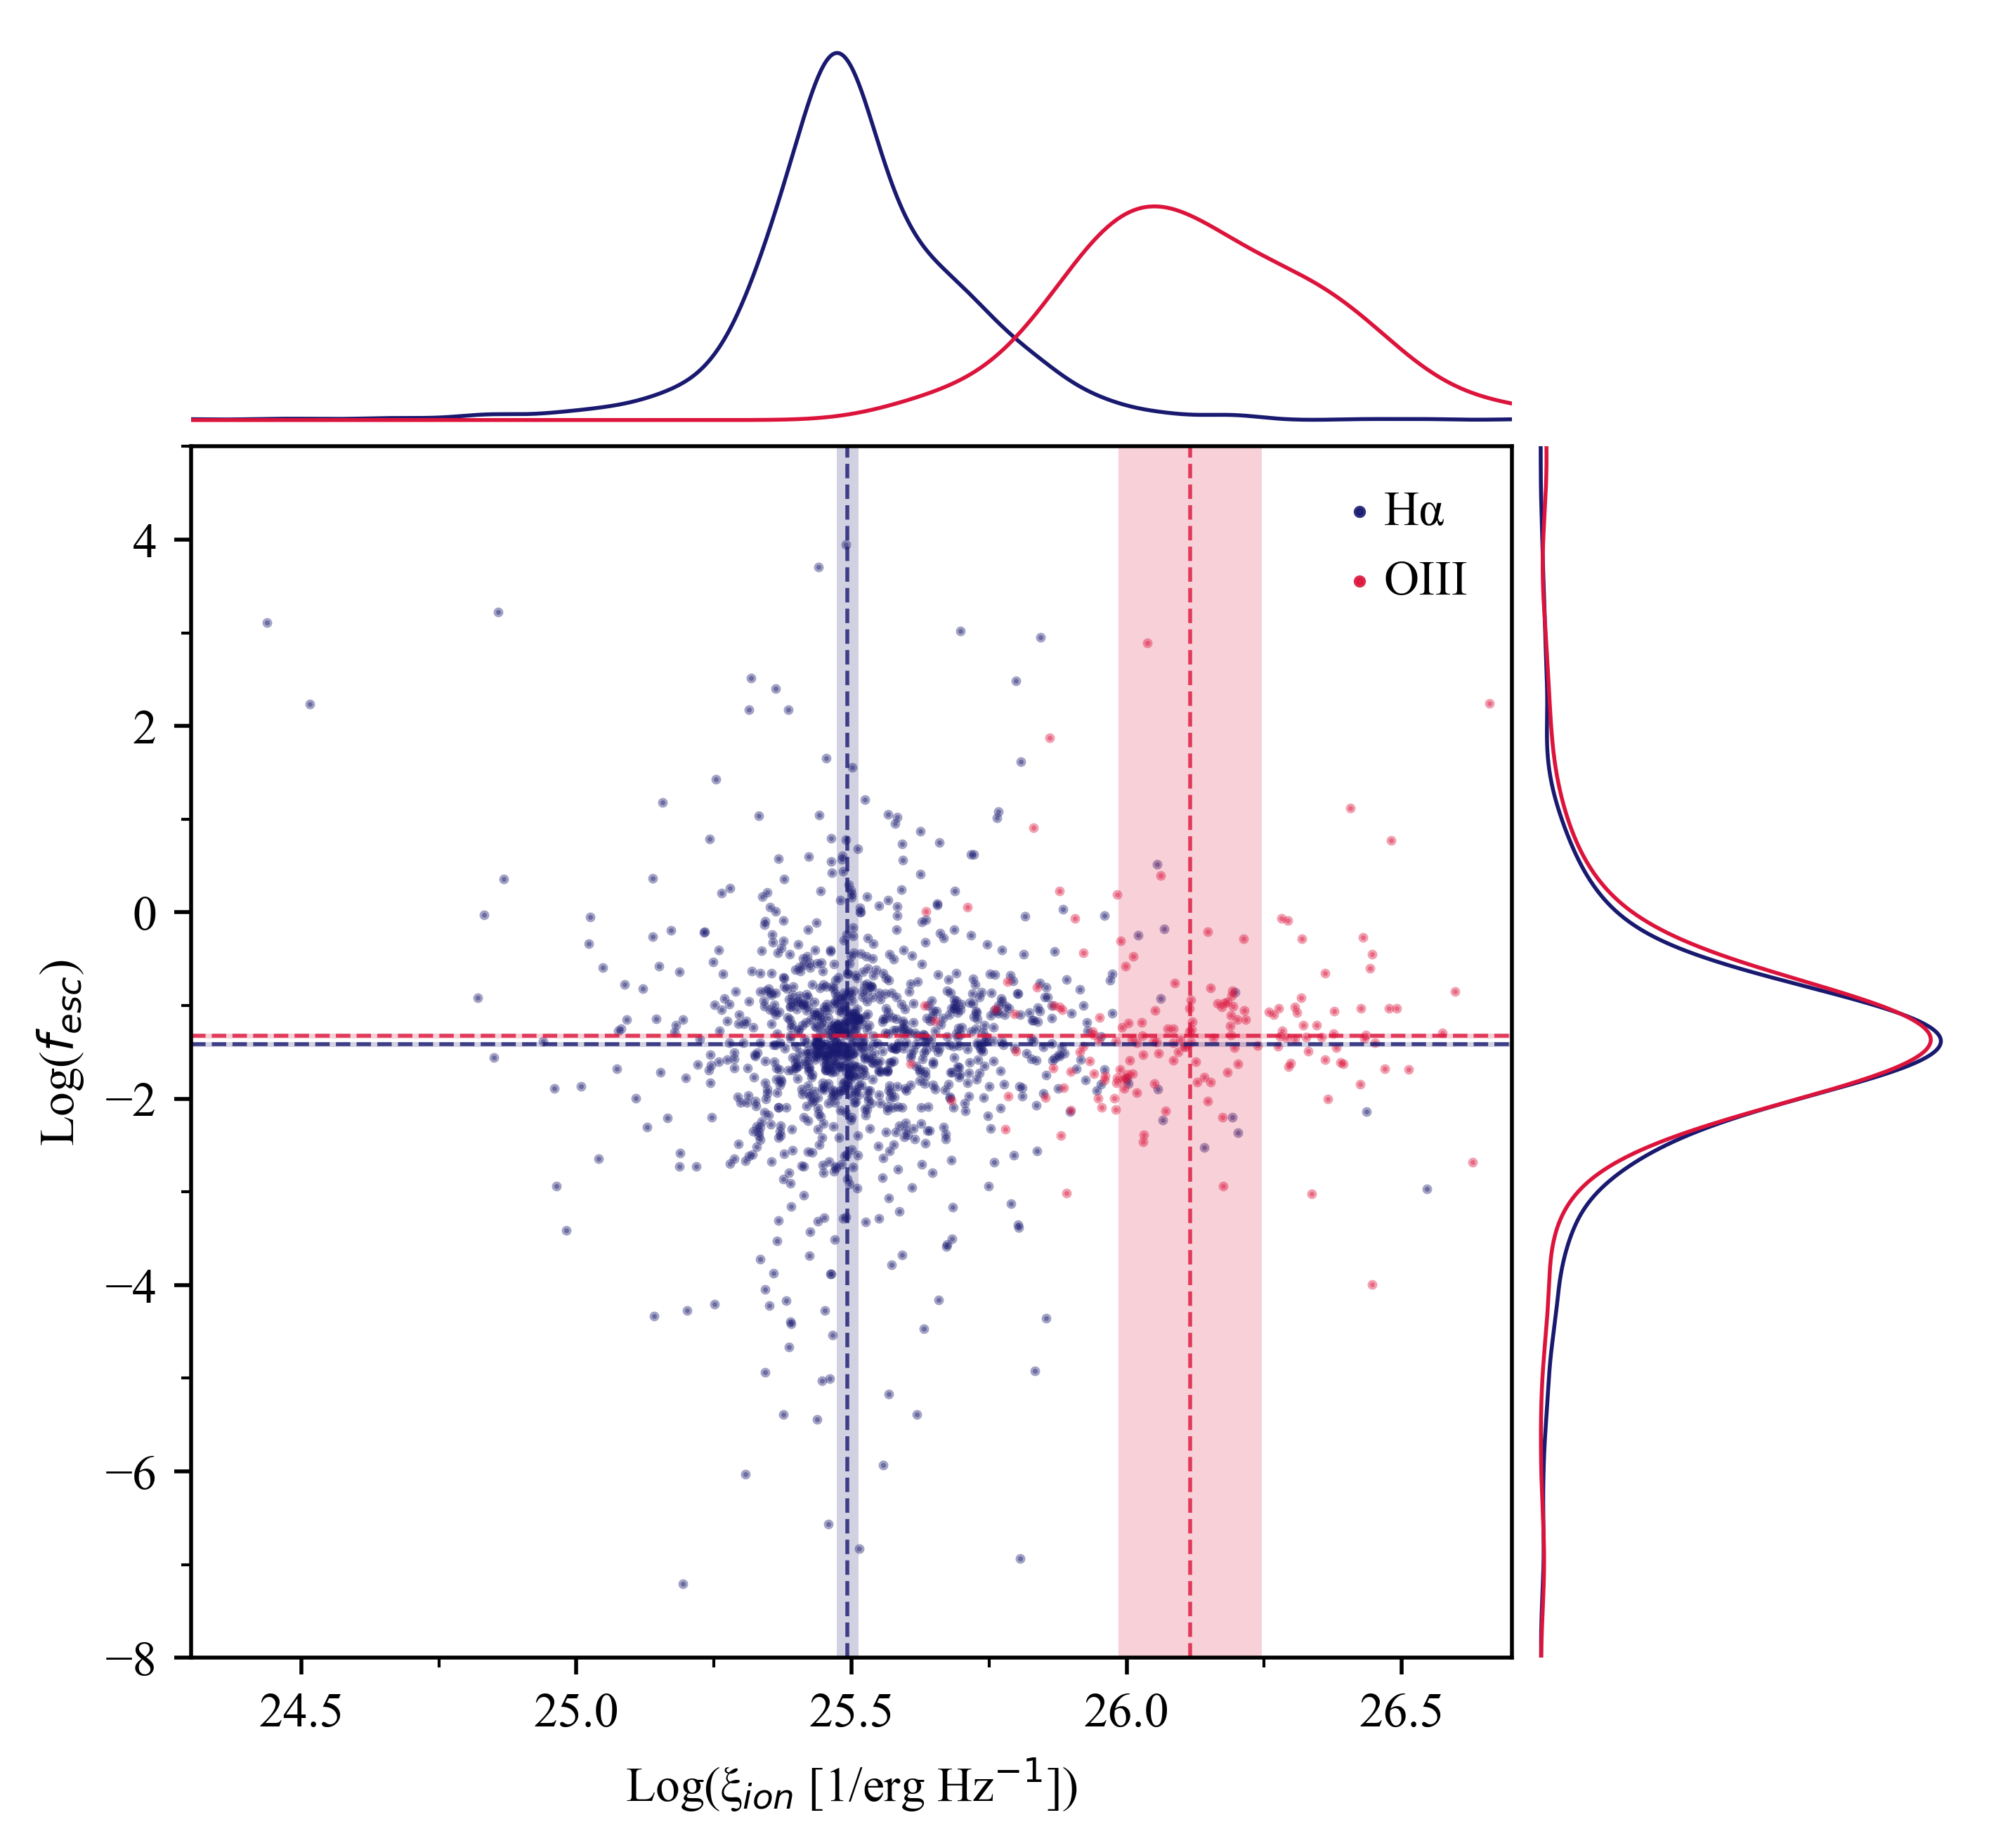

In [73]:
# plt.figure(figsize=(6, 4), dpi=500)


fig = plt.figure(dpi=500, figsize=(6.5,6)) #layout='constrained'
gs = fig.add_gridspec(2, 2,  width_ratios=(3, 1), height_ratios=(1, 3),
                      #left=0., #right=0.9, 
                      #bottom=0., #top=0.9,
                      #wspace=0.0, hspace=0.0
                      )
                      
#fig.subplots_adjust(wspace=0, hspace=0)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.scatter(log10IonEff_Ha, np.log10(esc_ha), alpha=0.4, s=1, color='midnightblue', label='Hα')
ax.scatter(log10IonEff_OIII, np.log10(esc_OIII), alpha=0.4, s=1, color='crimson', label='OIII')

xlims = np.array(ax.set_xlim(24.3, 26.7))
ylims = np.array(ax.set_ylim(-8, 5))

# Ionizing efficiency lines
ax.axvline(log10IonEff_Ha_median, color='midnightblue', linestyle='--', linewidth=0.8, alpha=0.8)
ax.fill_betweenx(ylims, x1=log10IonEff_Ha_median-log10IonEff_Ha_err_median, x2=log10IonEff_Ha_median+log10IonEff_Ha_err_median, color='midnightblue', alpha=0.2, linewidth=0)
# ax.text(log10IonEff_Ha_median-0.02, 12.8, f'EW(Hα) = {log10IonEff_Ha_median:.2f} ± {log10IonEff_Ha_err_median:.2f}', color='midnightblue', fontsize=6, ha='right', va='center')

ax.axvline(log10IonEff_OIII_median, color='crimson', linestyle='--', linewidth=0.8, alpha=0.8)
ax.fill_betweenx(ylims, x1=log10IonEff_OIII_median-log10IonEff_OIII_err_median, x2=log10IonEff_OIII_median+log10IonEff_OIII_err_median, color='crimson', alpha=0.2, linewidth=0)
# ax.text(log10IonEff_OIII_median+0.02, 12.8, f'EW(OIII) = {log10IonEff_OIII_median:.2f} ± {log10IonEff_OIII_err_median:.2f}', color='crimson', fontsize=6, ha='left', va='center')

# Escape fraction lines
ax.axhline(np.log10(esc_median[0]), color='midnightblue', linestyle='--', linewidth=0.8, alpha=0.8)
ax.fill_between(xlims, y1=np.log10(esc_median[0]-esc_err_median[0]), y2=np.log10(esc_median[0]+esc_err_median[0]), color='midnightblue', alpha=0.2)
# ax.text(28.4, np.log10(esc_median[0])-0.5, f'$f_{{esc}}$(Hα) = {esc_median[0]:.2e} ± {esc_err_median[0]:.2e}', color='midnightblue', fontsize=6, ha='right', va='center')

ax.axhline(np.log10(esc_median[1]), color='crimson', linestyle='--', linewidth=0.8, alpha=0.8)
ax.fill_between(xlims, y1=np.log10(esc_median[1]-esc_err_median[1]), y2=np.log10(esc_median[1]+esc_err_median[1]), color='crimson', alpha=0.2)
# ax.text(28.4, np.log10(esc_median[1])+0.5, f'$f_{{esc}}$(OIII) = {esc_median[1]:.2e} ± {esc_err_median[1]:.2e}', color='crimson', fontsize=6, ha='right', va='center')

ax.set_xlabel('Log(ξ$_{ion}$ [1/erg Hz$^{-1}$])') #
ax.set_ylabel('Log($f_{esc}$)')

ax.xaxis.set_major_locator(mtick.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax.yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

colour = ['midnightblue', 'crimson']

x_vals = [np.array(log10IonEff_Ha), np.array(log10IonEff_OIII)]
y_vals = [np.log10(np.array(esc_ha)), np.log10(np.array(esc_OIII))]

# clean arrays of nans and infs
x_vals = [x[~np.isnan(x)] for x in x_vals]
y_vals = [y[~np.isnan(y)] for y in y_vals]

x = []
for dataList, col in zip(x_vals, colour):
    x += [histLine(ax_histx, dataList, bins=np.linspace(xlims[0], xlims[1], 1000), color=col)]

y = []
for dataList, col in zip(y_vals, colour):
    y += [histLine(ax_histy, dataList, bins=np.linspace(ylims[0], ylims[1], 1000), color=col, transform_angle=90)]

leg = ax.legend(frameon=False, handletextpad=-0.5, markerscale=1.5)
for lh in leg.legend_handles: 
    lh.set_alpha(0.9)

fig.subplots_adjust(hspace=0.01, wspace=0.01)
plt.show()

mask = np.logical_and.reduce([HA_410_master, (~master_cat['SFR(Msol/yr)'].isna()), (master_cat['SFR(Msol/yr)'] <= 10)])

SFRate_Ha = master_cat['SFR(Msol/yr)'][mask].values
z_phot_ha = master_cat['z_phot'][mask].values
mass_Ha = master_cat['log10(M*/Msol)'][mask].values
age_Ha = master_cat['log10(age/year)'][mask].values
av_Ha = master_cat['av'][mask].values

mask = np.logical_and.reduce([OIII_410_master, (~master_cat['SFR(Msol/yr)'].isna()), (master_cat['SFR(Msol/yr)'] <= 10)])

SFRate_OIII = master_cat['SFR(Msol/yr)'][mask].values
z_phot_OIII = master_cat['z_phot'][mask].values
mass_OIII = master_cat['log10(M*/Msol)'][mask].values
age_OIII = master_cat['log10(age/year)'][mask].values
av_OIII = master_cat['av'][mask].values

bins = 100
plt.figure(dpi=500, figsize=(6, 4))
#plt.hist(SFRate_Ha, bins=bins, color='cornflowerblue', alpha=0.5, density=True)
plt.hist(SFRate_Ha, bins=bins, color='midnightblue', histtype='step', density=True, label='Hα')

#plt.hist(SFRate_OIII, bins=bins, color='cornflowerblue', alpha=0.5, density=True)
plt.hist(SFRate_OIII, bins=bins, color='crimson', histtype='step', density=True, label='O[III]')

plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.legend(frameon=False)
plt.xlabel('SFR [M$_{\odot}$/yr]')
plt.ylabel('Number of Galaxies')

plt.tight_layout()
plt.savefig('Images/SFRPlot.png')
plt.show()

bins = 100
plt.figure(dpi=500, figsize=(6, 4))
#plt.hist(mass_Ha_410, bins=bins, color='cornflowerblue', alpha=0.5, density=True)
plt.hist(mass_Ha, bins=bins, color='midnightblue', histtype='step', density=True, label='Hα')
plt.hist(mass_OIII, bins=bins, color='crimson', histtype='step', density=True, label='O[III]')

plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.legend(frameon=False)
plt.xlabel('log(Mass) [M$_*$/M$_{\odot}$]')
plt.ylabel('Number of Galaxies')

plt.tight_layout()
plt.savefig('Images/MassPlot.png')
plt.show()

bins = 20
plt.figure(dpi=500, figsize=(6, 4))
plt.hist(age_Ha, bins=bins, color='midnightblue', histtype='step', density=True, label='Hα')
plt.hist(age_OIII, bins=bins, color='crimson', histtype='step', density=True, label='O[III]')

plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.legend(frameon=False)
plt.xlabel('log(Age) [years]')
plt.ylabel('Number of Galaxies')

plt.tight_layout()
plt.savefig('Images/AgePlot.png')
plt.show()

plt.figure(dpi=500, figsize=(6, 4))
plt.scatter(SFRate_Ha, mass_Ha, alpha=0.3, s=0.8, color='midnightblue', label='Hα')
plt.scatter(SFRate_OIII, mass_OIII, alpha=0.3, s=0.8, color='crimson', label='O[III]')

plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.ylabel('log(Mass) [M$_*$/M$_{\odot}$]')
plt.xlabel('SFR [M$_{\odot}$/yr]')
leg = plt.legend(frameon=False, handletextpad=-0.5, markerscale=1)
for lh in leg.legend_handles:
    lh.set_alpha(0.8)

plt.tight_layout()
plt.savefig('Images/SFRMassPlot.png')
plt.show()

bins = 20
plt.figure(dpi=500, figsize=(6, 4))
plt.scatter(SFRate_Ha, age_Ha, s=1, color='midnightblue', label='Hα')
plt.scatter(SFRate_OIII, age_OIII, s=1, color='crimson', label='O[III]')

plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.xlabel('SFR [M$_{\odot}$/yr]')
plt.ylabel('log(Age) [years]')
leg = plt.legend(frameon=False, handletextpad=-0.5, markerscale=1)
for lh in leg.legend_handles:
    lh.set_alpha(0.8)

plt.tight_layout()
plt.savefig('Images/SFRAgePlot.png')
plt.show()

bins = 20
plt.figure(dpi=500, figsize=(6, 4))
plt.scatter(mass_Ha, age_Ha, s=1, color='midnightblue', label='Hα')
plt.scatter(mass_OIII, age_OIII, s=1, color='crimson', label='O[III]')

plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(2))

plt.xlabel('log(Mass) [M$_*$/M$_{\odot}$]')
plt.ylabel('log(Age) [years]')
leg = plt.legend(frameon=False, handletextpad=-0.5, markerscale=1)
for lh in leg.legend_handles:
    lh.set_alpha(0.8)

plt.tight_layout()
plt.savefig('Images/MassAgePlot.png')
plt.show()

plt.figure(dpi=500, figsize=(6, 4))
plt.scatter(mass_Ha, av_Ha, s=1, color='midnightblue', label='Hα')
plt.scatter(mass_OIII, av_OIII, s=1, color='crimson', label='O[III]')

plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(4))

plt.xlabel('log(Mass) [M$_*$/M$_{\odot}$]')
plt.ylabel('Total Extinction, A(v)')

leg = plt.legend(frameon=False, handletextpad=-0.5, markerscale=1, loc='lower right')
for lh in leg.legend_handles:
    lh.set_alpha(0.8)

plt.tight_layout()
plt.savefig('Images/MassAvPlot.png')
plt.show()

plt.figure(dpi=500, figsize=(6, 4))
plt.hist(av_Ha, bins=20, color='midnightblue', histtype='step', density=True, label='Hα')
plt.hist(av_OIII, bins=20, color='crimson', histtype='step', density=True, label='O[III]')
plt.xlabel('Total Extinction (A(v))')
plt.ylabel('Number of Galaxies')
plt.legend(frameon=False)

plt.tight_layout()
plt.savefig('Images/AvPlot.png')
plt.show()